# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
aspect_accuracies = manager.list()
aspect_f1_micros = manager.list()
aspect_f1_macros = manager.list()
sentiment_accuracies = manager.list()
sentiment_f1_micros = manager.list()
sentiment_f1_macros = manager.list()
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()

# Non shared resources
filename = 'hoasa-mc'
epochs = 10
batch_size = 16
sequence_length = 48

aspect_list = ['ac', 'air_panas', 'bau', 'general', 'kebersihan', 'linen', 'service', 'sunrise_meal', 'tv', 'wifi']
aspect_mapping = {'ac': 0, 'air_panas': 1, 'bau': 2, 'general': 3, 'kebersihan': 4, 'linen': 5, 'service': 6, 'sunrise_meal': 7, 'tv': 8, 'wifi': 9}
label_mapping = {"neg": 0, "neut": 1, 'neg_pos': 1, 'pos': 2}
ignored_keys = ['labels', 'ori_text', 'ori_label', 'ori_indices', 'aspect']

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/hoasa-dataset/train_preprocess.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/hoasa-dataset/valid_preprocess.csv', encoding='latin-1')
test_data = pd.read_csv('/kaggle/input/hoasa-dataset/test_preprocess.csv', encoding='latin-1')

data = pd.concat([train_data, val_data, test_data], ignore_index=True)

data.head()

,review,ac,air_panas,bau,general,kebersihan,linen,service,sunrise_meal,tv,wifi
0,kebersihan kurang...,neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
1,"sangat mengecewakan... hotel bad image, kebers...",neut,neut,neut,neut,neg,neut,neut,neut,neut,neut
2,Tempat nyaman bersih tapi tv terlalu tinggi ti...,neut,neut,neut,neut,pos,neut,neut,neut,neg,neut
3,"semuanya bagus sesuai profile,dan harga promo ...",neut,neg,neut,pos,neut,neut,neut,neut,neut,neut
4,"Tempat tidur sangat keras, bantal besar dan ke...",neg,neg,neut,neut,neut,neg,neut,neut,neut,neut


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

In [8]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['review'].values
y_train = train_data[train_labels].values
X_val = val_data['review'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2283,) (2283, 10)
(571,) (571, 10)


# BUILD DATASET & DATALOADERS

In [9]:
class AspectDetectionDataset(Dataset):
    def __init__(self, texts, labels, label_mapping, tokenizer, max_length=sequence_length, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        
        original_labels = [self.label_mapping[label] for label in self.labels[idx]]
        encoded_labels = [1 if label == 1 else 0 for label in original_labels]
        
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['ori_indices'] = idx
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(original_labels, dtype=torch.float)
        item['labels'] = torch.tensor(encoded_labels, dtype=torch.float if self.use_float else torch.long)
        
        return item

In [10]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, texts, labels, aspects, indices, label_mapping, tokenizer, max_length=96, use_float=True):
        self.texts = texts
        self.labels = labels
        self.aspects = aspects
        self.indices = indices
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float
        self.label_mapping = label_mapping

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = aspect_token + ' ' + self.aspects[idx] + ' ' + review_token + ' ' + self.texts[idx] 
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')

        if isinstance(self.labels[idx], str):
            self.labels[idx] = self.label_mapping[self.labels[idx]]
        elif torch.is_tensor(self.labels[idx]):
            self.labels[idx] = int(self.labels[idx].item())

        encoded_label = 1 if self.labels[idx] == 2 else self.labels[idx]
        one_hot_label = F.one_hot(torch.tensor(encoded_label, dtype=torch.long), num_classes=2).float()

        item = {key: val.squeeze() for key, val in encoding.items()}
        item['aspect'] = self.aspects[idx]
        item['labels'] = one_hot_label
        item['ori_indices'] = self.indices[idx]
        item['ori_text'] = self.texts[idx]
        item['ori_label'] = torch.tensor(self.labels[idx], dtype=torch.long)

        return item

In [11]:
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')
review_token = '[REVIEW]'
aspect_token = '[ASPECT]'
special_tokens_dict = {'additional_special_tokens': [review_token, aspect_token]}
num_added_tokens = tokenizer.add_special_tokens(special_tokens_dict)

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [12]:
def build_aspect_dataset(X_train, y_train, X_val, y_val, sequence_length, num_workers=4):
    train_dataset = AspectDetectionDataset(X_train, y_train, label_mapping, tokenizer, max_length=sequence_length)
    val_dataset = AspectDetectionDataset(X_val, y_val, label_mapping, tokenizer, max_length=sequence_length)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

In [13]:
def build_sentiment_dataset(device, train_dataset, val_dataset, aspect_detection_model, tokenizer, max_length=sequence_length):
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    aspect_detection_model.to(device)
    aspect_detection_model.eval()

    train_data = []
    train_labels = []
    train_aspects = []
    train_indices = []

    val_data = []
    val_labels = []
    val_aspects = []
    val_indices = []

    # Transform train set
    start_time = time.time()
    with torch.no_grad():
        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        train_aspects.append(aspect_list[j])
                        train_data.append(batch['ori_text'][i])
                        train_labels.append(batch['ori_label'][i][j])
                        train_indices.append(batch['ori_indices'][i])
            
        # Transform validation set
        for batch in val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels'].to(device)
            
            outputs = aspect_detection_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            for i in range(len(preds)):
                for j in range(len(preds[i])):
                    if int(preds[i][j]) != 1:
                        val_aspects.append(aspect_list[j])
                        val_data.append(batch['ori_text'][i])
                        val_labels.append(batch['ori_label'][i][j])
                        val_indices.append(batch['ori_indices'][i])

    train_dataset = SentimentAnalysisDataset(train_data, train_labels, train_aspects, train_indices, label_mapping, tokenizer, max_length=max_length)
    val_dataset = SentimentAnalysisDataset(val_data, val_labels, val_aspects, val_indices, label_mapping, tokenizer, max_length=max_length)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=4, 
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4, 
    )

    return train_loader, val_loader, train_dataset, val_dataset

# TRAIN THE MODEL

In [14]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 50

In [15]:
def compute_metrics(p, label, classes):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        labels=label,
        target_names=classes,
        zero_division=0
    ) 

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [16]:
def compute_metrics_overall(p, classes):
    preds = torch.tensor(p.predictions)
    labels = torch.tensor(p.label_ids)

    # Ensure it's in the correct shape
    if preds.shape != labels.shape:
        raise ValueError("Shape mismatch: predictions and labels must have the same shape.")

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    hamming_accuracy = (preds == labels).float().mean().item()

    # Compute per-label (column-wise) precision, recall, F1
    precision_list, recall_list, f1_micro_list, f1_macro_list = [], [], [], []
    
    for i in range(labels.shape[1]):  # Loop through each column (multi-output)
        prec, rec, f1_micro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='micro', zero_division=0
        )
        _, _, f1_macro, _ = precision_recall_fscore_support(
            labels[:, i], preds[:, i], average='macro', zero_division=0
        )

        precision_list.append(prec)
        recall_list.append(rec)
        f1_micro_list.append(f1_micro)
        f1_macro_list.append(f1_macro)

    # Compute average metrics across all outputs
    precision = sum(precision_list) / len(precision_list)
    recall = sum(recall_list) / len(recall_list)
    f1_micro = sum(f1_micro_list) / len(f1_micro_list)
    f1_macro = sum(f1_macro_list) / len(f1_macro_list)

    # Generate classification report per output
    reports = [classification_report(labels[:, i], preds[:, i], target_names=classes, zero_division=0) for i in range(labels.shape[1])]

    return {
        'accuracy': hamming_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'reports': reports 
    }

In [17]:
def train_model(current_train_size, train_indices, aspect_metrics, sentiment_metrics, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    aspect_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=len(train_labels),
        problem_type="multi_label_classification"
    )

    # Freeze the first few layers of the encoder
    for name, param in aspect_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define optimizer and loss function
    aspect_optimizer = torch.optim.AdamW(aspect_model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    aspect_train_loader, aspect_val_loader, aspect_train_dataset, aspect_val_dataset = build_aspect_dataset(current_X_train, current_y_train, X_val, y_val, sequence_length)

    # Prepare everything with Accelerator
    aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader = accelerator.prepare(
        aspect_model, aspect_optimizer, aspect_train_loader, aspect_val_loader
    )

    aspect_result = None
    start_time = time.time()

    # ASPECT DETECTION
    accelerator.print("ASPECT DETECTION")
    for epoch in range(epochs):
        aspect_model.train()
        epoch_loss = 0

        for batch in aspect_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            aspect_optimizer.zero_grad()
            outputs = aspect_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            aspect_optimizer.step()
        
            epoch_loss += loss.item()
            
        aspect_model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in aspect_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                labels = batch['labels']
                
                outputs = aspect_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}),
            None,
            aspect_list,
        )

        if aspect_result is None or result['f1_micro'] >= aspect_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(aspect_model)
            unwrapped_model.save_pretrained(
                f'{filename}-aspect-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            aspect_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(aspect_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"\nAspect detection accuracy: {round(aspect_result['accuracy'], 4)}, F1 Micro: {round(aspect_result['f1_micro'], 4)}, F1 Macro: {round(aspect_result['f1_macro'], 4)}")
    accelerator.print(aspect_result['report'])

    best_aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{trials + 1}-model')
    best_aspect_model = accelerator.prepare(best_aspect_model)

    # SENTIMENT ANALYSIS ON NON NEUTRAL ASPECTS
    accelerator.print("--------------------------------------------------")
    accelerator.print("SENTIMENT ANALYSIS")

    sentiment_model = BertForSequenceClassification.from_pretrained(
        'indobenchmark/indobert-base-p1',
        num_labels=2,
    )
    sentiment_optimizer = torch.optim.AdamW(sentiment_model.parameters(), lr=2e-5, weight_decay=0.01)

    for name, param in sentiment_model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    accelerator.wait_for_everyone()
    sentiment_train_loader, sentiment_val_loader, sentiment_train_dataset, sentiment_val_dataset = build_sentiment_dataset(
        device, aspect_train_dataset, aspect_val_dataset, best_aspect_model, tokenizer, max_length=sequence_length
    )
    sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader = accelerator.prepare(
        sentiment_model, sentiment_optimizer, sentiment_train_loader, sentiment_val_loader
    )
    sentiment_result = None

    for epoch in range(epochs):
        sentiment_model.train()
        epoch_loss = 0
        
        for batch in sentiment_train_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            labels = batch['labels']
        
            sentiment_optimizer.zero_grad()
            outputs = sentiment_model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            sentiment_optimizer.step()
        
            epoch_loss += loss.item()

        sentiment_model.eval()
        sentiment_val_outputs = []
        
        with torch.no_grad():
            for batch in sentiment_val_loader:
                inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
                
                outputs = sentiment_model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                for i in range(len(preds)):
                    val_output = {
                        'label': batch['labels'][i],
                        'aspect': batch['aspect'][i],
                        'ori_indices': batch['ori_indices'][i],
                        'pred': np.argmax(preds[i].cpu().numpy()),
                    }
                    sentiment_val_outputs.append(val_output)

        sentiment_val_outputs = accelerator.gather_for_metrics(sentiment_val_outputs)
        unique_val_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_val_outputs}
        sentiment_val_outputs = list(unique_val_outputs.values())

        result = compute_metrics(
            type('EvalOutput', (object,), {'predictions': [item['pred'] for item in sentiment_val_outputs], 'label_ids': [np.argmax(item['label'].cpu().numpy()) for item in sentiment_val_outputs]}),
            [0, 1],
            ['negative', 'positive']
        )

        if sentiment_result is None or result['f1_micro'] >= sentiment_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            sentiment_result = result
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(sentiment_model)
            unwrapped_model.save_pretrained(
                 f'{filename}-sentiment-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(sentiment_train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
    
    end_time = time.time()
    duration = end_time - start_time

    accelerator.print(f"\nSentiment analysis accuracy: {round(sentiment_result['accuracy'], 4)}, F1 Micro: {round(sentiment_result['f1_micro'], 4)}, F1 Macro: {round(sentiment_result['f1_macro'], 4)}")
    accelerator.print(sentiment_result['report'])

    accelerator.wait_for_everyone()
    best_sentiment_model = BertForSequenceClassification.from_pretrained( f'{filename}-sentiment-{trials + 1}-model')
    best_sentiment_model = accelerator.prepare(best_sentiment_model)

    # Compute overall metrics
    aspect_labels = []
    aspect_indices = []
    aspect_preds = []

    aspect_outputs = {}
    sentiment_outputs = []
    
    best_aspect_model.eval()
    best_sentiment_model.eval()

    with torch.no_grad():
        for batch in aspect_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_aspect_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()

            aspect_indices.append(accelerator.gather(batch['ori_indices']))
            aspect_labels.append(accelerator.gather(batch['ori_label']))
            aspect_preds.append(accelerator.gather(preds))

        aspect_indices = torch.cat(aspect_indices).cpu().numpy()
        aspect_labels = torch.cat(aspect_labels).cpu().numpy()
        aspect_preds = torch.cat(aspect_preds).cpu().numpy()

        accelerator.wait_for_everyone()
        aspect_outputs = [
            {'ori_indices': aspect_indices[i], 
             'ori_labels': aspect_labels[i], 
             'pred': aspect_preds[i]}
            for i in range(len(aspect_preds))
        ]
        aspect_outputs = {x['ori_indices'].item(): x for x in aspect_outputs}
    
        for batch in sentiment_val_loader:
            inputs = {key: val for key, val in batch.items() if key not in ignored_keys}
            outputs = best_sentiment_model(**inputs)
            preds = torch.sigmoid(outputs.logits).round()
    
            for i in range(len(preds)):
                output = {
                    'aspect': batch['aspect'][i],
                    'ori_indices': batch['ori_indices'][i],
                    'pred': np.argmax(preds[i].cpu().numpy()),
                }
                sentiment_outputs.append(output)

        sentiment_outputs = accelerator.gather_for_metrics(sentiment_outputs)
        sentiment_outputs = {(x['ori_indices'].item(), x['aspect']): x for x in sentiment_outputs}

    # Replcae non neutral aspect to its predicted sentiment
    accelerator.wait_for_everyone()
    if accelerator.is_main_process:
        i = -1
        for (ori_index, aspect), value in sentiment_outputs.items():
            aspect = aspect_mapping[aspect]
            aspect_outputs[ori_index]['pred'][aspect] = 2 if value['pred'] == 1.0 else value['pred']

        result = compute_metrics_overall(
            type('EvalOutput', (object,), {'predictions': [output['pred'] for output in aspect_outputs.values()], 'label_ids': [output['ori_labels'] for output in aspect_outputs.values()]}),
            ['negative', 'neutral', 'positive'],
        )

        accelerator.print("--------------------------------------------------")
        accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")
        accelerator.print("--------------------------------------------------")
        for i in range(len(train_labels)):
            accelerator.print(f"Aspect {aspect_list[i]} report:")
            accelerator.print(result['reports'][i])
       
        
        aspect_metrics[0].append(aspect_result['accuracy'])
        aspect_metrics[1].append(aspect_result['f1_micro'])
        aspect_metrics[2].append(aspect_result['f1_macro'])
        sentiment_metrics[0].append(sentiment_result['accuracy'])
        sentiment_metrics[1].append(sentiment_result['f1_micro'])
        sentiment_metrics[2].append(sentiment_result['f1_macro'])
        metrics[0].append(current_train_size)
        metrics[1].append(result['accuracy'])
        metrics[2].append(result['f1_micro'])
        metrics[3].append(result['f1_macro'])
        
    accelerator.print(f"Total train time: {duration} s")
    accelerator.end_training()
    return

# PLOT THE RESULTS

In [18]:
def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [19]:
def monte_carlo_dropout_sampling(aspect_model, sentiment_model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, mc_passes=3, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    aspect_model.to(device)
    aspect_model.train()
    sentiment_model.to(device)
    sentiment_model.train()

    current_train_size = len(train_indices)
    aspect_dataset = AspectDetectionDataset(
        X_pool, 
        [['neut' for i in range(len(train_labels))] for x in range(len(X_pool))], 
        label_mapping, 
        tokenizer, 
        max_length=sequence_length
    )
    aspect_loader = DataLoader(
        aspect_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4,
        pin_memory=True,
    )
    
    aspect_outputs = {}
    sentiment_outputs = {}

    aspects = []
    data = []
    labels = []
    indices = []

    start_time = time.time()
    aspect_uncertainties = []

    # Pass through aspect detction model
    for batch in aspect_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)

        batch_probs = []
        
        for i in range(mc_passes):
            with torch.no_grad():
                outputs = aspect_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids).logits
                probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
                batch_probs.append(probs)
                
        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)
        aspect_uncertainties.extend(uncertainties)

        for i in range(len(mean_probs)):
            aspect_outputs[batch['ori_indices'][i].item()] = [np.max(torch.sigmoid(outputs[i]).cpu().numpy())]
            
            for j in range(len(mean_probs[i])):
                if int(mean_probs[i][j].round()) != 1:
                    aspects.append(aspect_list[j])
                    data.append(batch['ori_text'][i])
                    labels.append(batch['ori_label'][i][j])
                    indices.append(batch['ori_indices'][i])

    aspect_outputs = {i: aspect_uncertainties[i] for i in range(len(aspect_uncertainties))}
    sentiment_dataset = SentimentAnalysisDataset(data, labels, aspects, indices, label_mapping, tokenizer, max_length=sequence_length)
    sentiment_loader = torch.utils.data.DataLoader(
        sentiment_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=4,
    )

    # Pass through sentiment analysis model
    for batch in sentiment_loader:
        token_type_ids = batch['token_type_ids'].to(device, non_blocking=True)
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)

        batch_probs = []
        for i in range(mc_passes):
            with torch.no_grad():
                outputs = sentiment_model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
                preds = torch.sigmoid(outputs.logits)

                for j in range(len(preds)):
                    ori_index = batch['ori_indices'][j].item()
                    if ori_index in sentiment_outputs.keys():
                        sentiment_outputs[ori_index].append(preds[j].cpu().numpy())
                    else:
                        sentiment_outputs[ori_index] = [preds[j].cpu().numpy()]

    accelerator.wait_for_everyone()
    for indices, probs in sentiment_outputs.items():
        sentiment_outputs[indices] = [[probs[i], probs[i+1], probs[i+2]] for i in range(int(len(probs) / 3))]
        
        variance = np.var(sentiment_outputs[indices], axis=1)
        mean_aspect_variance = np.mean(variance, axis=1)
        mean_data_variance = np.mean(mean_aspect_variance)
        
        sentiment_outputs[indices] = np.mean(np.mean(np.var(sentiment_outputs[indices], axis=0), axis=0), axis=0)

    if accelerator.is_main_process:
        aspect_outputs = dict(sorted(aspect_outputs.items()))

        if len(data) > 0:
            for key, val in sentiment_outputs.items():
                aspect_outputs[key] = (val + aspect_outputs[key]) / 2

        uncertainties = np.array(list(aspect_outputs.values()))
        sorted_unc = np.argsort(uncertainties)
        sorted_unc = sorted_unc[::-1]

        threshold = np.percentile(uncertainties, 90)
        items_greater_than_average = uncertainties[uncertainties >= threshold]
        num_of_candidates = len(items_greater_than_average)
        
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            least_confident_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in least_confident_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'fuel': [y_train[i][0] for i in temp],
                'machine': [y_train[i][1] for i in temp],
                'others': [y_train[i][2] for i in temp],
                'part': [y_train[i][3] for i in temp],
                'price': [y_train[i][4] for i in temp],
                'service': [y_train[i][5] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in least_confident_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(least_confident_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [20]:
def active_learning(seed, i):
    aspect_accuracies = manager.list()
    aspect_f1_micros = manager.list()
    aspect_f1_macros = manager.list()
    sentiment_accuracies = manager.list()
    sentiment_f1_micros = manager.list()
    sentiment_f1_macros = manager.list()
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (
            current_train_size, 
            train_indices, 
            (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
            (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
            (data_used, accuracies, f1_micros, f1_macros), 
            i,
            seed
        )
        notebook_launcher(train_model, args, num_processes=2)

        aspect_model = BertForSequenceClassification.from_pretrained(f'{filename}-aspect-{i+1}-model')
        sentiment_model = BertForSequenceClassification.from_pretrained(f'{filename}-sentiment-{i+1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (
            aspect_model, 
            sentiment_model, 
            [X_train[i] for i in remaining_indices], 
            train_indices, 
            remaining_indices, 
            sampling_dur, 
            new_samples, 
            i
        )
        notebook_launcher(monte_carlo_dropout_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (
        current_train_size, 
        train_indices, 
        (aspect_accuracies, aspect_f1_micros, aspect_f1_macros), 
        (sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros),
        (data_used, accuracies, f1_micros, f1_macros), 
        i,
        seed
    )
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    aspect_accuracies, aspect_f1_micros, aspect_f1_macros = list(aspect_accuracies), list(aspect_f1_micros), list(aspect_f1_macros)
    sentiment_accuracies, sentiment_f1_micros, sentiment_f1_macros = list(sentiment_accuracies), list(sentiment_f1_micros), list(sentiment_f1_macros)
    
    end_time = time.time()
    duration = end_time - start_time
    
    # print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Aspect Accuracy': aspect_accuracies,
        'Aspect F1 Micro': aspect_f1_micros,
        'Aspect F1 Macro': aspect_f1_macros,
        'Sentiment Accuracy': sentiment_accuracies,
        'Sentiment F1 Micro': sentiment_f1_micros,
        'Sentiment F1 Macro': sentiment_f1_macros,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [21]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5865, Accuracy: 0.7995, F1 Micro: 0.8876, F1 Macro: 0.8805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4747, Accuracy: 0.801, F1 Micro: 0.8892, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4337, Accuracy: 0.8007, F1 Micro: 0.8893, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.425, Accuracy: 0.8033, F1 Micro: 0.8905, F1 Macro: 0.8856
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4065, Accuracy: 0.8064, F1 Micro: 0.8916, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4121, Accuracy: 0.8101, F1 Micro: 0.8933, F1 Macro: 0.8874
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3857, Accuracy: 0.8177, F1 Micro: 0.8971, F1 Macro: 0.8914
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3725, Accuracy: 0.8321, F1 Micro: 0.9044, F1 Macro: 0.8994
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6014, Accuracy: 0.6293, F1 Micro: 0.6293, F1 Macro: 0.3862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5503, Accuracy: 0.6293, F1 Micro: 0.6293, F1 Macro: 0.3862
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4934, Accuracy: 0.6293, F1 Micro: 0.6293, F1 Macro: 0.3862
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3898, Accuracy: 0.6878, F1 Micro: 0.6878, F1 Macro: 0.5444
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3441, Accuracy: 0.7488, F1 Micro: 0.7488, F1 Macro: 0.6959
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2311, Accuracy: 0.7634, F1 Micro: 0.7634, F1 Macro: 0.719
Epoch 7/10, Train Loss: 0.181, Accuracy: 0.7439, F1 Micro: 0.7439, F1 Macro: 0.6915
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2402, Accuracy: 0.7756, F1 Micro: 0.7756, F1 Macro: 0.7399
Epoch 9/10, Train Loss: 0.1526, Accuracy: 0.7512, F1 Micro: 0.7512, F1 Macro: 0.6996
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5575, Accuracy: 0.8005, F1 Micro: 0.8892, F1 Macro: 0.8846
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5007, Accuracy: 0.8038, F1 Micro: 0.8907, F1 Macro: 0.8859
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4811, Accuracy: 0.8175, F1 Micro: 0.897, F1 Macro: 0.8923
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4307, Accuracy: 0.8434, F1 Micro: 0.9103, F1 Macro: 0.9058
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3942, Accuracy: 0.867, F1 Micro: 0.9225, F1 Macro: 0.9182
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3326, Accuracy: 0.8856, F1 Micro: 0.9323, F1 Macro: 0.9279
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2935, Accuracy: 0.9016, F1 Micro: 0.9414, F1 Macro: 0.9388
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.25, Accuracy: 0.9106, F1 Micro: 0.9459, F1 Macro: 0.9412
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5696, Accuracy: 0.7864, F1 Micro: 0.7864, F1 Macro: 0.6486
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4061, Accuracy: 0.8242, F1 Micro: 0.8242, F1 Macro: 0.746
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3551, Accuracy: 0.832, F1 Micro: 0.832, F1 Macro: 0.7594
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2876, Accuracy: 0.842, F1 Micro: 0.842, F1 Macro: 0.7816
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.242, Accuracy: 0.8532, F1 Micro: 0.8532, F1 Macro: 0.8055
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.223, Accuracy: 0.8587, F1 Micro: 0.8587, F1 Macro: 0.8056
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1531, Accuracy: 0.861, F1 Micro: 0.861, F1 Macro: 0.8105
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1457, Accuracy: 0.8632, F1 Micro: 0.8632, F1 Macro: 0.804
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1027, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5441, Accuracy: 0.8076, F1 Micro: 0.8924, F1 Macro: 0.8879
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4936, Accuracy: 0.8342, F1 Micro: 0.9052, F1 Macro: 0.9002
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4366, Accuracy: 0.866, F1 Micro: 0.9214, F1 Macro: 0.916
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3633, Accuracy: 0.8948, F1 Micro: 0.9374, F1 Macro: 0.9345
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3024, Accuracy: 0.9248, F1 Micro: 0.9544, F1 Macro: 0.9513
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.243, Accuracy: 0.9335, F1 Micro: 0.9596, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2055, Accuracy: 0.9339, F1 Micro: 0.9597, F1 Macro: 0.9569
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1773, Accuracy: 0.9382, F1 Micro: 0.9623, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.585, Accuracy: 0.8285, F1 Micro: 0.8285, F1 Macro: 0.7719
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3848, Accuracy: 0.8545, F1 Micro: 0.8545, F1 Macro: 0.7957
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3029, Accuracy: 0.869, F1 Micro: 0.869, F1 Macro: 0.8205
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1984, Accuracy: 0.8846, F1 Micro: 0.8846, F1 Macro: 0.8402
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.153, Accuracy: 0.894, F1 Micro: 0.894, F1 Macro: 0.8543
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1093, Accuracy: 0.894, F1 Micro: 0.894, F1 Macro: 0.8534
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.896, F1 Micro: 0.896, F1 Macro: 0.8572
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0814, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8661
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0613, A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5492, Accuracy: 0.8118, F1 Micro: 0.8939, F1 Macro: 0.8895
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4873, Accuracy: 0.8519, F1 Micro: 0.9144, F1 Macro: 0.9103
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4103, Accuracy: 0.8931, F1 Micro: 0.9364, F1 Macro: 0.9327
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3114, Accuracy: 0.9253, F1 Micro: 0.9548, F1 Macro: 0.9517
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2428, Accuracy: 0.938, F1 Micro: 0.9621, F1 Macro: 0.9595
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2064, Accuracy: 0.9469, F1 Micro: 0.9673, F1 Macro: 0.9647
Epoch 7/10, Train Loss: 0.1803, Accuracy: 0.9441, F1 Micro: 0.9658, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1585, Accuracy: 0.9503, F1 Micro: 0.9694, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1371, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.58, Accuracy: 0.8467, F1 Micro: 0.8467, F1 Macro: 0.793
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3903, Accuracy: 0.8679, F1 Micro: 0.8679, F1 Macro: 0.8303
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2135, Accuracy: 0.8997, F1 Micro: 0.8997, F1 Macro: 0.8716
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1506, Accuracy: 0.9007, F1 Micro: 0.9007, F1 Macro: 0.8715
Epoch 5/10, Train Loss: 0.1261, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.8745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1039, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.8834
Epoch 7/10, Train Loss: 0.0627, Accuracy: 0.9026, F1 Micro: 0.9026, F1 Macro: 0.8734
Epoch 8/10, Train Loss: 0.0472, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8784
Epoch 9/10, Train Loss: 0.0462, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8798
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.034, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5384, Accuracy: 0.8146, F1 Micro: 0.8926, F1 Macro: 0.8748
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4699, Accuracy: 0.8661, F1 Micro: 0.9214, F1 Macro: 0.9156
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.36, Accuracy: 0.9104, F1 Micro: 0.9463, F1 Macro: 0.943
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2799, Accuracy: 0.9361, F1 Micro: 0.9611, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2327, Accuracy: 0.9427, F1 Micro: 0.9648, F1 Macro: 0.9619
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1956, Accuracy: 0.951, F1 Micro: 0.9698, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1642, Accuracy: 0.9531, F1 Micro: 0.9711, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1442, Accuracy: 0.9542, F1 Micro: 0.9718, F1 Macro: 0.9692
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5368, Accuracy: 0.845, F1 Micro: 0.845, F1 Macro: 0.7777
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3297, Accuracy: 0.8842, F1 Micro: 0.8842, F1 Macro: 0.8526
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.219, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.873
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.144, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8785
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1124, Accuracy: 0.91, F1 Micro: 0.91, F1 Macro: 0.8818
Epoch 6/10, Train Loss: 0.0726, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8785
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0715, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8837
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8748
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0803, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.889
Higher F1 achiev

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5382, Accuracy: 0.8241, F1 Micro: 0.8997, F1 Macro: 0.8926
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4587, Accuracy: 0.8809, F1 Micro: 0.9292, F1 Macro: 0.9227
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3441, Accuracy: 0.9295, F1 Micro: 0.9571, F1 Macro: 0.9539
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2654, Accuracy: 0.9398, F1 Micro: 0.9631, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2201, Accuracy: 0.9493, F1 Micro: 0.9688, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1852, Accuracy: 0.9521, F1 Micro: 0.9704, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1541, Accuracy: 0.9528, F1 Micro: 0.9709, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1343, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5013, Accuracy: 0.8553, F1 Micro: 0.8553, F1 Macro: 0.8014
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3309, Accuracy: 0.8796, F1 Micro: 0.8796, F1 Macro: 0.8405
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2248, Accuracy: 0.8908, F1 Micro: 0.8908, F1 Macro: 0.8641
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1589, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8788
Epoch 5/10, Train Loss: 0.1069, Accuracy: 0.8926, F1 Micro: 0.8926, F1 Macro: 0.8621
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.901, F1 Micro: 0.901, F1 Macro: 0.8707
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8775
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0467, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8785
Epoch 9/10, Train Loss: 0.0258, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8726
Epoch 10/10, Train Loss: 0.0488, Accuracy: 0.902, F1 Micro: 0.902, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.529, Accuracy: 0.8165, F1 Micro: 0.8971, F1 Macro: 0.8931
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4328, Accuracy: 0.8962, F1 Micro: 0.9377, F1 Macro: 0.9331
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.323, Accuracy: 0.9316, F1 Micro: 0.9583, F1 Macro: 0.955
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2538, Accuracy: 0.9453, F1 Micro: 0.9664, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2046, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1763, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1463, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.9708
Epoch 8/10, Train Loss: 0.1305, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9701
Epoch 9/10, Train Loss: 0.1082, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4825, Accuracy: 0.8441, F1 Micro: 0.8441, F1 Macro: 0.7977
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2997, Accuracy: 0.8893, F1 Micro: 0.8893, F1 Macro: 0.8585
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1978, Accuracy: 0.8948, F1 Micro: 0.8948, F1 Macro: 0.8646
Epoch 4/10, Train Loss: 0.1361, Accuracy: 0.893, F1 Micro: 0.893, F1 Macro: 0.8566
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1105, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8752
Epoch 6/10, Train Loss: 0.0772, Accuracy: 0.8967, F1 Micro: 0.8967, F1 Macro: 0.8652
Epoch 7/10, Train Loss: 0.0795, Accuracy: 0.8939, F1 Micro: 0.8939, F1 Macro: 0.8597
Epoch 8/10, Train Loss: 0.0732, Accuracy: 0.8948, F1 Micro: 0.8948, F1 Macro: 0.8634
Epoch 9/10, Train Loss: 0.051, Accuracy: 0.8985, F1 Micro: 0.8985, F1 Macro: 0.8676
Epoch 10/10, Train Loss: 0.0384, Accuracy: 0.8948, F1 Micro: 0.8948, F1 Macro: 0.8631

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5293, Accuracy: 0.8398, F1 Micro: 0.9064, F1 Macro: 0.8955
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4147, Accuracy: 0.9087, F1 Micro: 0.9446, F1 Macro: 0.9396
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3005, Accuracy: 0.9392, F1 Micro: 0.9629, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2272, Accuracy: 0.9495, F1 Micro: 0.9689, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1876, Accuracy: 0.9528, F1 Micro: 0.9709, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1613, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1364, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1171, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4429, Accuracy: 0.8668, F1 Micro: 0.8668, F1 Macro: 0.8303
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2884, Accuracy: 0.8841, F1 Micro: 0.8841, F1 Macro: 0.8464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2076, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8753
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1467, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8776
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1126, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8815
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0823, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8857
Epoch 7/10, Train Loss: 0.0703, Accuracy: 0.8942, F1 Micro: 0.8942, F1 Macro: 0.868
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.8732
Epoch 9/10, Train Loss: 0.0331, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.8856
Epoch 10/10, Train Loss: 0.037, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5158, Accuracy: 0.8443, F1 Micro: 0.9091, F1 Macro: 0.8996
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4028, Accuracy: 0.9165, F1 Micro: 0.9496, F1 Macro: 0.946
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2772, Accuracy: 0.9401, F1 Micro: 0.9635, F1 Macro: 0.9611
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2211, Accuracy: 0.9479, F1 Micro: 0.9681, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1812, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1505, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1298, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9738
Epoch 8/10, Train Loss: 0.1147, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0969, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4412, Accuracy: 0.8765, F1 Micro: 0.8765, F1 Macro: 0.8402
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2444, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.88
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1599, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8765
Epoch 4/10, Train Loss: 0.1206, Accuracy: 0.902, F1 Micro: 0.902, F1 Macro: 0.8665
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0895, Accuracy: 0.9152, F1 Micro: 0.9152, F1 Macro: 0.8879
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.075, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.8964
Epoch 7/10, Train Loss: 0.0543, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.8915
Epoch 8/10, Train Loss: 0.0346, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.8926
Epoch 9/10, Train Loss: 0.0207, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.8913
Epoch 10/10, Train Loss: 0.0269, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5141, Accuracy: 0.8361, F1 Micro: 0.9068, F1 Macro: 0.9027
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3867, Accuracy: 0.9187, F1 Micro: 0.9506, F1 Macro: 0.9455
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2653, Accuracy: 0.9411, F1 Micro: 0.964, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2148, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1777, Accuracy: 0.9582, F1 Micro: 0.9741, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1471, Accuracy: 0.9589, F1 Micro: 0.9745, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1258, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9742
Epoch 8/10, Train Loss: 0.1148, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9729
Epoch 9/10, Train Loss: 0.0946, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4386, Accuracy: 0.8691, F1 Micro: 0.8691, F1 Macro: 0.8272
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2694, Accuracy: 0.8992, F1 Micro: 0.8992, F1 Macro: 0.8625
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.177, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.8894
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1197, Accuracy: 0.919, F1 Micro: 0.919, F1 Macro: 0.8932
Epoch 5/10, Train Loss: 0.0907, Accuracy: 0.9162, F1 Micro: 0.9162, F1 Macro: 0.8885
Epoch 6/10, Train Loss: 0.0428, Accuracy: 0.9171, F1 Micro: 0.9171, F1 Macro: 0.8888
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.046, Accuracy: 0.9218, F1 Micro: 0.9218, F1 Macro: 0.8961
Epoch 8/10, Train Loss: 0.0519, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.893
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0321, Accuracy: 0.9256, F1 Micro: 0.9256, F1 Macro: 0.9008
Epoch 10/10, Train Loss: 0.036, Accuracy: 0.92

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5054, Accuracy: 0.8455, F1 Micro: 0.9108, F1 Macro: 0.9056
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3656, Accuracy: 0.9238, F1 Micro: 0.9541, F1 Macro: 0.9515
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2542, Accuracy: 0.9453, F1 Micro: 0.9665, F1 Macro: 0.964
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2029, Accuracy: 0.953, F1 Micro: 0.971, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1702, Accuracy: 0.9608, F1 Micro: 0.9756, F1 Macro: 0.9734
Epoch 6/10, Train Loss: 0.1449, Accuracy: 0.959, F1 Micro: 0.9746, F1 Macro: 0.9723
Epoch 7/10, Train Loss: 0.1194, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1036, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0904, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3881, Accuracy: 0.8686, F1 Micro: 0.8686, F1 Macro: 0.8273
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2272, Accuracy: 0.9047, F1 Micro: 0.9047, F1 Macro: 0.8763
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1417, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Macro: 0.8918
Epoch 4/10, Train Loss: 0.1079, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8814
Epoch 5/10, Train Loss: 0.0905, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.8856
Epoch 6/10, Train Loss: 0.0591, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.8859
Epoch 7/10, Train Loss: 0.0467, Accuracy: 0.9075, F1 Micro: 0.9075, F1 Macro: 0.8757
Epoch 8/10, Train Loss: 0.042, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8841
Epoch 9/10, Train Loss: 0.0297, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8728
Epoch 10/10, Train Loss: 0.0262, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8843

Sentiment analysis accuracy: 0.9167, F1 Micro: 0.916

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4997, Accuracy: 0.8557, F1 Micro: 0.9165, F1 Macro: 0.9116
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3541, Accuracy: 0.9266, F1 Micro: 0.9553, F1 Macro: 0.9514
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2466, Accuracy: 0.9493, F1 Micro: 0.9688, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1995, Accuracy: 0.9557, F1 Micro: 0.9727, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1672, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9743
Epoch 6/10, Train Loss: 0.137, Accuracy: 0.9595, F1 Micro: 0.9749, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1186, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9745
Epoch 8/10, Train Loss: 0.1016, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0877, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3968, Accuracy: 0.8612, F1 Micro: 0.8612, F1 Macro: 0.8062
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2284, Accuracy: 0.9029, F1 Micro: 0.9029, F1 Macro: 0.8755
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1632, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8843
Epoch 4/10, Train Loss: 0.1105, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0817, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8877
Epoch 6/10, Train Loss: 0.0629, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8869
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0561, Accuracy: 0.9156, F1 Micro: 0.9156, F1 Macro: 0.8908
Epoch 8/10, Train Loss: 0.0296, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8848
Epoch 9/10, Train Loss: 0.0354, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8872
Epoch 10/10, Train Loss: 0.0258, Accuracy: 0.9093, F1 Micro: 0.9093, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4942, Accuracy: 0.854, F1 Micro: 0.9158, F1 Macro: 0.9117
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3431, Accuracy: 0.9281, F1 Micro: 0.9566, F1 Macro: 0.9542
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2388, Accuracy: 0.9503, F1 Micro: 0.9695, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1965, Accuracy: 0.9585, F1 Micro: 0.9744, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.159, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1356, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9747
Epoch 7/10, Train Loss: 0.1161, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0994, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0837, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3867, Accuracy: 0.8639, F1 Micro: 0.8639, F1 Macro: 0.82
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2422, Accuracy: 0.8875, F1 Micro: 0.8875, F1 Macro: 0.8502
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1549, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.8905
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1125, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.8905
Epoch 5/10, Train Loss: 0.0811, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8848
Epoch 6/10, Train Loss: 0.0638, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8836
Epoch 7/10, Train Loss: 0.0641, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8904
Epoch 8/10, Train Loss: 0.0398, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8858
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8884
Epoch 10/10, Train Loss: 0.0267, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8887

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4889, Accuracy: 0.8587, F1 Micro: 0.9179, F1 Macro: 0.913
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3267, Accuracy: 0.9342, F1 Micro: 0.96, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2348, Accuracy: 0.9484, F1 Micro: 0.9683, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.181, Accuracy: 0.955, F1 Micro: 0.9722, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1534, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1288, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9744
Epoch 7/10, Train Loss: 0.1119, Accuracy: 0.9608, F1 Micro: 0.9758, F1 Macro: 0.9736
Epoch 8/10, Train Loss: 0.0901, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0775, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3763, Accuracy: 0.8676, F1 Micro: 0.8676, F1 Macro: 0.8304
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2086, Accuracy: 0.903, F1 Micro: 0.903, F1 Macro: 0.8761
Epoch 3/10, Train Loss: 0.1512, Accuracy: 0.9003, F1 Micro: 0.9003, F1 Macro: 0.8681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1092, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8769
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0806, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.883
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0528, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8833
Epoch 7/10, Train Loss: 0.037, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.8807
Epoch 8/10, Train Loss: 0.036, Accuracy: 0.8985, F1 Micro: 0.8985, F1 Macro: 0.8721
Epoch 9/10, Train Loss: 0.0228, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.8817
Epoch 10/10, Train Loss: 0.0188, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4773, Accuracy: 0.8684, F1 Micro: 0.9227, F1 Macro: 0.9169
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3162, Accuracy: 0.93, F1 Micro: 0.9575, F1 Macro: 0.9552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.227, Accuracy: 0.9479, F1 Micro: 0.9681, F1 Macro: 0.9657
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1817, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1462, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1238, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1071, Accuracy: 0.9658, F1 Micro: 0.9788, F1 Macro: 0.9764
Epoch 8/10, Train Loss: 0.0874, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3709, Accuracy: 0.8692, F1 Micro: 0.8692, F1 Macro: 0.8239
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2379, Accuracy: 0.8884, F1 Micro: 0.8884, F1 Macro: 0.8645
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1393, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8749
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1072, Accuracy: 0.9149, F1 Micro: 0.9149, F1 Macro: 0.8908
Epoch 5/10, Train Loss: 0.0835, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8848
Epoch 6/10, Train Loss: 0.0763, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8829
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0488, Accuracy: 0.9158, F1 Micro: 0.9158, F1 Macro: 0.8916
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0449, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0.8934
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8834
Epoch 10/10, Train Loss: 0.0296, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.482, Accuracy: 0.8595, F1 Micro: 0.9183, F1 Macro: 0.9128
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3174, Accuracy: 0.9349, F1 Micro: 0.9605, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2236, Accuracy: 0.9495, F1 Micro: 0.969, F1 Macro: 0.9665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1734, Accuracy: 0.9575, F1 Micro: 0.9737, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.145, Accuracy: 0.9576, F1 Micro: 0.9739, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1217, Accuracy: 0.9641, F1 Micro: 0.9778, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1049, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0888, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.0774, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3715, Accuracy: 0.8718, F1 Micro: 0.8718, F1 Macro: 0.8321
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2038, Accuracy: 0.8936, F1 Micro: 0.8936, F1 Macro: 0.8607
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1454, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8755
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1051, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.8832
Epoch 5/10, Train Loss: 0.0767, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8808
Epoch 6/10, Train Loss: 0.0571, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8783
Epoch 7/10, Train Loss: 0.0465, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.874
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0356, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.885
Epoch 9/10, Train Loss: 0.0216, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8816
Epoch 10/10, Train Loss: 0.0214, Accuracy: 0.9091, F1 Micro: 0.9091, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4718, Accuracy: 0.8717, F1 Micro: 0.9247, F1 Macro: 0.9201
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2997, Accuracy: 0.9365, F1 Micro: 0.9612, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2173, Accuracy: 0.9543, F1 Micro: 0.9718, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1682, Accuracy: 0.9575, F1 Micro: 0.9738, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1421, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1165, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0993, Accuracy: 0.9658, F1 Micro: 0.9787, F1 Macro: 0.9763
Epoch 8/10, Train Loss: 0.0847, Accuracy: 0.9644, F1 Micro: 0.9778, F1 Macro: 0.9754
Epoch 9/10, Train Loss: 0.0708, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3743, Accuracy: 0.8561, F1 Micro: 0.8561, F1 Macro: 0.803
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2117, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8784
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1394, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8883
Epoch 4/10, Train Loss: 0.1038, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0691, Accuracy: 0.9162, F1 Micro: 0.9162, F1 Macro: 0.8922
Epoch 6/10, Train Loss: 0.0614, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8829
Epoch 7/10, Train Loss: 0.0422, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8878
Epoch 8/10, Train Loss: 0.0328, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8906
Epoch 9/10, Train Loss: 0.0308, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8761
Epoch 10/10, Train Loss: 0.0212, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8815

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.468, Accuracy: 0.8698, F1 Micro: 0.9237, F1 Macro: 0.9189
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2969, Accuracy: 0.9377, F1 Micro: 0.962, F1 Macro: 0.9597
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.211, Accuracy: 0.9521, F1 Micro: 0.9706, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1583, Accuracy: 0.9571, F1 Micro: 0.9734, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1116, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9756
Epoch 7/10, Train Loss: 0.0966, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0803, Accuracy: 0.9661, F1 Micro: 0.979, F1 Macro: 0.977
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3615, Accuracy: 0.8792, F1 Micro: 0.8792, F1 Macro: 0.8397
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2102, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8892
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1421, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8916
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1078, Accuracy: 0.9229, F1 Micro: 0.9229, F1 Macro: 0.899
Epoch 5/10, Train Loss: 0.0648, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8866
Epoch 6/10, Train Loss: 0.0543, Accuracy: 0.9201, F1 Micro: 0.9201, F1 Macro: 0.8957
Epoch 7/10, Train Loss: 0.0406, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8876
Epoch 8/10, Train Loss: 0.0477, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8885
Epoch 9/10, Train Loss: 0.0301, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8904
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0184, Accuracy: 0.9247, F1 Micro: 0.9247, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4689, Accuracy: 0.8778, F1 Micro: 0.9278, F1 Macro: 0.9229
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2896, Accuracy: 0.9385, F1 Micro: 0.9624, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2085, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9585, F1 Micro: 0.9744, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1317, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1152, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0945, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9752
Epoch 8/10, Train Loss: 0.0774, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0666, Accuracy: 0.9634, F1 Micro: 0.9772, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.35, Accuracy: 0.8654, F1 Micro: 0.8654, F1 Macro: 0.8265
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2225, Accuracy: 0.8961, F1 Micro: 0.8961, F1 Macro: 0.8652
Epoch 3/10, Train Loss: 0.1402, Accuracy: 0.8934, F1 Micro: 0.8934, F1 Macro: 0.8615
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1011, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8674
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0681, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8753
Epoch 6/10, Train Loss: 0.0454, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8708
Epoch 7/10, Train Loss: 0.0363, Accuracy: 0.8997, F1 Micro: 0.8997, F1 Macro: 0.8675
Epoch 8/10, Train Loss: 0.0306, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8708
Epoch 9/10, Train Loss: 0.0348, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8695
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0256, Accuracy: 0.9051, F1 Micro: 0.9051, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4579, Accuracy: 0.8839, F1 Micro: 0.9313, F1 Macro: 0.9273
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2832, Accuracy: 0.9354, F1 Micro: 0.9607, F1 Macro: 0.9583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1961, Accuracy: 0.9545, F1 Micro: 0.972, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1619, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.132, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1133, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0917, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0814, Accuracy: 0.9653, F1 Micro: 0.9785, F1 Macro: 0.9765
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3528, Accuracy: 0.8584, F1 Micro: 0.8584, F1 Macro: 0.8208
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.198, Accuracy: 0.9017, F1 Micro: 0.9017, F1 Macro: 0.872
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1433, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.8825
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.108, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.8861
Epoch 5/10, Train Loss: 0.0712, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8794
Epoch 6/10, Train Loss: 0.0481, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8784
Epoch 7/10, Train Loss: 0.0561, Accuracy: 0.9044, F1 Micro: 0.9044, F1 Macro: 0.8779
Epoch 8/10, Train Loss: 0.0415, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8869
Epoch 9/10, Train Loss: 0.025, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8769
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0279, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4554, Accuracy: 0.8795, F1 Micro: 0.9293, F1 Macro: 0.9255
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2786, Accuracy: 0.9368, F1 Micro: 0.9616, F1 Macro: 0.9595
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1984, Accuracy: 0.9521, F1 Micro: 0.9705, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1576, Accuracy: 0.9576, F1 Micro: 0.9739, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1319, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9754
Epoch 6/10, Train Loss: 0.106, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0909, Accuracy: 0.9642, F1 Micro: 0.9777, F1 Macro: 0.9753
Epoch 8/10, Train Loss: 0.077, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.9747
Epoch 9/10, Train Loss: 0.0649, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9751
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3633, Accuracy: 0.8514, F1 Micro: 0.8514, F1 Macro: 0.7931
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2097, Accuracy: 0.8991, F1 Micro: 0.8991, F1 Macro: 0.8721
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1444, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8734
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1006, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.881
Epoch 5/10, Train Loss: 0.0704, Accuracy: 0.8991, F1 Micro: 0.8991, F1 Macro: 0.871
Epoch 6/10, Train Loss: 0.0752, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8792
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0438, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8825
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0442, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8836
Epoch 9/10, Train Loss: 0.0228, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8772
Epoch 10/10, Train Loss: 0.0185, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4513, Accuracy: 0.8847, F1 Micro: 0.932, F1 Macro: 0.9286
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2693, Accuracy: 0.9389, F1 Micro: 0.9627, F1 Macro: 0.96
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.198, Accuracy: 0.949, F1 Micro: 0.9687, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1527, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.104, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0881, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0747, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.0621, Accuracy: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3395, Accuracy: 0.877, F1 Micro: 0.877, F1 Macro: 0.8354
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1967, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.872
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1334, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8786
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0838, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0749, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8835
Epoch 6/10, Train Loss: 0.0421, Accuracy: 0.9017, F1 Micro: 0.9017, F1 Macro: 0.8765
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0401, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8849
Epoch 8/10, Train Loss: 0.0386, Accuracy: 0.9073, F1 Micro: 0.9073, F1 Macro: 0.8779
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0295, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8862
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4392, Accuracy: 0.8892, F1 Micro: 0.9344, F1 Macro: 0.931
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2612, Accuracy: 0.9417, F1 Micro: 0.9644, F1 Macro: 0.9625
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1833, Accuracy: 0.9533, F1 Micro: 0.9714, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.15, Accuracy: 0.9554, F1 Micro: 0.9726, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1207, Accuracy: 0.9613, F1 Micro: 0.9761, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1027, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9757
Epoch 7/10, Train Loss: 0.0855, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0706, Accuracy: 0.9656, F1 Micro: 0.9786, F1 Macro: 0.9765
Epoch 9/10, Train Loss: 0.061, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3491, Accuracy: 0.8581, F1 Micro: 0.8581, F1 Macro: 0.7993
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.19, Accuracy: 0.8974, F1 Micro: 0.8974, F1 Macro: 0.8619
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1261, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8738
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0922, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.8863
Epoch 5/10, Train Loss: 0.0625, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.886
Epoch 6/10, Train Loss: 0.0403, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0396, Accuracy: 0.9231, F1 Micro: 0.9231, F1 Macro: 0.9001
Epoch 8/10, Train Loss: 0.0339, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8804
Epoch 9/10, Train Loss: 0.0166, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8809
Epoch 10/10, Train Loss: 0.0145, Accuracy: 0.9167, F1 Micro: 0.9167, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4399, Accuracy: 0.8873, F1 Micro: 0.9331, F1 Macro: 0.9284
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2637, Accuracy: 0.9372, F1 Micro: 0.9618, F1 Macro: 0.9596
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1876, Accuracy: 0.9498, F1 Micro: 0.9692, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1478, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9755
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9745
Epoch 7/10, Train Loss: 0.0793, Accuracy: 0.9611, F1 Micro: 0.976, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.071, Accuracy: 0.9656, F1 Micro: 0.9786, F1 Macro: 0.9764
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.976
Higher F1 achieved, savi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3358, Accuracy: 0.8777, F1 Micro: 0.8777, F1 Macro: 0.8354
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2019, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8802
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1307, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.895
Epoch 4/10, Train Loss: 0.0942, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8914
Epoch 5/10, Train Loss: 0.0683, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.8894
Epoch 6/10, Train Loss: 0.0559, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8896
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0312, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.8949
Epoch 8/10, Train Loss: 0.0379, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8891
Epoch 9/10, Train Loss: 0.0245, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8907
Epoch 10/10, Train Loss: 0.0347, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8854

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4277, Accuracy: 0.8852, F1 Micro: 0.9323, F1 Macro: 0.9286
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2512, Accuracy: 0.9391, F1 Micro: 0.963, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1819, Accuracy: 0.9531, F1 Micro: 0.9711, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.143, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.9609, F1 Micro: 0.9759, F1 Macro: 0.9737
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0825, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0673, Accuracy: 0.9644, F1 Micro: 0.978, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.055, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3262, Accuracy: 0.8625, F1 Micro: 0.8625, F1 Macro: 0.807
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1826, Accuracy: 0.8983, F1 Micro: 0.8983, F1 Macro: 0.8619
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1322, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8871
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0993, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.889
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0648, Accuracy: 0.9175, F1 Micro: 0.9175, F1 Macro: 0.8914
Epoch 6/10, Train Loss: 0.0523, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.8882
Epoch 7/10, Train Loss: 0.0359, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.8892
Epoch 8/10, Train Loss: 0.0355, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.8894
Epoch 9/10, Train Loss: 0.0207, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.8882
Epoch 10/10, Train Loss: 0.0188, Accuracy: 0.9166, F1 Micro: 0.9166, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4239, Accuracy: 0.8898, F1 Micro: 0.9348, F1 Macro: 0.9321
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2527, Accuracy: 0.9408, F1 Micro: 0.9638, F1 Macro: 0.9615
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1789, Accuracy: 0.9465, F1 Micro: 0.9673, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1398, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1115, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0962, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.975
Epoch 7/10, Train Loss: 0.0772, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.9646, F1 Micro: 0.9781, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0545, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3403, Accuracy: 0.8715, F1 Micro: 0.8715, F1 Macro: 0.8235
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1846, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8802
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1335, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8788
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0931, Accuracy: 0.9134, F1 Micro: 0.9134, F1 Macro: 0.8875
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.063, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.8918
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0501, Accuracy: 0.918, F1 Micro: 0.918, F1 Macro: 0.8933
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0393, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.8967
Epoch 8/10, Train Loss: 0.0283, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8841
Epoch 9/10, Train Loss: 0.0233, Accuracy: 0.9125, F1 Micro: 0.9125, F1 Macro: 0.8852
Epoch 10/10, 

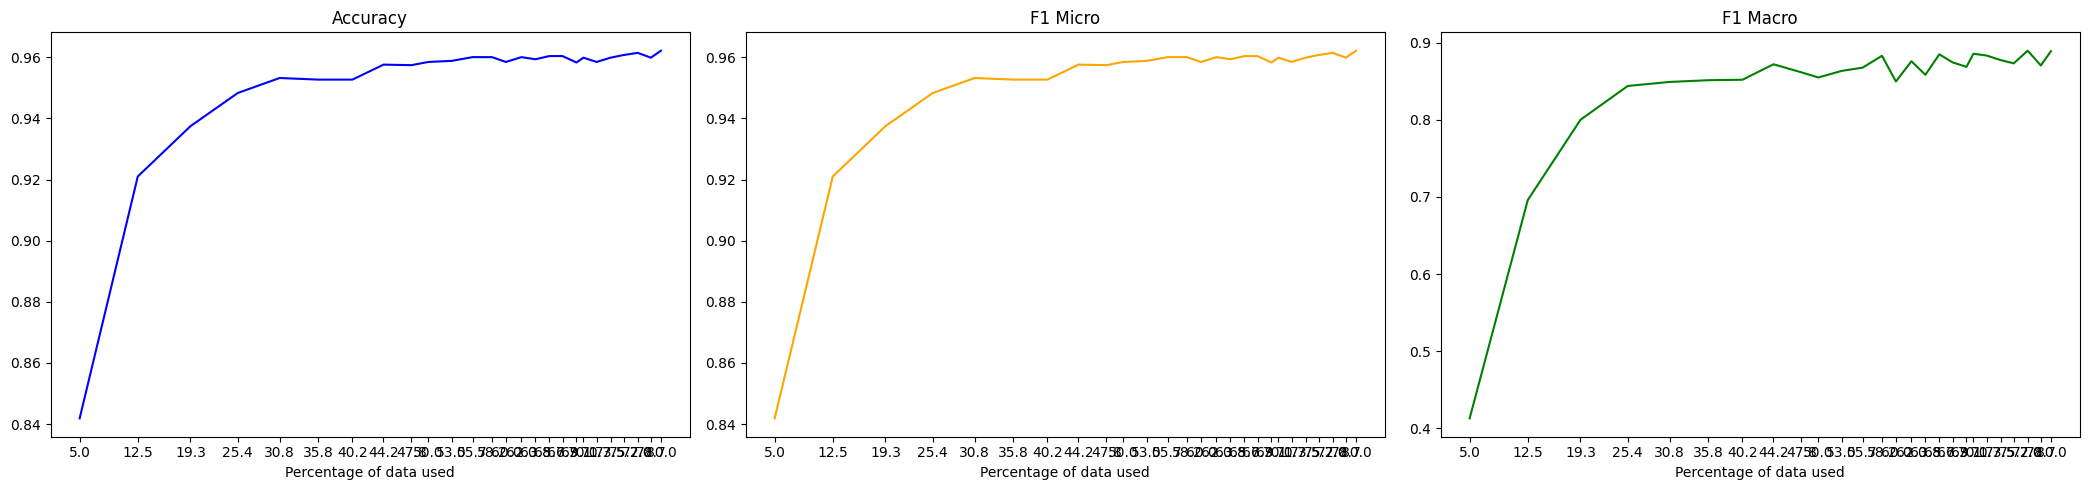

In [22]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6846, Accuracy: 0.7771, F1 Micro: 0.873, F1 Macro: 0.8661
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5356, Accuracy: 0.8012, F1 Micro: 0.8896, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4856, Accuracy: 0.8019, F1 Micro: 0.8899, F1 Macro: 0.8853
Epoch 4/10, Train Loss: 0.4451, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Epoch 5/10, Train Loss: 0.447, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4104, Accuracy: 0.8038, F1 Micro: 0.8908, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4062, Accuracy: 0.8099, F1 Micro: 0.893, F1 Macro: 0.8864
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4023, Accuracy: 0.8189, F1 Micro: 0.8974, F1 Macro: 0.8906
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3668, Accuracy: 0.8349, F1 Micro: 0.9047, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6158, Accuracy: 0.6141, F1 Micro: 0.6141, F1 Macro: 0.3805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4961, Accuracy: 0.6141, F1 Micro: 0.6141, F1 Macro: 0.3805
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4198, Accuracy: 0.6141, F1 Micro: 0.6141, F1 Macro: 0.3805
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4426, Accuracy: 0.6141, F1 Micro: 0.6141, F1 Macro: 0.3805
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3147, Accuracy: 0.7391, F1 Micro: 0.7391, F1 Macro: 0.6783
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2361, Accuracy: 0.7636, F1 Micro: 0.7636, F1 Macro: 0.7349
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2395, Accuracy: 0.7663, F1 Micro: 0.7663, F1 Macro: 0.7452
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2328, Accuracy: 0.7935, F1 Micro: 0.7935, F1 Macro: 0.781
Epoch 9/10, Train Loss: 0.1405, Accuracy: 0.7799, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5902, Accuracy: 0.8021, F1 Micro: 0.8893, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4828, Accuracy: 0.803, F1 Micro: 0.8901, F1 Macro: 0.8847
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4616, Accuracy: 0.8215, F1 Micro: 0.8965, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4294, Accuracy: 0.8392, F1 Micro: 0.9074, F1 Macro: 0.9016
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3712, Accuracy: 0.8719, F1 Micro: 0.9239, F1 Macro: 0.9163
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3278, Accuracy: 0.8845, F1 Micro: 0.9304, F1 Macro: 0.9222
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2923, Accuracy: 0.8917, F1 Micro: 0.9352, F1 Macro: 0.9293
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2629, Accuracy: 0.9028, F1 Micro: 0.9417, F1 Macro: 0.9378
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5452, Accuracy: 0.7209, F1 Micro: 0.7209, F1 Macro: 0.4261
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4303, Accuracy: 0.7817, F1 Micro: 0.7817, F1 Macro: 0.7354
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3222, Accuracy: 0.8206, F1 Micro: 0.8206, F1 Macro: 0.7375
Epoch 4/10, Train Loss: 0.2765, Accuracy: 0.8195, F1 Micro: 0.8195, F1 Macro: 0.7279
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1842, Accuracy: 0.8426, F1 Micro: 0.8426, F1 Macro: 0.7762
Epoch 6/10, Train Loss: 0.1785, Accuracy: 0.8405, F1 Micro: 0.8405, F1 Macro: 0.7803
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1365, Accuracy: 0.8552, F1 Micro: 0.8552, F1 Macro: 0.8079
Epoch 8/10, Train Loss: 0.1089, Accuracy: 0.8468, F1 Micro: 0.8468, F1 Macro: 0.7747
Epoch 9/10, Train Loss: 0.1097, Accuracy: 0.8353, F1 Micro: 0.8353, F1 Macro: 0.7931
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0929, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5712, Accuracy: 0.8016, F1 Micro: 0.8851, F1 Macro: 0.8597
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4994, Accuracy: 0.8196, F1 Micro: 0.8964, F1 Macro: 0.8865
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4644, Accuracy: 0.8438, F1 Micro: 0.9071, F1 Macro: 0.8883
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3872, Accuracy: 0.8898, F1 Micro: 0.9332, F1 Macro: 0.9232
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.305, Accuracy: 0.9073, F1 Micro: 0.944, F1 Macro: 0.9392
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2601, Accuracy: 0.9281, F1 Micro: 0.9559, F1 Macro: 0.95
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2157, Accuracy: 0.9385, F1 Micro: 0.9625, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1935, Accuracy: 0.9411, F1 Micro: 0.9639, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5974, Accuracy: 0.7904, F1 Micro: 0.7904, F1 Macro: 0.6505
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4088, Accuracy: 0.8413, F1 Micro: 0.8413, F1 Macro: 0.7732
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3, Accuracy: 0.8523, F1 Micro: 0.8523, F1 Macro: 0.8017
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2198, Accuracy: 0.8842, F1 Micro: 0.8842, F1 Macro: 0.842
Epoch 5/10, Train Loss: 0.1715, Accuracy: 0.8762, F1 Micro: 0.8762, F1 Macro: 0.8218
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1147, Accuracy: 0.8872, F1 Micro: 0.8872, F1 Macro: 0.8413
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1149, Accuracy: 0.8892, F1 Micro: 0.8892, F1 Macro: 0.846
Epoch 8/10, Train Loss: 0.0848, Accuracy: 0.8772, F1 Micro: 0.8772, F1 Macro: 0.824
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0544, Accuracy: 0.8892, F1 Micro: 0.8892, F1 Macro: 0.8486
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5659, Accuracy: 0.7957, F1 Micro: 0.8803, F1 Macro: 0.8322
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4895, Accuracy: 0.83, F1 Micro: 0.8989, F1 Macro: 0.8726
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4212, Accuracy: 0.8755, F1 Micro: 0.9244, F1 Macro: 0.9066
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3349, Accuracy: 0.9082, F1 Micro: 0.944, F1 Macro: 0.936
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2678, Accuracy: 0.9351, F1 Micro: 0.9603, F1 Macro: 0.9569
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2331, Accuracy: 0.9453, F1 Micro: 0.9663, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1959, Accuracy: 0.9462, F1 Micro: 0.9669, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1734, Accuracy: 0.9514, F1 Micro: 0.97, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5696, Accuracy: 0.814, F1 Micro: 0.814, F1 Macro: 0.7637
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3993, Accuracy: 0.8627, F1 Micro: 0.8627, F1 Macro: 0.8139
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2862, Accuracy: 0.8958, F1 Micro: 0.8958, F1 Macro: 0.861
Epoch 4/10, Train Loss: 0.1776, Accuracy: 0.8948, F1 Micro: 0.8948, F1 Macro: 0.8557
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1269, Accuracy: 0.9026, F1 Micro: 0.9026, F1 Macro: 0.8696
Epoch 6/10, Train Loss: 0.1226, Accuracy: 0.8968, F1 Micro: 0.8968, F1 Macro: 0.8621
Epoch 7/10, Train Loss: 0.1122, Accuracy: 0.8958, F1 Micro: 0.8958, F1 Macro: 0.8552
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0774, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.8705
Epoch 9/10, Train Loss: 0.0756, Accuracy: 0.8997, F1 Micro: 0.8997, F1 Macro: 0.8651
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.05, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5647, Accuracy: 0.8059, F1 Micro: 0.8902, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4957, Accuracy: 0.8521, F1 Micro: 0.9131, F1 Macro: 0.9021
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3937, Accuracy: 0.8976, F1 Micro: 0.9388, F1 Macro: 0.9347
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3051, Accuracy: 0.9276, F1 Micro: 0.9561, F1 Macro: 0.9529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2421, Accuracy: 0.9401, F1 Micro: 0.9632, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.205, Accuracy: 0.9498, F1 Micro: 0.9692, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1758, Accuracy: 0.9526, F1 Micro: 0.9708, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1582, Accuracy: 0.9552, F1 Micro: 0.9722, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5602, Accuracy: 0.8519, F1 Micro: 0.8519, F1 Macro: 0.7965
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3105, Accuracy: 0.8813, F1 Micro: 0.8813, F1 Macro: 0.8385
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2087, Accuracy: 0.9012, F1 Micro: 0.9012, F1 Macro: 0.8711
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.9022, F1 Micro: 0.9022, F1 Macro: 0.8751
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.107, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8816
Epoch 6/10, Train Loss: 0.0868, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8797
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0663, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8805
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.9041, F1 Micro: 0.9041, F1 Macro: 0.875
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0569, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8799
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5567, Accuracy: 0.8083, F1 Micro: 0.889, F1 Macro: 0.8687
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4778, Accuracy: 0.8724, F1 Micro: 0.9245, F1 Macro: 0.9167
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3591, Accuracy: 0.9184, F1 Micro: 0.9507, F1 Macro: 0.9469
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.276, Accuracy: 0.9392, F1 Micro: 0.9628, F1 Macro: 0.9597
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2243, Accuracy: 0.95, F1 Micro: 0.9692, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1874, Accuracy: 0.9535, F1 Micro: 0.9713, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1652, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1395, Accuracy: 0.9554, F1 Micro: 0.9723, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4904, Accuracy: 0.8355, F1 Micro: 0.8355, F1 Macro: 0.7961
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3178, Accuracy: 0.8838, F1 Micro: 0.8838, F1 Macro: 0.8526
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2223, Accuracy: 0.895, F1 Micro: 0.895, F1 Macro: 0.8615
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1427, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8734
Epoch 5/10, Train Loss: 0.1012, Accuracy: 0.8931, F1 Micro: 0.8931, F1 Macro: 0.8577
Epoch 6/10, Train Loss: 0.1114, Accuracy: 0.8959, F1 Micro: 0.8959, F1 Macro: 0.8632
Epoch 7/10, Train Loss: 0.0777, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.8661
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.042, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8779
Epoch 9/10, Train Loss: 0.0336, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8747
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0473, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5492, Accuracy: 0.8036, F1 Micro: 0.8907, F1 Macro: 0.8863
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4487, Accuracy: 0.8847, F1 Micro: 0.9313, F1 Macro: 0.925
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3302, Accuracy: 0.9306, F1 Micro: 0.9574, F1 Macro: 0.9532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2546, Accuracy: 0.9481, F1 Micro: 0.968, F1 Macro: 0.9651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2094, Accuracy: 0.9526, F1 Micro: 0.9708, F1 Macro: 0.9678
Epoch 6/10, Train Loss: 0.1737, Accuracy: 0.9524, F1 Micro: 0.9706, F1 Macro: 0.9677
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1504, Accuracy: 0.9575, F1 Micro: 0.9736, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1311, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.113, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.471, Accuracy: 0.8508, F1 Micro: 0.8508, F1 Macro: 0.8131
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.297, Accuracy: 0.8941, F1 Micro: 0.8941, F1 Macro: 0.864
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1847, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8724
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1379, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8852
Epoch 5/10, Train Loss: 0.1231, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8776
Epoch 6/10, Train Loss: 0.076, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8816
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0607, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8834
Epoch 8/10, Train Loss: 0.0502, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8792
Epoch 9/10, Train Loss: 0.0476, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8782
Epoch 10/10, Train Loss: 0.0541, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5488, Accuracy: 0.8087, F1 Micro: 0.892, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4372, Accuracy: 0.8887, F1 Micro: 0.9328, F1 Macro: 0.9232
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3163, Accuracy: 0.9318, F1 Micro: 0.9581, F1 Macro: 0.9536
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2462, Accuracy: 0.9477, F1 Micro: 0.9678, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2016, Accuracy: 0.9545, F1 Micro: 0.9718, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1674, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1434, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1225, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9742
Epoch 9/10, Train Loss: 0.1078, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4552, Accuracy: 0.8593, F1 Micro: 0.8593, F1 Macro: 0.8212
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2808, Accuracy: 0.8931, F1 Micro: 0.8931, F1 Macro: 0.861
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1771, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1504, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8875
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1061, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.8886
Epoch 6/10, Train Loss: 0.0782, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0559, Accuracy: 0.9212, F1 Micro: 0.9212, F1 Macro: 0.8987
Epoch 8/10, Train Loss: 0.0456, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8865
Epoch 9/10, Train Loss: 0.0479, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8873
Epoch 10/10, Train Loss: 0.0453, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5366, Accuracy: 0.8134, F1 Micro: 0.8931, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4187, Accuracy: 0.901, F1 Micro: 0.9406, F1 Macro: 0.9351
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2974, Accuracy: 0.9399, F1 Micro: 0.9631, F1 Macro: 0.9598
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2382, Accuracy: 0.9465, F1 Micro: 0.967, F1 Macro: 0.9643
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1956, Accuracy: 0.951, F1 Micro: 0.9698, F1 Macro: 0.9674
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1659, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1405, Accuracy: 0.9595, F1 Micro: 0.9749, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1199, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9746
Epoch 9/10, Train Loss: 0.1013, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4315, Accuracy: 0.8554, F1 Micro: 0.8554, F1 Macro: 0.807
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.251, Accuracy: 0.8862, F1 Micro: 0.8862, F1 Macro: 0.8439
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1705, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8891
Epoch 4/10, Train Loss: 0.1197, Accuracy: 0.903, F1 Micro: 0.903, F1 Macro: 0.87
Epoch 5/10, Train Loss: 0.0928, Accuracy: 0.9086, F1 Micro: 0.9086, F1 Macro: 0.8784
Epoch 6/10, Train Loss: 0.0796, Accuracy: 0.9039, F1 Micro: 0.9039, F1 Macro: 0.872
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0643, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.8932
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0352, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.895
Epoch 9/10, Train Loss: 0.028, Accuracy: 0.9086, F1 Micro: 0.9086, F1 Macro: 0.8837
Epoch 10/10, Train Loss: 0.0289, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5313, Accuracy: 0.803, F1 Micro: 0.8905, F1 Macro: 0.8861
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4118, Accuracy: 0.9062, F1 Micro: 0.9433, F1 Macro: 0.9378
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2907, Accuracy: 0.9394, F1 Micro: 0.963, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2177, Accuracy: 0.953, F1 Micro: 0.9711, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1757, Accuracy: 0.9573, F1 Micro: 0.9734, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1504, Accuracy: 0.959, F1 Micro: 0.9747, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1317, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1121, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4372, Accuracy: 0.8533, F1 Micro: 0.8533, F1 Macro: 0.7925
Epoch 2/10, Train Loss: 0.2532, Accuracy: 0.8478, F1 Micro: 0.8478, F1 Macro: 0.7769
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1842, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8777
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1407, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8825
Epoch 5/10, Train Loss: 0.105, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8801
Epoch 6/10, Train Loss: 0.0806, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.882
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0612, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8911
Epoch 8/10, Train Loss: 0.042, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8841
Epoch 9/10, Train Loss: 0.0274, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.8809
Epoch 10/10, Train Loss: 0.0454, Accuracy: 0.9096, F1 Micro: 0.9096, F1 Macro: 0.8795

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5294, Accuracy: 0.825, F1 Micro: 0.9013, F1 Macro: 0.8968
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3912, Accuracy: 0.9208, F1 Micro: 0.9519, F1 Macro: 0.9476
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2666, Accuracy: 0.9411, F1 Micro: 0.964, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2076, Accuracy: 0.9535, F1 Micro: 0.9713, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1725, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1392, Accuracy: 0.9606, F1 Micro: 0.9755, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1273, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1073, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0926, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4338, Accuracy: 0.8662, F1 Micro: 0.8662, F1 Macro: 0.824
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.248, Accuracy: 0.8856, F1 Micro: 0.8856, F1 Macro: 0.8448
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1651, Accuracy: 0.8921, F1 Micro: 0.8921, F1 Macro: 0.8545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1135, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8782
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0991, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8836
Epoch 6/10, Train Loss: 0.0729, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8802
Epoch 7/10, Train Loss: 0.059, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8694
Epoch 8/10, Train Loss: 0.0481, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8807
Epoch 9/10, Train Loss: 0.0377, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.048, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5194, Accuracy: 0.8306, F1 Micro: 0.9031, F1 Macro: 0.8969
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3734, Accuracy: 0.917, F1 Micro: 0.9496, F1 Macro: 0.9449
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2666, Accuracy: 0.946, F1 Micro: 0.9668, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2115, Accuracy: 0.9542, F1 Micro: 0.9717, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1763, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1476, Accuracy: 0.9592, F1 Micro: 0.9747, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1229, Accuracy: 0.9615, F1 Micro: 0.9762, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.108, Accuracy: 0.9615, F1 Micro: 0.9762, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4061, Accuracy: 0.8573, F1 Micro: 0.8573, F1 Macro: 0.8223
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2324, Accuracy: 0.8934, F1 Micro: 0.8934, F1 Macro: 0.8622
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1546, Accuracy: 0.8979, F1 Micro: 0.8979, F1 Macro: 0.8648
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1131, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8887
Epoch 5/10, Train Loss: 0.0801, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8832
Epoch 6/10, Train Loss: 0.0753, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8791
Epoch 7/10, Train Loss: 0.0539, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8796
Epoch 8/10, Train Loss: 0.0441, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8788
Epoch 9/10, Train Loss: 0.0328, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.8765
Epoch 10/10, Train Loss: 0.0356, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8816

Sentiment analys

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.518, Accuracy: 0.8276, F1 Micro: 0.9015, F1 Macro: 0.8939
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3607, Accuracy: 0.9278, F1 Micro: 0.956, F1 Macro: 0.9524
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2501, Accuracy: 0.9415, F1 Micro: 0.9644, F1 Macro: 0.962
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2034, Accuracy: 0.9491, F1 Micro: 0.9689, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1647, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1386, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1177, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macro: 0.9766
Epoch 8/10, Train Loss: 0.1058, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0866, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3702, Accuracy: 0.8602, F1 Micro: 0.8602, F1 Macro: 0.8272
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2344, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8795
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1516, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1437, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8891
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0926, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8899
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0764, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.8931
Epoch 7/10, Train Loss: 0.0533, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.9181, F1 Micro: 0.9181, F1 Macro: 0.8933
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.9172, F1 Micro: 0.9172, F1 Macro: 0.8935
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5107, Accuracy: 0.8368, F1 Micro: 0.9066, F1 Macro: 0.9004
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3528, Accuracy: 0.9288, F1 Micro: 0.9567, F1 Macro: 0.9536
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2451, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.193, Accuracy: 0.9538, F1 Micro: 0.9716, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1555, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1338, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1127, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.0949, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0806, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3702, Accuracy: 0.8607, F1 Micro: 0.8607, F1 Macro: 0.8125
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2121, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8787
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.144, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8878
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1103, Accuracy: 0.9166, F1 Micro: 0.9166, F1 Macro: 0.8923
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0933, Accuracy: 0.9175, F1 Micro: 0.9175, F1 Macro: 0.8936
Epoch 6/10, Train Loss: 0.0606, Accuracy: 0.9166, F1 Micro: 0.9166, F1 Macro: 0.8921
Epoch 7/10, Train Loss: 0.0534, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8847
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0435, Accuracy: 0.9175, F1 Micro: 0.9175, F1 Macro: 0.8936
Epoch 9/10, Train Loss: 0.0312, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8884
Epoch 10/10, Train Loss: 0.0333, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.498, Accuracy: 0.8486, F1 Micro: 0.9114, F1 Macro: 0.9019
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3453, Accuracy: 0.9316, F1 Micro: 0.9582, F1 Macro: 0.954
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.239, Accuracy: 0.9476, F1 Micro: 0.9678, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1907, Accuracy: 0.9545, F1 Micro: 0.972, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1598, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9734
Epoch 6/10, Train Loss: 0.1329, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1094, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macro: 0.9766
Epoch 8/10, Train Loss: 0.0935, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9744
Epoch 9/10, Train Loss: 0.0811, Accuracy: 0.9623, F1 Micro: 0.9765, F1 Macro: 0.9737
Epoch 10/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3759, Accuracy: 0.8705, F1 Micro: 0.8705, F1 Macro: 0.8266
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2192, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8731
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1481, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1294, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8908
Epoch 5/10, Train Loss: 0.0914, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.8889
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0613, Accuracy: 0.9174, F1 Micro: 0.9174, F1 Macro: 0.8923
Epoch 7/10, Train Loss: 0.0661, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8728
Epoch 8/10, Train Loss: 0.0391, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.8841
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.8838
Epoch 10/10, Train Loss: 0.0436, Accuracy: 0.9137, F1 Micro: 0.9137, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5044, Accuracy: 0.8283, F1 Micro: 0.9027, F1 Macro: 0.8973
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3395, Accuracy: 0.9285, F1 Micro: 0.9567, F1 Macro: 0.9534
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2401, Accuracy: 0.9443, F1 Micro: 0.966, F1 Macro: 0.9637
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1847, Accuracy: 0.9559, F1 Micro: 0.9728, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1561, Accuracy: 0.9599, F1 Micro: 0.9751, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1326, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1087, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0926, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.0773, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3964, Accuracy: 0.8732, F1 Micro: 0.8732, F1 Macro: 0.8296
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2139, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.8787
Epoch 3/10, Train Loss: 0.1436, Accuracy: 0.8952, F1 Micro: 0.8952, F1 Macro: 0.86
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1085, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8888
Epoch 5/10, Train Loss: 0.0843, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8869
Epoch 6/10, Train Loss: 0.0802, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8843
Epoch 7/10, Train Loss: 0.0538, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.888
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0387, Accuracy: 0.9191, F1 Micro: 0.9191, F1 Macro: 0.8949
Epoch 9/10, Train Loss: 0.0343, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8903
Epoch 10/10, Train Loss: 0.0379, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8873

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4913, Accuracy: 0.8675, F1 Micro: 0.922, F1 Macro: 0.9149
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3188, Accuracy: 0.9361, F1 Micro: 0.9611, F1 Macro: 0.9579
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.22, Accuracy: 0.9434, F1 Micro: 0.9654, F1 Macro: 0.9633
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1722, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1465, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1219, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1037, Accuracy: 0.9653, F1 Micro: 0.9785, F1 Macro: 0.9764
Epoch 8/10, Train Loss: 0.0906, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0725, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3578, Accuracy: 0.8742, F1 Micro: 0.8742, F1 Macro: 0.8363
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2086, Accuracy: 0.8905, F1 Micro: 0.8905, F1 Macro: 0.8609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1435, Accuracy: 0.9023, F1 Micro: 0.9023, F1 Macro: 0.8723
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0958, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8834
Epoch 5/10, Train Loss: 0.0858, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.879
Epoch 6/10, Train Loss: 0.0599, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0462, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.047, Accuracy: 0.9158, F1 Micro: 0.9158, F1 Macro: 0.8917
Epoch 9/10, Train Loss: 0.0426, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8844
Epoch 10/10, Train Loss: 0.0253, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4895, Accuracy: 0.8665, F1 Micro: 0.9212, F1 Macro: 0.9122
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3148, Accuracy: 0.9382, F1 Micro: 0.9623, F1 Macro: 0.9595
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.221, Accuracy: 0.9488, F1 Micro: 0.9687, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.176, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1429, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1195, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1005, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0706, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3607, Accuracy: 0.8592, F1 Micro: 0.8592, F1 Macro: 0.7982
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2094, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8782
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1277, Accuracy: 0.9108, F1 Micro: 0.9108, F1 Macro: 0.8821
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1083, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.888
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0669, Accuracy: 0.9209, F1 Micro: 0.9209, F1 Macro: 0.8978
Epoch 6/10, Train Loss: 0.0521, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8909
Epoch 7/10, Train Loss: 0.0436, Accuracy: 0.9172, F1 Micro: 0.9172, F1 Macro: 0.8923
Epoch 8/10, Train Loss: 0.0419, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8763
Epoch 9/10, Train Loss: 0.0288, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8905
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.9071, F1 Micro: 0.9071, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4871, Accuracy: 0.8747, F1 Micro: 0.9259, F1 Macro: 0.9186
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3081, Accuracy: 0.9325, F1 Micro: 0.9589, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2133, Accuracy: 0.9503, F1 Micro: 0.9695, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1716, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1387, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9744
Epoch 6/10, Train Loss: 0.1173, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.974
Epoch 7/10, Train Loss: 0.1002, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0846, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0701, Accuracy: 0.967, F1 Micro: 0.9794, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3518, Accuracy: 0.8642, F1 Micro: 0.8642, F1 Macro: 0.8257
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2171, Accuracy: 0.8997, F1 Micro: 0.8997, F1 Macro: 0.871
Epoch 3/10, Train Loss: 0.1338, Accuracy: 0.8988, F1 Micro: 0.8988, F1 Macro: 0.8703
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1085, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8786
Epoch 5/10, Train Loss: 0.0776, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.8751
Epoch 6/10, Train Loss: 0.0662, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8697
Epoch 7/10, Train Loss: 0.0524, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8773
Epoch 8/10, Train Loss: 0.0436, Accuracy: 0.9042, F1 Micro: 0.9042, F1 Macro: 0.8774
Epoch 9/10, Train Loss: 0.0424, Accuracy: 0.8997, F1 Micro: 0.8997, F1 Macro: 0.8715
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0268, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8793

Sentiment analysi

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.483, Accuracy: 0.8661, F1 Micro: 0.9217, F1 Macro: 0.9158
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3085, Accuracy: 0.9332, F1 Micro: 0.9594, F1 Macro: 0.957
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2145, Accuracy: 0.9467, F1 Micro: 0.9674, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.9543, F1 Micro: 0.9718, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1384, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9747
Epoch 6/10, Train Loss: 0.1156, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0997, Accuracy: 0.9658, F1 Micro: 0.9787, F1 Macro: 0.9767
Epoch 8/10, Train Loss: 0.0829, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Macro: 0.9748
Epoch 9/10, Train Loss: 0.0673, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9747
Epoch 10/10, Train Loss

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3602, Accuracy: 0.8713, F1 Micro: 0.8713, F1 Macro: 0.8407
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2252, Accuracy: 0.8948, F1 Micro: 0.8948, F1 Macro: 0.8609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1599, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8858
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1049, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0917, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.89
Epoch 6/10, Train Loss: 0.0756, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8761
Epoch 7/10, Train Loss: 0.0508, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0423, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.8901
Epoch 9/10, Train Loss: 0.0294, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.8867
Epoch 10/10, Train Loss: 0.0336, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4772, Accuracy: 0.8694, F1 Micro: 0.9227, F1 Macro: 0.9145
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2993, Accuracy: 0.9396, F1 Micro: 0.9631, F1 Macro: 0.9603
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.209, Accuracy: 0.9493, F1 Micro: 0.969, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1682, Accuracy: 0.9559, F1 Micro: 0.9727, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1357, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.9705
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1138, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0954, Accuracy: 0.9658, F1 Micro: 0.9787, F1 Macro: 0.9768
Epoch 8/10, Train Loss: 0.0839, Accuracy: 0.9648, F1 Micro: 0.978, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.07, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3443, Accuracy: 0.8645, F1 Micro: 0.8645, F1 Macro: 0.8125
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1994, Accuracy: 0.8943, F1 Micro: 0.8943, F1 Macro: 0.8629
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1347, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8842
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0891, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.887
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0838, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8887
Epoch 6/10, Train Loss: 0.0553, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8744
Epoch 7/10, Train Loss: 0.0398, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8796
Epoch 8/10, Train Loss: 0.0467, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8814
Epoch 9/10, Train Loss: 0.0344, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8829
Epoch 10/10, Train Loss: 0.0188, Accuracy: 0.9106, F1 Micro: 0.9106, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4753, Accuracy: 0.8714, F1 Micro: 0.9252, F1 Macro: 0.9206
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2911, Accuracy: 0.9382, F1 Micro: 0.9623, F1 Macro: 0.9599
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2033, Accuracy: 0.9486, F1 Micro: 0.9685, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1634, Accuracy: 0.9559, F1 Micro: 0.9729, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9756
Epoch 6/10, Train Loss: 0.1109, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9753
Epoch 7/10, Train Loss: 0.0906, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9752
Epoch 8/10, Train Loss: 0.0781, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0647, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9762
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3461, Accuracy: 0.877, F1 Micro: 0.877, F1 Macro: 0.8386
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.205, Accuracy: 0.8966, F1 Micro: 0.8966, F1 Macro: 0.8611
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1295, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Macro: 0.8902
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1036, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.896
Epoch 5/10, Train Loss: 0.0599, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0571, Accuracy: 0.9245, F1 Micro: 0.9245, F1 Macro: 0.9013
Epoch 7/10, Train Loss: 0.0521, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8837
Epoch 8/10, Train Loss: 0.0358, Accuracy: 0.9199, F1 Micro: 0.9199, F1 Macro: 0.897
Epoch 9/10, Train Loss: 0.0321, Accuracy: 0.9152, F1 Micro: 0.9152, F1 Macro: 0.8873
Epoch 10/10, Train Loss: 0.0186, Accuracy: 0.9199, F1 Micro: 0.9199, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4629, Accuracy: 0.8778, F1 Micro: 0.9274, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.279, Accuracy: 0.9429, F1 Micro: 0.965, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1949, Accuracy: 0.9505, F1 Micro: 0.9695, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1593, Accuracy: 0.9549, F1 Micro: 0.9722, F1 Macro: 0.97
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1311, Accuracy: 0.9585, F1 Micro: 0.9744, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1116, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0906, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0757, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3505, Accuracy: 0.8637, F1 Micro: 0.8637, F1 Macro: 0.8183
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1939, Accuracy: 0.9021, F1 Micro: 0.9021, F1 Macro: 0.8754
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1218, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8863
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0968, Accuracy: 0.9158, F1 Micro: 0.9158, F1 Macro: 0.8911
Epoch 5/10, Train Loss: 0.0649, Accuracy: 0.914, F1 Micro: 0.914, F1 Macro: 0.8869
Epoch 6/10, Train Loss: 0.0515, Accuracy: 0.9122, F1 Micro: 0.9122, F1 Macro: 0.8858
Epoch 7/10, Train Loss: 0.0536, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8821
Epoch 8/10, Train Loss: 0.0442, Accuracy: 0.9085, F1 Micro: 0.9085, F1 Macro: 0.8844
Epoch 9/10, Train Loss: 0.0232, Accuracy: 0.9131, F1 Micro: 0.9131, F1 Macro: 0.8879
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0346, Accuracy: 0.9177, F1 Micro: 0.9177, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4641, Accuracy: 0.8769, F1 Micro: 0.9275, F1 Macro: 0.9215
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2748, Accuracy: 0.9398, F1 Micro: 0.9633, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1925, Accuracy: 0.9497, F1 Micro: 0.969, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1573, Accuracy: 0.9554, F1 Micro: 0.9725, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1325, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1078, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9762
Epoch 7/10, Train Loss: 0.0882, Accuracy: 0.9639, F1 Micro: 0.9775, F1 Macro: 0.9752
Epoch 8/10, Train Loss: 0.0726, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9755
Epoch 9/10, Train Loss: 0.062, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9758
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3496, Accuracy: 0.8716, F1 Micro: 0.8716, F1 Macro: 0.8326
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1997, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8763
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1518, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8815
Epoch 4/10, Train Loss: 0.1084, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8778
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0833, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.07, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.8909
Epoch 7/10, Train Loss: 0.0431, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8868
Epoch 8/10, Train Loss: 0.0461, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.888
Epoch 9/10, Train Loss: 0.0311, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8889
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.037, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4489, Accuracy: 0.884, F1 Micro: 0.9313, F1 Macro: 0.9259
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2651, Accuracy: 0.9413, F1 Micro: 0.9641, F1 Macro: 0.9618
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1887, Accuracy: 0.9519, F1 Micro: 0.9705, F1 Macro: 0.9689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1489, Accuracy: 0.9592, F1 Micro: 0.9748, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1247, Accuracy: 0.9592, F1 Micro: 0.9749, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1028, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0842, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3485, Accuracy: 0.8601, F1 Micro: 0.8601, F1 Macro: 0.8311
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1874, Accuracy: 0.8993, F1 Micro: 0.8993, F1 Macro: 0.8697
Epoch 3/10, Train Loss: 0.1343, Accuracy: 0.8975, F1 Micro: 0.8975, F1 Macro: 0.864
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0874, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8804
Epoch 5/10, Train Loss: 0.0767, Accuracy: 0.8939, F1 Micro: 0.8939, F1 Macro: 0.8612
Epoch 6/10, Train Loss: 0.0648, Accuracy: 0.9037, F1 Micro: 0.9037, F1 Macro: 0.8758
Epoch 7/10, Train Loss: 0.0417, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.8774
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0382, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8832
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0289, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8822
Epoch 10/10, Train Loss: 0.0306, Accuracy: 0.9064, F1 Micro: 0.9064, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4456, Accuracy: 0.8868, F1 Micro: 0.9331, F1 Macro: 0.9281
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2567, Accuracy: 0.9432, F1 Micro: 0.9653, F1 Macro: 0.9631
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.9481, F1 Micro: 0.9682, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1467, Accuracy: 0.9543, F1 Micro: 0.9719, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1218, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1011, Accuracy: 0.9649, F1 Micro: 0.9783, F1 Macro: 0.9761
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9648, F1 Micro: 0.9782, F1 Macro: 0.9761
Epoch 8/10, Train Loss: 0.0694, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9758
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.976
Higher F1 achieved, saving

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3436, Accuracy: 0.8675, F1 Micro: 0.8675, F1 Macro: 0.8241
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1863, Accuracy: 0.8949, F1 Micro: 0.8949, F1 Macro: 0.8598
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1294, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8801
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0952, Accuracy: 0.9086, F1 Micro: 0.9086, F1 Macro: 0.8811
Epoch 5/10, Train Loss: 0.0732, Accuracy: 0.9013, F1 Micro: 0.9013, F1 Macro: 0.8676
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0624, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0498, Accuracy: 0.9141, F1 Micro: 0.9141, F1 Macro: 0.8875
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0323, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0.893
Epoch 9/10, Train Loss: 0.0338, Accuracy: 0.915, F1 Micro: 0.915, F1 Macro: 0.8888
Higher 

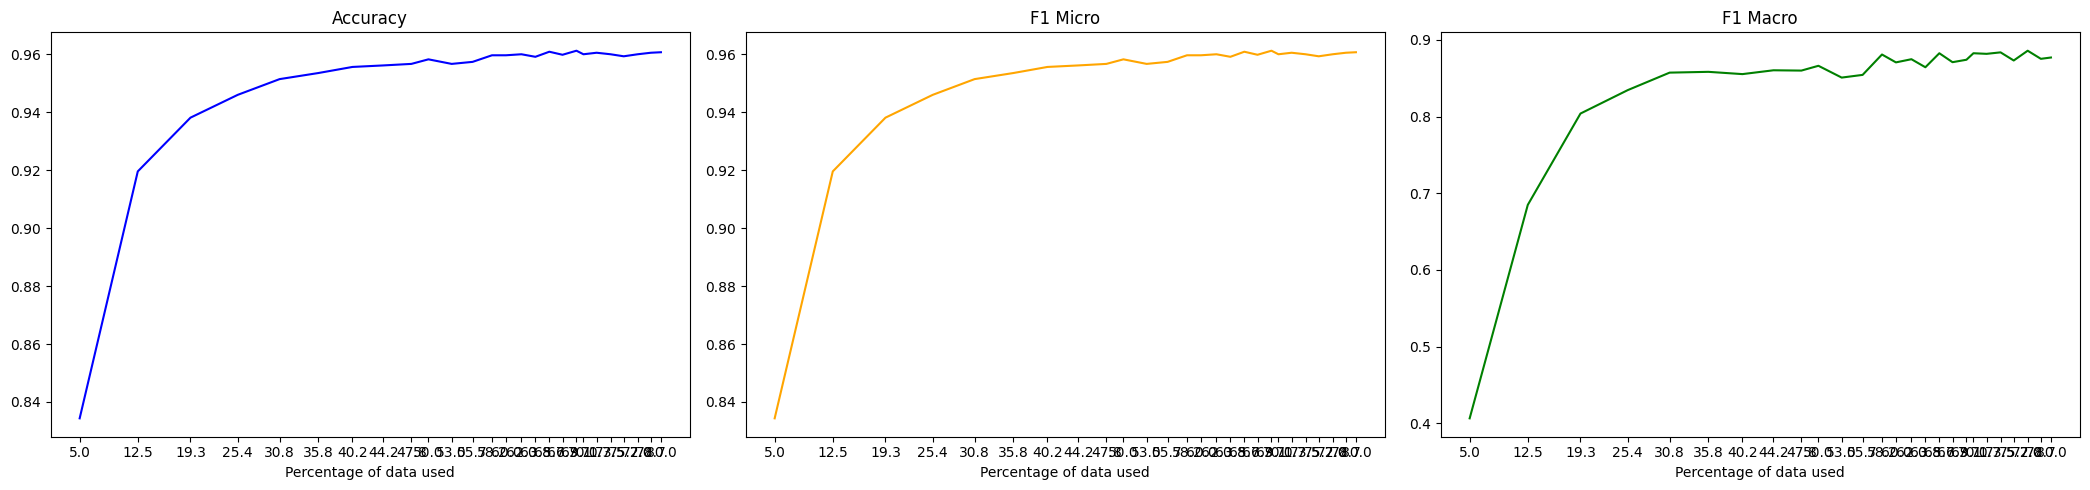

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6341, Accuracy: 0.7974, F1 Micro: 0.8859, F1 Macro: 0.8768
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5134, Accuracy: 0.8014, F1 Micro: 0.8897, F1 Macro: 0.8853
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4829, Accuracy: 0.8017, F1 Micro: 0.8897, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4632, Accuracy: 0.8045, F1 Micro: 0.8906, F1 Macro: 0.8847
Epoch 5/10, Train Loss: 0.4642, Accuracy: 0.8047, F1 Micro: 0.8903, F1 Macro: 0.8835
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4501, Accuracy: 0.8075, F1 Micro: 0.891, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.451, Accuracy: 0.8149, F1 Micro: 0.8947, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.4034, Accuracy: 0.8273, F1 Micro: 0.9007, F1 Macro: 0.892
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3957, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.7316, Accuracy: 0.5412, F1 Micro: 0.5412, F1 Macro: 0.3512
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.612, Accuracy: 0.5412, F1 Micro: 0.5412, F1 Macro: 0.3512
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.5437, Accuracy: 0.5645, F1 Micro: 0.5645, F1 Macro: 0.4185
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.5596, Accuracy: 0.5751, F1 Micro: 0.5751, F1 Macro: 0.4522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4998, Accuracy: 0.5877, F1 Micro: 0.5877, F1 Macro: 0.5659
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.478, Accuracy: 0.6025, F1 Micro: 0.6025, F1 Macro: 0.5626
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3806, Accuracy: 0.666, F1 Micro: 0.666, F1 Macro: 0.6564
Epoch 8/10, Train Loss: 0.3522, Accuracy: 0.6195, F1 Micro: 0.6195, F1 Macro: 0.5823
Epoch 9/10, Train Loss: 0.3548, Accuracy: 0.6575, F1 Micro: 0.6575, F1 Macro: 0.6482
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5693, Accuracy: 0.8017, F1 Micro: 0.8896, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4791, Accuracy: 0.8064, F1 Micro: 0.8901, F1 Macro: 0.8797
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4611, Accuracy: 0.8269, F1 Micro: 0.9007, F1 Macro: 0.8932
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4498, Accuracy: 0.8366, F1 Micro: 0.9051, F1 Macro: 0.8964
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4257, Accuracy: 0.8493, F1 Micro: 0.9125, F1 Macro: 0.9065
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3525, Accuracy: 0.8776, F1 Micro: 0.9277, F1 Macro: 0.922
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3306, Accuracy: 0.8915, F1 Micro: 0.9357, F1 Macro: 0.9318
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2789, Accuracy: 0.9042, F1 Micro: 0.9427, F1 Macro: 0.9391
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5393, Accuracy: 0.7231, F1 Micro: 0.7231, F1 Macro: 0.4196
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4395, Accuracy: 0.7908, F1 Micro: 0.7908, F1 Macro: 0.6718
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4216, Accuracy: 0.815, F1 Micro: 0.815, F1 Macro: 0.7372
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.334, Accuracy: 0.8392, F1 Micro: 0.8392, F1 Macro: 0.7932
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2945, Accuracy: 0.8501, F1 Micro: 0.8501, F1 Macro: 0.792
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2391, Accuracy: 0.8597, F1 Micro: 0.8597, F1 Macro: 0.8094
Epoch 7/10, Train Loss: 0.2104, Accuracy: 0.8513, F1 Micro: 0.8513, F1 Macro: 0.8135
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1771, Accuracy: 0.8767, F1 Micro: 0.8767, F1 Macro: 0.8324
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1133, Accuracy: 0.8803, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5453, Accuracy: 0.7953, F1 Micro: 0.8804, F1 Macro: 0.8373
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4917, Accuracy: 0.8247, F1 Micro: 0.8963, F1 Macro: 0.8759
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4554, Accuracy: 0.8415, F1 Micro: 0.908, F1 Macro: 0.9007
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3916, Accuracy: 0.8809, F1 Micro: 0.9294, F1 Macro: 0.9238
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3406, Accuracy: 0.8913, F1 Micro: 0.935, F1 Macro: 0.9294
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2813, Accuracy: 0.921, F1 Micro: 0.9521, F1 Macro: 0.9486
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2391, Accuracy: 0.9337, F1 Micro: 0.9594, F1 Macro: 0.9557
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2066, Accuracy: 0.9352, F1 Micro: 0.9605, F1 Macro: 0.9578
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6068, Accuracy: 0.8084, F1 Micro: 0.8084, F1 Macro: 0.7319
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4439, Accuracy: 0.8482, F1 Micro: 0.8482, F1 Macro: 0.7876
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3349, Accuracy: 0.8607, F1 Micro: 0.8607, F1 Macro: 0.8172
Epoch 4/10, Train Loss: 0.2987, Accuracy: 0.8492, F1 Micro: 0.8492, F1 Macro: 0.7817
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.235, Accuracy: 0.8869, F1 Micro: 0.8869, F1 Macro: 0.8435
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1605, Accuracy: 0.888, F1 Micro: 0.888, F1 Macro: 0.8479
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1255, Accuracy: 0.8942, F1 Micro: 0.8942, F1 Macro: 0.8556
Epoch 8/10, Train Loss: 0.0842, Accuracy: 0.888, F1 Micro: 0.888, F1 Macro: 0.8418
Epoch 9/10, Train Loss: 0.0904, Accuracy: 0.8827, F1 Micro: 0.8827, F1 Macro: 0.833
Epoch 10/10, Train Loss: 0.0624, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.554, Accuracy: 0.8111, F1 Micro: 0.8895, F1 Macro: 0.8609
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4971, Accuracy: 0.838, F1 Micro: 0.9064, F1 Macro: 0.8994
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4251, Accuracy: 0.8799, F1 Micro: 0.9285, F1 Macro: 0.9214
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3444, Accuracy: 0.9071, F1 Micro: 0.9442, F1 Macro: 0.9397
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2893, Accuracy: 0.9285, F1 Micro: 0.9564, F1 Macro: 0.9527
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2404, Accuracy: 0.9347, F1 Micro: 0.96, F1 Macro: 0.9562
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1969, Accuracy: 0.9455, F1 Micro: 0.9665, F1 Macro: 0.9638
Epoch 8/10, Train Loss: 0.1819, Accuracy: 0.9448, F1 Micro: 0.9661, F1 Macro: 0.9638
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1562, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5905, Accuracy: 0.831, F1 Micro: 0.831, F1 Macro: 0.7652
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4281, Accuracy: 0.8583, F1 Micro: 0.8583, F1 Macro: 0.8199
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2887, Accuracy: 0.8957, F1 Micro: 0.8957, F1 Macro: 0.8569
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1813, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1179, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.8893
Epoch 6/10, Train Loss: 0.0992, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8821
Epoch 7/10, Train Loss: 0.0972, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8846
Epoch 8/10, Train Loss: 0.0568, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.8827
Epoch 9/10, Train Loss: 0.0444, Accuracy: 0.9069, F1 Micro: 0.9069, F1 Macro: 0.8762
Epoch 10/10, Train Loss: 0.035, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5483, Accuracy: 0.8201, F1 Micro: 0.8977, F1 Macro: 0.8901
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4745, Accuracy: 0.8523, F1 Micro: 0.9134, F1 Macro: 0.9042
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.388, Accuracy: 0.9016, F1 Micro: 0.9407, F1 Macro: 0.9354
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3044, Accuracy: 0.9316, F1 Micro: 0.9582, F1 Macro: 0.9542
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2414, Accuracy: 0.9427, F1 Micro: 0.9649, F1 Macro: 0.9623
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2087, Accuracy: 0.9484, F1 Micro: 0.9683, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.171, Accuracy: 0.949, F1 Micro: 0.9686, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1462, Accuracy: 0.9547, F1 Micro: 0.972, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5716, Accuracy: 0.8387, F1 Micro: 0.8387, F1 Macro: 0.7986
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3787, Accuracy: 0.8736, F1 Micro: 0.8736, F1 Macro: 0.8392
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2587, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.8713
Epoch 4/10, Train Loss: 0.1881, Accuracy: 0.8953, F1 Micro: 0.8953, F1 Macro: 0.8623
Epoch 5/10, Train Loss: 0.153, Accuracy: 0.8962, F1 Micro: 0.8962, F1 Macro: 0.8692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0984, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8754
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0777, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8748
Epoch 8/10, Train Loss: 0.0485, Accuracy: 0.8991, F1 Micro: 0.8991, F1 Macro: 0.8688
Epoch 9/10, Train Loss: 0.0408, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.8693
Epoch 10/10, Train Loss: 0.0385, Accuracy: 0.9, F1 Micro: 0.9, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5415, Accuracy: 0.8043, F1 Micro: 0.8865, F1 Macro: 0.8612
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4623, Accuracy: 0.8684, F1 Micro: 0.9224, F1 Macro: 0.9157
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3681, Accuracy: 0.9132, F1 Micro: 0.9475, F1 Macro: 0.9432
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2796, Accuracy: 0.9347, F1 Micro: 0.9601, F1 Macro: 0.9568
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2263, Accuracy: 0.9458, F1 Micro: 0.9667, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1834, Accuracy: 0.9523, F1 Micro: 0.9706, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1659, Accuracy: 0.9547, F1 Micro: 0.9721, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1401, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.539, Accuracy: 0.8454, F1 Micro: 0.8454, F1 Macro: 0.7893
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3319, Accuracy: 0.8796, F1 Micro: 0.8796, F1 Macro: 0.8418
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2241, Accuracy: 0.8991, F1 Micro: 0.8991, F1 Macro: 0.87
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1719, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.8777
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0998, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8798
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0936, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8814
Epoch 7/10, Train Loss: 0.0793, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8806
Epoch 8/10, Train Loss: 0.0551, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.8658
Epoch 9/10, Train Loss: 0.0518, Accuracy: 0.9, F1 Micro: 0.9, F1 Macro: 0.8707
Epoch 10/10, Train Loss: 0.0387, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5338, Accuracy: 0.8139, F1 Micro: 0.895, F1 Macro: 0.8885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4466, Accuracy: 0.88, F1 Micro: 0.9286, F1 Macro: 0.9216
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3484, Accuracy: 0.9262, F1 Micro: 0.955, F1 Macro: 0.9508
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2568, Accuracy: 0.9458, F1 Micro: 0.9668, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2118, Accuracy: 0.9533, F1 Micro: 0.9712, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.177, Accuracy: 0.958, F1 Micro: 0.974, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1485, Accuracy: 0.9595, F1 Micro: 0.9749, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1348, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9728
Epoch 9/10, Train Loss: 0.1128, Accuracy: 0.96

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5215, Accuracy: 0.8499, F1 Micro: 0.8499, F1 Macro: 0.7969
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.294, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8714
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2097, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1532, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8824
Epoch 5/10, Train Loss: 0.0901, Accuracy: 0.9033, F1 Micro: 0.9033, F1 Macro: 0.8723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0878, Accuracy: 0.9079, F1 Micro: 0.9079, F1 Macro: 0.8811
Epoch 7/10, Train Loss: 0.0548, Accuracy: 0.9024, F1 Micro: 0.9024, F1 Macro: 0.871
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8768
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8834
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5312, Accuracy: 0.8236, F1 Micro: 0.8999, F1 Macro: 0.8944
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4298, Accuracy: 0.8887, F1 Micro: 0.933, F1 Macro: 0.926
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3174, Accuracy: 0.9332, F1 Micro: 0.9589, F1 Macro: 0.9546
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2452, Accuracy: 0.9481, F1 Micro: 0.9681, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1971, Accuracy: 0.9533, F1 Micro: 0.9711, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1658, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1426, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1224, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4626, Accuracy: 0.8611, F1 Micro: 0.8611, F1 Macro: 0.8054
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2838, Accuracy: 0.8944, F1 Micro: 0.8944, F1 Macro: 0.8623
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2021, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8777
Epoch 4/10, Train Loss: 0.1191, Accuracy: 0.9037, F1 Micro: 0.9037, F1 Macro: 0.8706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0919, Accuracy: 0.9185, F1 Micro: 0.9185, F1 Macro: 0.8944
Epoch 6/10, Train Loss: 0.0772, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.884
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.8894
Epoch 8/10, Train Loss: 0.0522, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8829
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8813
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0293, Accuracy: 0.9204, F1 Micro: 0.9204, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5234, Accuracy: 0.8342, F1 Micro: 0.9048, F1 Macro: 0.8982
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4147, Accuracy: 0.899, F1 Micro: 0.94, F1 Macro: 0.936
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2886, Accuracy: 0.9405, F1 Micro: 0.9636, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2313, Accuracy: 0.951, F1 Micro: 0.97, F1 Macro: 0.9675
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1843, Accuracy: 0.9582, F1 Micro: 0.9741, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1529, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.127, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1127, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9743
Epoch 9/10, Train Loss: 0.0968, Accuracy: 0.9602,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.467, Accuracy: 0.8522, F1 Micro: 0.8522, F1 Macro: 0.7989
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2806, Accuracy: 0.8894, F1 Micro: 0.8894, F1 Macro: 0.8615
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1832, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8776
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1367, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8822
Epoch 5/10, Train Loss: 0.0864, Accuracy: 0.8903, F1 Micro: 0.8903, F1 Macro: 0.8529
Epoch 6/10, Train Loss: 0.0816, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8789
Epoch 7/10, Train Loss: 0.0547, Accuracy: 0.903, F1 Micro: 0.903, F1 Macro: 0.8739
Epoch 8/10, Train Loss: 0.0408, Accuracy: 0.9012, F1 Micro: 0.9012, F1 Macro: 0.8724
Epoch 9/10, Train Loss: 0.0258, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.8773
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0281, Accuracy: 0.9066, F1 Micro: 0.9066, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5198, Accuracy: 0.8293, F1 Micro: 0.903, F1 Macro: 0.8978
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4029, Accuracy: 0.9059, F1 Micro: 0.9434, F1 Macro: 0.9388
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2901, Accuracy: 0.9389, F1 Micro: 0.9628, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2227, Accuracy: 0.9509, F1 Micro: 0.9698, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1846, Accuracy: 0.9583, F1 Micro: 0.9743, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.155, Accuracy: 0.9599, F1 Micro: 0.9751, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.136, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9737
Epoch 8/10, Train Loss: 0.1151, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0986, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4552, Accuracy: 0.8528, F1 Micro: 0.8528, F1 Macro: 0.8232
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2647, Accuracy: 0.9016, F1 Micro: 0.9016, F1 Macro: 0.8762
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1943, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8835
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1205, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.8931
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0997, Accuracy: 0.9172, F1 Micro: 0.9172, F1 Macro: 0.8937
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0781, Accuracy: 0.919, F1 Micro: 0.919, F1 Macro: 0.8968
Epoch 7/10, Train Loss: 0.0543, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8915
Epoch 8/10, Train Loss: 0.032, Accuracy: 0.9172, F1 Micro: 0.9172, F1 Macro: 0.8946
Epoch 9/10, Train Loss: 0.0363, Accuracy: 0.9126, F1 Micro: 0.9126, F1 Macro: 0.8874
Epoch 10/10, Train Loss: 0.042, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5075, Accuracy: 0.8273, F1 Micro: 0.9021, F1 Macro: 0.8976
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3843, Accuracy: 0.9194, F1 Micro: 0.951, F1 Macro: 0.9458
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2656, Accuracy: 0.9429, F1 Micro: 0.965, F1 Macro: 0.9626
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2124, Accuracy: 0.9528, F1 Micro: 0.9709, F1 Macro: 0.9683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1742, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1444, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9736
Epoch 7/10, Train Loss: 0.1236, Accuracy: 0.9604, F1 Micro: 0.9755, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1071, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0886, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4328, Accuracy: 0.8628, F1 Micro: 0.8628, F1 Macro: 0.8258
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2599, Accuracy: 0.8852, F1 Micro: 0.8852, F1 Macro: 0.8481
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1783, Accuracy: 0.8996, F1 Micro: 0.8996, F1 Macro: 0.8718
Epoch 4/10, Train Loss: 0.1248, Accuracy: 0.896, F1 Micro: 0.896, F1 Macro: 0.8704
Epoch 5/10, Train Loss: 0.0934, Accuracy: 0.8942, F1 Micro: 0.8942, F1 Macro: 0.8596
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0772, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8678
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.8978, F1 Micro: 0.8978, F1 Macro: 0.8683
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0572, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8773
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8755
Epoch 10/10, Train Loss: 0.0238, Accuracy: 0.9049, F1 Micro: 0.9049, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.497, Accuracy: 0.8266, F1 Micro: 0.9018, F1 Macro: 0.8975
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3751, Accuracy: 0.9243, F1 Micro: 0.954, F1 Macro: 0.95
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2634, Accuracy: 0.9438, F1 Micro: 0.9656, F1 Macro: 0.963
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2045, Accuracy: 0.9517, F1 Micro: 0.9702, F1 Macro: 0.9673
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1695, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1442, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9739
Epoch 7/10, Train Loss: 0.124, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1061, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0923, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4311, Accuracy: 0.8456, F1 Micro: 0.8456, F1 Macro: 0.7819
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2717, Accuracy: 0.891, F1 Micro: 0.891, F1 Macro: 0.8631
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1765, Accuracy: 0.8974, F1 Micro: 0.8974, F1 Macro: 0.8652
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1231, Accuracy: 0.9019, F1 Micro: 0.9019, F1 Macro: 0.8755
Epoch 5/10, Train Loss: 0.0946, Accuracy: 0.901, F1 Micro: 0.901, F1 Macro: 0.8765
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0731, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8798
Epoch 7/10, Train Loss: 0.0585, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.8744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0387, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8856
Epoch 9/10, Train Loss: 0.0247, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8761
Epoch 10/10, Train Loss: 0.035, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5023, Accuracy: 0.8368, F1 Micro: 0.9058, F1 Macro: 0.8986
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3692, Accuracy: 0.9257, F1 Micro: 0.9548, F1 Macro: 0.951
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2541, Accuracy: 0.9406, F1 Micro: 0.9636, F1 Macro: 0.9608
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.195, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1635, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.136, Accuracy: 0.9604, F1 Micro: 0.9756, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1156, Accuracy: 0.9639, F1 Micro: 0.9775, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1011, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 9/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4198, Accuracy: 0.8584, F1 Micro: 0.8584, F1 Macro: 0.8077
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2156, Accuracy: 0.8984, F1 Micro: 0.8984, F1 Macro: 0.8693
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1808, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8737
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1184, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.883
Epoch 5/10, Train Loss: 0.0709, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0592, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0603, Accuracy: 0.912, F1 Micro: 0.912, F1 Macro: 0.8864
Epoch 8/10, Train Loss: 0.0477, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8843
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.883
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4962, Accuracy: 0.838, F1 Micro: 0.9075, F1 Macro: 0.9031
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3483, Accuracy: 0.9267, F1 Micro: 0.9554, F1 Macro: 0.9514
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2412, Accuracy: 0.9472, F1 Micro: 0.9676, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1884, Accuracy: 0.9545, F1 Micro: 0.9719, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1611, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1332, Accuracy: 0.9606, F1 Micro: 0.9757, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.114, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.1005, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0815, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4128, Accuracy: 0.8526, F1 Micro: 0.8526, F1 Macro: 0.7897
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2606, Accuracy: 0.8929, F1 Micro: 0.8929, F1 Macro: 0.86
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1703, Accuracy: 0.9075, F1 Micro: 0.9075, F1 Macro: 0.8805
Epoch 4/10, Train Loss: 0.1307, Accuracy: 0.9057, F1 Micro: 0.9057, F1 Macro: 0.877
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0951, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8831
Epoch 6/10, Train Loss: 0.0752, Accuracy: 0.9029, F1 Micro: 0.9029, F1 Macro: 0.8745
Epoch 7/10, Train Loss: 0.0631, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.878
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0502, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.886
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.9048, F1 Micro: 0.9048, F1 Macro: 0.8777
Epoch 10/10, Train Loss: 0.0353, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4932, Accuracy: 0.847, F1 Micro: 0.9116, F1 Macro: 0.9052
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3328, Accuracy: 0.9295, F1 Micro: 0.9569, F1 Macro: 0.9529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2334, Accuracy: 0.9465, F1 Micro: 0.9672, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1875, Accuracy: 0.953, F1 Micro: 0.971, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1544, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1315, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1097, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0922, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.402, Accuracy: 0.8726, F1 Micro: 0.8726, F1 Macro: 0.8291
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2311, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8806
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1523, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8863
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1068, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.8993
Epoch 5/10, Train Loss: 0.0811, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.8957
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0541, Accuracy: 0.9237, F1 Micro: 0.9237, F1 Macro: 0.8996
Epoch 7/10, Train Loss: 0.0462, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.8959
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.03, Accuracy: 0.9274, F1 Micro: 0.9274, F1 Macro: 0.9049
Epoch 9/10, Train Loss: 0.0219, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.8962
Epoch 10/10, Train Loss: 0.0203, Accuracy: 0.9209, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4897, Accuracy: 0.8512, F1 Micro: 0.9141, F1 Macro: 0.9084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.325, Accuracy: 0.9328, F1 Micro: 0.9589, F1 Macro: 0.9559
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2405, Accuracy: 0.9457, F1 Micro: 0.9667, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.182, Accuracy: 0.9542, F1 Micro: 0.9718, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1534, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1275, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9748
Epoch 7/10, Train Loss: 0.1072, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9749
Epoch 8/10, Train Loss: 0.0895, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0776, Accuracy: 0.9665, F1 Micro: 0.9792, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3952, Accuracy: 0.8705, F1 Micro: 0.8705, F1 Macro: 0.8244
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2116, Accuracy: 0.9027, F1 Micro: 0.9027, F1 Macro: 0.8741
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1607, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1021, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8873
Epoch 5/10, Train Loss: 0.086, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.887
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0535, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8854
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0495, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8878
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0313, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8908
Epoch 9/10, Train Loss: 0.0287, Accuracy: 0.9063, F1 Micro: 0.9063, F1 Macro: 0.8794
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4811, Accuracy: 0.8552, F1 Micro: 0.9164, F1 Macro: 0.9115
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3285, Accuracy: 0.9314, F1 Micro: 0.958, F1 Macro: 0.9539
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2308, Accuracy: 0.9484, F1 Micro: 0.9684, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1804, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1441, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1022, Accuracy: 0.9616, F1 Micro: 0.9761, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0886, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3762, Accuracy: 0.8741, F1 Micro: 0.8741, F1 Macro: 0.8399
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2132, Accuracy: 0.8934, F1 Micro: 0.8934, F1 Macro: 0.8564
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1371, Accuracy: 0.9072, F1 Micro: 0.9072, F1 Macro: 0.8776
Epoch 4/10, Train Loss: 0.091, Accuracy: 0.9007, F1 Micro: 0.9007, F1 Macro: 0.8736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0903, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8895
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0515, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8902
Epoch 7/10, Train Loss: 0.0319, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.884
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0299, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8907
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0246, Accuracy: 0.9164, F1 Micro: 0.9164, F1 Macro: 0.8917
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.478, Accuracy: 0.8592, F1 Micro: 0.9181, F1 Macro: 0.9124
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3144, Accuracy: 0.9314, F1 Micro: 0.9583, F1 Macro: 0.9557
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2261, Accuracy: 0.9488, F1 Micro: 0.9685, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1718, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1453, Accuracy: 0.9595, F1 Micro: 0.975, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1225, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1016, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0831, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3668, Accuracy: 0.861, F1 Micro: 0.861, F1 Macro: 0.8202
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2124, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8732
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1435, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8775
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1146, Accuracy: 0.9208, F1 Micro: 0.9208, F1 Macro: 0.8963
Epoch 5/10, Train Loss: 0.0681, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8826
Epoch 6/10, Train Loss: 0.0673, Accuracy: 0.9162, F1 Micro: 0.9162, F1 Macro: 0.888
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0468, Accuracy: 0.9236, F1 Micro: 0.9236, F1 Macro: 0.8998
Epoch 8/10, Train Loss: 0.0417, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8871
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.919, F1 Micro: 0.919, F1 Macro: 0.8931
Epoch 10/10, Train Loss: 0.045, Accuracy: 0.9199, F1 Micro: 0.9199, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4758, Accuracy: 0.8597, F1 Micro: 0.9184, F1 Macro: 0.9135
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3068, Accuracy: 0.9314, F1 Micro: 0.9583, F1 Macro: 0.9553
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2195, Accuracy: 0.947, F1 Micro: 0.9676, F1 Macro: 0.9654
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1698, Accuracy: 0.9517, F1 Micro: 0.9703, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1374, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1189, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9763
Epoch 8/10, Train Loss: 0.0832, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9751
Epoch 9/10, Train Loss: 0.0696, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3777, Accuracy: 0.854, F1 Micro: 0.854, F1 Macro: 0.7915
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.211, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8791
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1525, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1084, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.883
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0943, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0554, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.888
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0439, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.8958
Epoch 8/10, Train Loss: 0.0408, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.8873
Epoch 9/10, Train Loss: 0.0189, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8896
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.472, Accuracy: 0.871, F1 Micro: 0.924, F1 Macro: 0.9172
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2981, Accuracy: 0.9323, F1 Micro: 0.9587, F1 Macro: 0.9557
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2055, Accuracy: 0.9526, F1 Micro: 0.9708, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1668, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1337, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1095, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0798, Accuracy: 0.9641, F1 Micro: 0.9776, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3797, Accuracy: 0.8614, F1 Micro: 0.8614, F1 Macro: 0.8247
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1978, Accuracy: 0.8895, F1 Micro: 0.8895, F1 Macro: 0.8557
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1455, Accuracy: 0.9121, F1 Micro: 0.9121, F1 Macro: 0.8867
Epoch 4/10, Train Loss: 0.1058, Accuracy: 0.9085, F1 Micro: 0.9085, F1 Macro: 0.8796
Epoch 5/10, Train Loss: 0.0924, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.876
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0734, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8881
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0512, Accuracy: 0.9158, F1 Micro: 0.9158, F1 Macro: 0.8899
Epoch 8/10, Train Loss: 0.0362, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8841
Epoch 9/10, Train Loss: 0.0266, Accuracy: 0.9085, F1 Micro: 0.9085, F1 Macro: 0.8812
Epoch 10/10, Train Loss: 0.0321, Accuracy: 0.9094, F1 Micro: 0.9094, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4637, Accuracy: 0.8703, F1 Micro: 0.9242, F1 Macro: 0.9191
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2983, Accuracy: 0.9326, F1 Micro: 0.9592, F1 Macro: 0.9564
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2123, Accuracy: 0.9498, F1 Micro: 0.9693, F1 Macro: 0.9672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1672, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1325, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1106, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0972, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0801, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3649, Accuracy: 0.8493, F1 Micro: 0.8493, F1 Macro: 0.7916
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2214, Accuracy: 0.8987, F1 Micro: 0.8987, F1 Macro: 0.871
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1316, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8738
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1081, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8809
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0684, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8824
Epoch 6/10, Train Loss: 0.071, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8747
Epoch 7/10, Train Loss: 0.0399, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8722
Epoch 8/10, Train Loss: 0.0381, Accuracy: 0.9022, F1 Micro: 0.9022, F1 Macro: 0.8751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0244, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8842
Epoch 10/10, Train Loss: 0.0285, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4574, Accuracy: 0.8755, F1 Micro: 0.9266, F1 Macro: 0.9207
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2872, Accuracy: 0.9368, F1 Micro: 0.9615, F1 Macro: 0.9593
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2017, Accuracy: 0.9493, F1 Micro: 0.9688, F1 Macro: 0.9663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1615, Accuracy: 0.9531, F1 Micro: 0.9712, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9747
Epoch 6/10, Train Loss: 0.1135, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0918, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9766
Epoch 8/10, Train Loss: 0.0765, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9758
Epoch 9/10, Train Loss: 0.0667, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9759
Higher F1 achieved, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3609, Accuracy: 0.8522, F1 Micro: 0.8522, F1 Macro: 0.8232
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2009, Accuracy: 0.8914, F1 Micro: 0.8914, F1 Macro: 0.8529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1397, Accuracy: 0.9106, F1 Micro: 0.9106, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1127, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.888
Epoch 5/10, Train Loss: 0.0798, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8838
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0559, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.8918
Epoch 7/10, Train Loss: 0.0444, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.883
Epoch 8/10, Train Loss: 0.0351, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.8901
Epoch 9/10, Train Loss: 0.0255, Accuracy: 0.9133, F1 Micro: 0.9133, F1 Macro: 0.8854
Epoch 10/10, Train Loss: 0.0195, Accuracy: 0.9161, F1 Micro: 0.9161, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4505, Accuracy: 0.8788, F1 Micro: 0.9285, F1 Macro: 0.9227
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2749, Accuracy: 0.9325, F1 Micro: 0.959, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1916, Accuracy: 0.9517, F1 Micro: 0.9703, F1 Macro: 0.9682
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1572, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1239, Accuracy: 0.9613, F1 Micro: 0.9759, F1 Macro: 0.9735
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9599, F1 Micro: 0.9751, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0838, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0735, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0622, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3466, Accuracy: 0.8705, F1 Micro: 0.8705, F1 Macro: 0.8355
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2177, Accuracy: 0.8877, F1 Micro: 0.8877, F1 Macro: 0.8607
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1282, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8831
Epoch 4/10, Train Loss: 0.0962, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8766
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0635, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8828
Epoch 6/10, Train Loss: 0.059, Accuracy: 0.9085, F1 Micro: 0.9085, F1 Macro: 0.879
Epoch 7/10, Train Loss: 0.043, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0376, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8875
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0276, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8883
Epoch 10/10, Train Loss: 0.0265, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4468, Accuracy: 0.8837, F1 Micro: 0.931, F1 Macro: 0.9251
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2669, Accuracy: 0.9363, F1 Micro: 0.9612, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1924, Accuracy: 0.9531, F1 Micro: 0.9712, F1 Macro: 0.969
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1496, Accuracy: 0.954, F1 Micro: 0.9717, F1 Macro: 0.9693
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1025, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0853, Accuracy: 0.966, F1 Micro: 0.9789, F1 Macro: 0.9771
Epoch 8/10, Train Loss: 0.0704, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0603, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3427, Accuracy: 0.8418, F1 Micro: 0.8418, F1 Macro: 0.7749
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1873, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8765
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1276, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8765
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0834, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8914
Epoch 5/10, Train Loss: 0.0738, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8889
Epoch 6/10, Train Loss: 0.0522, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8858
Epoch 7/10, Train Loss: 0.0371, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8869
Epoch 8/10, Train Loss: 0.036, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8834
Epoch 9/10, Train Loss: 0.029, Accuracy: 0.9124, F1 Micro: 0.9124, F1 Macro: 0.8884
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0337, Accuracy: 0.9151, F1 Micro: 0.9151, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.437, Accuracy: 0.8769, F1 Micro: 0.9275, F1 Macro: 0.9221
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2612, Accuracy: 0.9356, F1 Micro: 0.9608, F1 Macro: 0.9586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1871, Accuracy: 0.9488, F1 Micro: 0.9687, F1 Macro: 0.9664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1505, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1234, Accuracy: 0.9609, F1 Micro: 0.9757, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1011, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0842, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macro: 0.9769
Epoch 8/10, Train Loss: 0.0706, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9763
Epoch 9/10, Train Loss: 0.0556, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3576, Accuracy: 0.8649, F1 Micro: 0.8649, F1 Macro: 0.8166
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2205, Accuracy: 0.903, F1 Micro: 0.903, F1 Macro: 0.8761
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1531, Accuracy: 0.9084, F1 Micro: 0.9084, F1 Macro: 0.8804
Epoch 4/10, Train Loss: 0.0887, Accuracy: 0.9075, F1 Micro: 0.9075, F1 Macro: 0.8788
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0665, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8885
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.055, Accuracy: 0.9166, F1 Micro: 0.9166, F1 Macro: 0.8912
Epoch 7/10, Train Loss: 0.026, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8806
Epoch 8/10, Train Loss: 0.0423, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8757
Epoch 9/10, Train Loss: 0.026, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8848
Epoch 10/10, Train Loss: 0.0178, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4366, Accuracy: 0.8863, F1 Micro: 0.9326, F1 Macro: 0.9271
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2622, Accuracy: 0.934, F1 Micro: 0.9597, F1 Macro: 0.9561
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1829, Accuracy: 0.9502, F1 Micro: 0.9694, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1437, Accuracy: 0.9535, F1 Micro: 0.9714, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1184, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.095, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9743
Epoch 7/10, Train Loss: 0.0803, Accuracy: 0.9616, F1 Micro: 0.9763, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.0588, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3476, Accuracy: 0.85, F1 Micro: 0.85, F1 Macro: 0.7837
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1824, Accuracy: 0.9039, F1 Micro: 0.9039, F1 Macro: 0.878
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1203, Accuracy: 0.9103, F1 Micro: 0.9103, F1 Macro: 0.8845
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0982, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.8953
Epoch 5/10, Train Loss: 0.0686, Accuracy: 0.9149, F1 Micro: 0.9149, F1 Macro: 0.8915
Epoch 6/10, Train Loss: 0.0562, Accuracy: 0.914, F1 Micro: 0.914, F1 Macro: 0.8899
Epoch 7/10, Train Loss: 0.0456, Accuracy: 0.9131, F1 Micro: 0.9131, F1 Macro: 0.8871
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0318, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.8965
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.023, Accuracy: 0.9195, F1 Micro: 0.9195, F1 Macro: 0.8963
Epoch 10/10, Train Loss: 0.0225, Accuracy: 0.

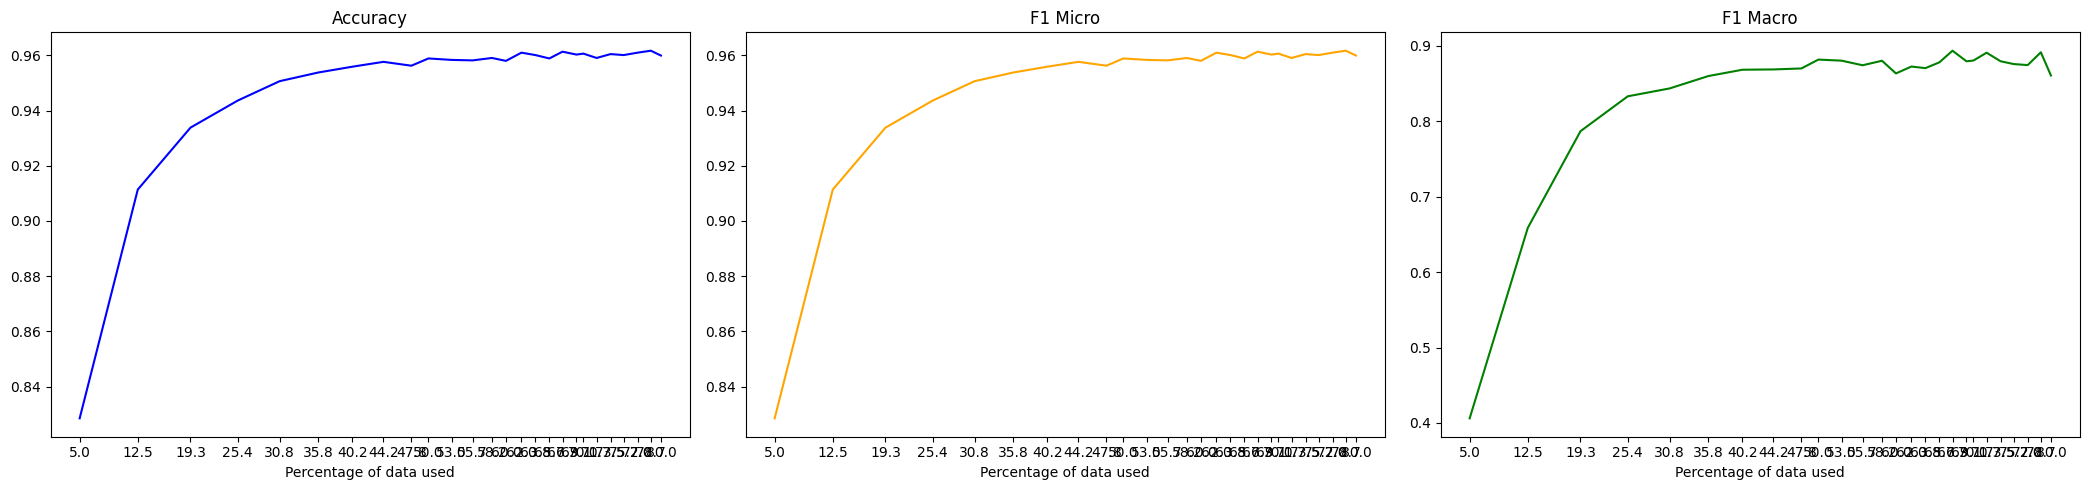

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6072, Accuracy: 0.7955, F1 Micro: 0.8818, F1 Macro: 0.8546
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4916, Accuracy: 0.8016, F1 Micro: 0.8877, F1 Macro: 0.8774
Epoch 3/10, Train Loss: 0.453, Accuracy: 0.8024, F1 Micro: 0.8857, F1 Macro: 0.8609
Epoch 4/10, Train Loss: 0.4515, Accuracy: 0.8021, F1 Micro: 0.8849, F1 Macro: 0.8543
Epoch 5/10, Train Loss: 0.417, Accuracy: 0.8047, F1 Micro: 0.8868, F1 Macro: 0.862
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4402, Accuracy: 0.8092, F1 Micro: 0.8902, F1 Macro: 0.874
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3799, Accuracy: 0.8141, F1 Micro: 0.8937, F1 Macro: 0.8828
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3851, Accuracy: 0.8252, F1 Micro: 0.899, F1 Macro: 0.8873
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3532, Accuracy: 0.8361, F1 Micro: 0.9044, F1 Macro: 0.8918
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5988, Accuracy: 0.6204, F1 Micro: 0.6204, F1 Macro: 0.3829
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5281, Accuracy: 0.6204, F1 Micro: 0.6204, F1 Macro: 0.3829
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4888, Accuracy: 0.6259, F1 Micro: 0.6259, F1 Macro: 0.4027
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3707, Accuracy: 0.6861, F1 Micro: 0.6861, F1 Macro: 0.5752
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3492, Accuracy: 0.7336, F1 Micro: 0.7336, F1 Macro: 0.6917
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2739, Accuracy: 0.7372, F1 Micro: 0.7372, F1 Macro: 0.7005
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3739, Accuracy: 0.7409, F1 Micro: 0.7409, F1 Macro: 0.7103
Epoch 8/10, Train Loss: 0.2974, Accuracy: 0.7281, F1 Micro: 0.7281, F1 Macro: 0.6718
Epoch 9/10, Train Loss: 0.18, Accuracy: 0.7372, F1 Micro: 0.7372, F1 Macro: 0.703
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5369, Accuracy: 0.801, F1 Micro: 0.8895, F1 Macro: 0.885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4557, Accuracy: 0.8064, F1 Micro: 0.8917, F1 Macro: 0.8863
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4405, Accuracy: 0.8247, F1 Micro: 0.9007, F1 Macro: 0.8955
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3935, Accuracy: 0.8448, F1 Micro: 0.9101, F1 Macro: 0.9037
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3461, Accuracy: 0.8606, F1 Micro: 0.918, F1 Macro: 0.9118
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3066, Accuracy: 0.8816, F1 Micro: 0.9297, F1 Macro: 0.9243
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2661, Accuracy: 0.9003, F1 Micro: 0.9403, F1 Macro: 0.9362
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2377, Accuracy: 0.9099, F1 Micro: 0.9457, F1 Macro: 0.9419
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5256, Accuracy: 0.7102, F1 Micro: 0.7102, F1 Macro: 0.4153
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4567, Accuracy: 0.7989, F1 Micro: 0.7989, F1 Macro: 0.7462
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3803, Accuracy: 0.8136, F1 Micro: 0.8136, F1 Macro: 0.7258
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3387, Accuracy: 0.8341, F1 Micro: 0.8341, F1 Macro: 0.7795
Epoch 5/10, Train Loss: 0.2474, Accuracy: 0.8295, F1 Micro: 0.8295, F1 Macro: 0.7639
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1844, Accuracy: 0.8375, F1 Micro: 0.8375, F1 Macro: 0.7782
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2114, Accuracy: 0.8534, F1 Micro: 0.8534, F1 Macro: 0.8054
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1393, Accuracy: 0.8557, F1 Micro: 0.8557, F1 Macro: 0.8107
Epoch 9/10, Train Loss: 0.0898, Accuracy: 0.8534, F1 Micro: 0.8534, F1 Macro: 0.8012
High

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5407, Accuracy: 0.7991, F1 Micro: 0.8828, F1 Macro: 0.8453
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4851, Accuracy: 0.8295, F1 Micro: 0.9011, F1 Macro: 0.8894
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4165, Accuracy: 0.862, F1 Micro: 0.9181, F1 Macro: 0.9065
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3537, Accuracy: 0.8931, F1 Micro: 0.9356, F1 Macro: 0.9279
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2886, Accuracy: 0.9125, F1 Micro: 0.9467, F1 Macro: 0.9404
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2435, Accuracy: 0.9288, F1 Micro: 0.9564, F1 Macro: 0.9521
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2062, Accuracy: 0.9372, F1 Micro: 0.9616, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.186, Accuracy: 0.9384, F1 Micro: 0.9622, F1 Macro: 0.9591
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6224, Accuracy: 0.7899, F1 Micro: 0.7899, F1 Macro: 0.6164
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4298, Accuracy: 0.8476, F1 Micro: 0.8476, F1 Macro: 0.7935
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3255, Accuracy: 0.8507, F1 Micro: 0.8507, F1 Macro: 0.7678
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2084, Accuracy: 0.8702, F1 Micro: 0.8702, F1 Macro: 0.8285
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1746, Accuracy: 0.8764, F1 Micro: 0.8764, F1 Macro: 0.8214
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1191, Accuracy: 0.8919, F1 Micro: 0.8919, F1 Macro: 0.8484
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0937, Accuracy: 0.8929, F1 Micro: 0.8929, F1 Macro: 0.8467
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0475, Accuracy: 0.8939, F1 Micro: 0.8939, F1 Macro: 0.8535
Epoch 9/10, Train Loss: 0.0415, Accuracy: 0.8929, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5375, Accuracy: 0.7859, F1 Micro: 0.8703, F1 Macro: 0.8139
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4776, Accuracy: 0.8436, F1 Micro: 0.9094, F1 Macro: 0.9023
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3988, Accuracy: 0.8988, F1 Micro: 0.9385, F1 Macro: 0.9311
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3039, Accuracy: 0.9198, F1 Micro: 0.9514, F1 Macro: 0.9471
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2505, Accuracy: 0.9354, F1 Micro: 0.9605, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.22, Accuracy: 0.9444, F1 Micro: 0.9659, F1 Macro: 0.9631
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1886, Accuracy: 0.9443, F1 Micro: 0.9659, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1581, Accuracy: 0.9464, F1 Micro: 0.9671, F1 Macro: 0.9649
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6052, Accuracy: 0.8296, F1 Micro: 0.8296, F1 Macro: 0.7543
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4141, Accuracy: 0.8671, F1 Micro: 0.8671, F1 Macro: 0.8049
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2814, Accuracy: 0.9037, F1 Micro: 0.9037, F1 Macro: 0.8671
Epoch 4/10, Train Loss: 0.2026, Accuracy: 0.8935, F1 Micro: 0.8935, F1 Macro: 0.8584
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1064, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8724
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0682, Accuracy: 0.9087, F1 Micro: 0.9087, F1 Macro: 0.8704
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.9108, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5392, Accuracy: 0.8059, F1 Micro: 0.8877, F1 Macro: 0.8651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4796, Accuracy: 0.8745, F1 Micro: 0.9252, F1 Macro: 0.9181
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3713, Accuracy: 0.917, F1 Micro: 0.9496, F1 Macro: 0.9448
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2774, Accuracy: 0.9372, F1 Micro: 0.9613, F1 Macro: 0.9576
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2309, Accuracy: 0.9444, F1 Micro: 0.966, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1987, Accuracy: 0.9483, F1 Micro: 0.9681, F1 Macro: 0.9658
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1705, Accuracy: 0.9521, F1 Micro: 0.9706, F1 Macro: 0.9685
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.15, Accuracy: 0.9536, F1 Micro: 0.9714, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 9/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5449, Accuracy: 0.8517, F1 Micro: 0.8517, F1 Macro: 0.7996
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3839, Accuracy: 0.8821, F1 Micro: 0.8821, F1 Macro: 0.836
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2754, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8852
Epoch 4/10, Train Loss: 0.1764, Accuracy: 0.9037, F1 Micro: 0.9037, F1 Macro: 0.8687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1159, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8854
Epoch 6/10, Train Loss: 0.1083, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8852
Epoch 7/10, Train Loss: 0.0842, Accuracy: 0.9126, F1 Micro: 0.9126, F1 Macro: 0.8819
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8832
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0643, Accuracy: 0.9175, F1 Micro: 0.9175, F1 Macro: 0.889
Epoch 10/10, Train Loss: 0.0446, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5363, Accuracy: 0.813, F1 Micro: 0.8943, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4575, Accuracy: 0.8844, F1 Micro: 0.9308, F1 Macro: 0.9239
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3447, Accuracy: 0.9245, F1 Micro: 0.9537, F1 Macro: 0.9486
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2543, Accuracy: 0.9444, F1 Micro: 0.9659, F1 Macro: 0.9632
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2136, Accuracy: 0.9497, F1 Micro: 0.969, F1 Macro: 0.9662
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1843, Accuracy: 0.9549, F1 Micro: 0.9722, F1 Macro: 0.9696
Epoch 7/10, Train Loss: 0.1635, Accuracy: 0.9549, F1 Micro: 0.9721, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1404, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1198, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4829, Accuracy: 0.8533, F1 Micro: 0.8533, F1 Macro: 0.8085
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3478, Accuracy: 0.8839, F1 Micro: 0.8839, F1 Macro: 0.854
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.22, Accuracy: 0.8877, F1 Micro: 0.8877, F1 Macro: 0.8503
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1661, Accuracy: 0.9044, F1 Micro: 0.9044, F1 Macro: 0.8767
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9025, F1 Micro: 0.9025, F1 Macro: 0.871
Epoch 6/10, Train Loss: 0.1114, Accuracy: 0.9016, F1 Micro: 0.9016, F1 Macro: 0.8709
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0962, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0547, Accuracy: 0.909, F1 Micro: 0.909, F1 Macro: 0.8818
Epoch 9/10, Train Loss: 0.0382, Accuracy: 0.9025, F1 Micro: 0.9025, F1 Macro: 0.8726
Epoch 10/10, Train Loss: 0.0518, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5313, Accuracy: 0.8118, F1 Micro: 0.8944, F1 Macro: 0.889
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4324, Accuracy: 0.9056, F1 Micro: 0.9431, F1 Macro: 0.9378
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3188, Accuracy: 0.9333, F1 Micro: 0.9594, F1 Macro: 0.9563
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2383, Accuracy: 0.9486, F1 Micro: 0.9684, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2025, Accuracy: 0.954, F1 Micro: 0.9716, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.169, Accuracy: 0.9571, F1 Micro: 0.9735, F1 Macro: 0.971
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.143, Accuracy: 0.9578, F1 Micro: 0.9739, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1287, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4774, Accuracy: 0.8672, F1 Micro: 0.8672, F1 Macro: 0.8266
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2941, Accuracy: 0.8887, F1 Micro: 0.8887, F1 Macro: 0.852
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1964, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8778
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1414, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1136, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8841
Epoch 6/10, Train Loss: 0.0839, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8801
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0483, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.8874
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.048, Accuracy: 0.9149, F1 Micro: 0.9149, F1 Macro: 0.89
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.9149, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5243, Accuracy: 0.825, F1 Micro: 0.8989, F1 Macro: 0.8866
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4103, Accuracy: 0.9047, F1 Micro: 0.9428, F1 Macro: 0.9379
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2922, Accuracy: 0.9403, F1 Micro: 0.9634, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2296, Accuracy: 0.9498, F1 Micro: 0.9691, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1897, Accuracy: 0.9563, F1 Micro: 0.973, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1562, Accuracy: 0.9602, F1 Micro: 0.9753, F1 Macro: 0.9728
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1362, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9735
Epoch 8/10, Train Loss: 0.117, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1044, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4419, Accuracy: 0.8596, F1 Micro: 0.8596, F1 Macro: 0.8199
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.266, Accuracy: 0.8873, F1 Micro: 0.8873, F1 Macro: 0.8597
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1863, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8745
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1278, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8822
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0956, Accuracy: 0.9077, F1 Micro: 0.9077, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8855
Epoch 7/10, Train Loss: 0.0605, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8794
Epoch 8/10, Train Loss: 0.0477, Accuracy: 0.9067, F1 Micro: 0.9067, F1 Macro: 0.8782
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8769
Epoch 10/10, Train Loss: 0.0344, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5173, Accuracy: 0.8332, F1 Micro: 0.9041, F1 Macro: 0.8968
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3926, Accuracy: 0.916, F1 Micro: 0.949, F1 Macro: 0.9437
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2788, Accuracy: 0.9401, F1 Micro: 0.9634, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2206, Accuracy: 0.9523, F1 Micro: 0.9706, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1754, Accuracy: 0.9568, F1 Micro: 0.9732, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.152, Accuracy: 0.9595, F1 Micro: 0.9749, F1 Macro: 0.9727
Epoch 7/10, Train Loss: 0.1306, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1145, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.975
Epoch 9/10, Train Loss: 0.0936, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4435, Accuracy: 0.8717, F1 Micro: 0.8717, F1 Macro: 0.8264
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2889, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8689
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1816, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.875
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1459, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1027, Accuracy: 0.9126, F1 Micro: 0.9126, F1 Macro: 0.8863
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0726, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8866
Epoch 7/10, Train Loss: 0.0593, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.882
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.882
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8814
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5163, Accuracy: 0.8233, F1 Micro: 0.9001, F1 Macro: 0.8948
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3837, Accuracy: 0.9179, F1 Micro: 0.9503, F1 Macro: 0.9462
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2736, Accuracy: 0.9453, F1 Micro: 0.9663, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2143, Accuracy: 0.9464, F1 Micro: 0.9671, F1 Macro: 0.9646
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1795, Accuracy: 0.9578, F1 Micro: 0.974, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1512, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1302, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9752
Epoch 8/10, Train Loss: 0.1063, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9744
Epoch 9/10, Train Loss: 0.0939, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4431, Accuracy: 0.8653, F1 Micro: 0.8653, F1 Macro: 0.8198
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2437, Accuracy: 0.9001, F1 Micro: 0.9001, F1 Macro: 0.8689
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1707, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.873
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1246, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8776
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0917, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8849
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0722, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8849
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0511, Accuracy: 0.9148, F1 Micro: 0.9148, F1 Macro: 0.8882
Epoch 8/10, Train Loss: 0.0313, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8852
Epoch 9/10, Train Loss: 0.0369, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8874
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.51, Accuracy: 0.8455, F1 Micro: 0.9107, F1 Macro: 0.9043
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3602, Accuracy: 0.9255, F1 Micro: 0.9547, F1 Macro: 0.9507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.253, Accuracy: 0.9453, F1 Micro: 0.9665, F1 Macro: 0.9642
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2062, Accuracy: 0.9545, F1 Micro: 0.9719, F1 Macro: 0.9694
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1654, Accuracy: 0.9587, F1 Micro: 0.9745, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1431, Accuracy: 0.9611, F1 Micro: 0.9759, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1222, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1006, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9757
Epoch 9/10, Train Loss: 0.0861, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4487, Accuracy: 0.8642, F1 Micro: 0.8642, F1 Macro: 0.8222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.242, Accuracy: 0.8991, F1 Micro: 0.8991, F1 Macro: 0.8681
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1582, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.8856
Epoch 4/10, Train Loss: 0.1154, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8807
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.097, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8863
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0522, Accuracy: 0.9183, F1 Micro: 0.9183, F1 Macro: 0.8932
Epoch 7/10, Train Loss: 0.0574, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Macro: 0.8801
Epoch 8/10, Train Loss: 0.0511, Accuracy: 0.9165, F1 Micro: 0.9165, F1 Macro: 0.8925
Epoch 9/10, Train Loss: 0.046, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.8881
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0392, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4963, Accuracy: 0.8524, F1 Micro: 0.912, F1 Macro: 0.9001
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3434, Accuracy: 0.9241, F1 Micro: 0.9541, F1 Macro: 0.9502
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2518, Accuracy: 0.9451, F1 Micro: 0.9664, F1 Macro: 0.9641
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1962, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1635, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9727
Epoch 6/10, Train Loss: 0.14, Accuracy: 0.9585, F1 Micro: 0.9743, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.115, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1028, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9747
Epoch 9/10, Train Loss: 0.0839, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4348, Accuracy: 0.8561, F1 Micro: 0.8561, F1 Macro: 0.8071
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2648, Accuracy: 0.8873, F1 Micro: 0.8873, F1 Macro: 0.8503
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1675, Accuracy: 0.9019, F1 Micro: 0.9019, F1 Macro: 0.8713
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.126, Accuracy: 0.9074, F1 Micro: 0.9074, F1 Macro: 0.8802
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1041, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0624, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8826
Epoch 7/10, Train Loss: 0.0559, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.882
Epoch 8/10, Train Loss: 0.0467, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8794
Epoch 9/10, Train Loss: 0.0441, Accuracy: 0.9056, F1 Micro: 0.9056, F1 Macro: 0.8758
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4971, Accuracy: 0.8486, F1 Micro: 0.9133, F1 Macro: 0.9089
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3363, Accuracy: 0.9307, F1 Micro: 0.9578, F1 Macro: 0.9546
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2404, Accuracy: 0.9483, F1 Micro: 0.9682, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1939, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1594, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.9721
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1311, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1107, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0992, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.0855, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3905, Accuracy: 0.8657, F1 Micro: 0.8657, F1 Macro: 0.832
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2431, Accuracy: 0.9052, F1 Micro: 0.9052, F1 Macro: 0.8793
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.17, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.8814
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.112, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8862
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0924, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0822, Accuracy: 0.9172, F1 Micro: 0.9172, F1 Macro: 0.8915
Epoch 7/10, Train Loss: 0.0579, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.8904
Epoch 8/10, Train Loss: 0.0392, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8872
Epoch 9/10, Train Loss: 0.0333, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8896
Epoch 10/10, Train Loss: 0.0368, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4903, Accuracy: 0.8536, F1 Micro: 0.9157, F1 Macro: 0.9108
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3357, Accuracy: 0.9345, F1 Micro: 0.9602, F1 Macro: 0.9571
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2348, Accuracy: 0.9495, F1 Micro: 0.969, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1868, Accuracy: 0.9549, F1 Micro: 0.9722, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1565, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1272, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9744
Epoch 7/10, Train Loss: 0.1104, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0936, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0786, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3878, Accuracy: 0.8582, F1 Micro: 0.8582, F1 Macro: 0.8279
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2234, Accuracy: 0.9058, F1 Micro: 0.9058, F1 Macro: 0.8739
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.149, Accuracy: 0.9226, F1 Micro: 0.9226, F1 Macro: 0.8986
Epoch 4/10, Train Loss: 0.1003, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.8937
Epoch 5/10, Train Loss: 0.0843, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.8927
Epoch 6/10, Train Loss: 0.0531, Accuracy: 0.9188, F1 Micro: 0.9188, F1 Macro: 0.8945
Epoch 7/10, Train Loss: 0.0646, Accuracy: 0.9142, F1 Micro: 0.9142, F1 Macro: 0.8878
Epoch 8/10, Train Loss: 0.0353, Accuracy: 0.917, F1 Micro: 0.917, F1 Macro: 0.8894
Epoch 9/10, Train Loss: 0.0236, Accuracy: 0.9179, F1 Micro: 0.9179, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0276, Accuracy: 0.9244, F1 Micro: 0.9244, F1 Macro: 0.8996

Sentiment analysis 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4862, Accuracy: 0.8663, F1 Micro: 0.9217, F1 Macro: 0.9164
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3228, Accuracy: 0.9375, F1 Micro: 0.9618, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.225, Accuracy: 0.9498, F1 Micro: 0.9691, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1765, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.9701
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1457, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1252, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9757
Epoch 7/10, Train Loss: 0.1061, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0907, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0757, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3847, Accuracy: 0.8655, F1 Micro: 0.8655, F1 Macro: 0.8352
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2292, Accuracy: 0.8908, F1 Micro: 0.8908, F1 Macro: 0.8595
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1634, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.885
Epoch 4/10, Train Loss: 0.1129, Accuracy: 0.9007, F1 Micro: 0.9007, F1 Macro: 0.8735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0743, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8832
Epoch 6/10, Train Loss: 0.0659, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8763
Epoch 7/10, Train Loss: 0.0584, Accuracy: 0.9088, F1 Micro: 0.9088, F1 Macro: 0.8822
Epoch 8/10, Train Loss: 0.0464, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8788
Epoch 9/10, Train Loss: 0.0326, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8742
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0315, Accuracy: 0.9143, F1 Micro: 0.9143, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4826, Accuracy: 0.8684, F1 Micro: 0.9232, F1 Macro: 0.9182
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3079, Accuracy: 0.9366, F1 Micro: 0.9614, F1 Macro: 0.9586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2168, Accuracy: 0.9483, F1 Micro: 0.9682, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1771, Accuracy: 0.9561, F1 Micro: 0.9728, F1 Macro: 0.9708
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1493, Accuracy: 0.9613, F1 Micro: 0.9761, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1213, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1078, Accuracy: 0.9648, F1 Micro: 0.9782, F1 Macro: 0.9759
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0896, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Macro: 0.9768
Epoch 9/10, Train Loss: 0.0733, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.38, Accuracy: 0.8736, F1 Micro: 0.8736, F1 Macro: 0.8378
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.219, Accuracy: 0.9009, F1 Micro: 0.9009, F1 Macro: 0.8699
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1438, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1253, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8824
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0804, Accuracy: 0.91, F1 Micro: 0.91, F1 Macro: 0.884
Epoch 6/10, Train Loss: 0.0789, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8785
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.044, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.884
Epoch 8/10, Train Loss: 0.0477, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8771
Epoch 9/10, Train Loss: 0.0328, Accuracy: 0.91, F1 Micro: 0.91, F1 Macro: 0.884
Higher F1 achieved, saving model
Epoch 10/10, Train 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4715, Accuracy: 0.8767, F1 Micro: 0.9276, F1 Macro: 0.9224
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.302, Accuracy: 0.9368, F1 Micro: 0.9615, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2143, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1711, Accuracy: 0.9549, F1 Micro: 0.9722, F1 Macro: 0.9699
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1462, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1172, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9738
Epoch 7/10, Train Loss: 0.1016, Accuracy: 0.9606, F1 Micro: 0.9757, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0876, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0696, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3651, Accuracy: 0.8685, F1 Micro: 0.8685, F1 Macro: 0.8281
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2124, Accuracy: 0.9005, F1 Micro: 0.9005, F1 Macro: 0.8737
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1407, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8861
Epoch 4/10, Train Loss: 0.0999, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8824
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0643, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.8906
Epoch 6/10, Train Loss: 0.0528, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8863
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0442, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.8919
Epoch 8/10, Train Loss: 0.0287, Accuracy: 0.9151, F1 Micro: 0.9151, F1 Macro: 0.8911
Epoch 9/10, Train Loss: 0.0196, Accuracy: 0.9132, F1 Micro: 0.9132, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0222, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4672, Accuracy: 0.88, F1 Micro: 0.9292, F1 Macro: 0.9242
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2914, Accuracy: 0.9411, F1 Micro: 0.9641, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2084, Accuracy: 0.9517, F1 Micro: 0.9702, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.165, Accuracy: 0.9568, F1 Micro: 0.9733, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1405, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9751
Epoch 6/10, Train Loss: 0.114, Accuracy: 0.962, F1 Micro: 0.9765, F1 Macro: 0.9743
Epoch 7/10, Train Loss: 0.0945, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9743
Epoch 8/10, Train Loss: 0.0805, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9749
Epoch 9/10, Train Loss: 0.0697, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.05

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3756, Accuracy: 0.8679, F1 Micro: 0.8679, F1 Macro: 0.819
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2054, Accuracy: 0.9051, F1 Micro: 0.9051, F1 Macro: 0.8742
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1361, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8852
Epoch 4/10, Train Loss: 0.095, Accuracy: 0.906, F1 Micro: 0.906, F1 Macro: 0.8762
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0728, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8889
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0632, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.8957
Epoch 7/10, Train Loss: 0.0535, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.8873
Epoch 8/10, Train Loss: 0.0315, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8873
Epoch 9/10, Train Loss: 0.0422, Accuracy: 0.9191, F1 Micro: 0.9191, F1 Macro: 0.8958
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0258, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4636, Accuracy: 0.88, F1 Micro: 0.9288, F1 Macro: 0.9223
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2851, Accuracy: 0.9405, F1 Micro: 0.9636, F1 Macro: 0.9613
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2, Accuracy: 0.9509, F1 Micro: 0.9699, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1648, Accuracy: 0.9576, F1 Micro: 0.9738, F1 Macro: 0.9717
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1318, Accuracy: 0.9608, F1 Micro: 0.9757, F1 Macro: 0.9736
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1165, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0943, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0775, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.0696, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3709, Accuracy: 0.8596, F1 Micro: 0.8596, F1 Macro: 0.8158
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2095, Accuracy: 0.8757, F1 Micro: 0.8757, F1 Macro: 0.8441
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1586, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8679
Epoch 4/10, Train Loss: 0.1188, Accuracy: 0.8962, F1 Micro: 0.8962, F1 Macro: 0.8667
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0971, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8676
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0755, Accuracy: 0.9025, F1 Micro: 0.9025, F1 Macro: 0.8773
Epoch 7/10, Train Loss: 0.0596, Accuracy: 0.8998, F1 Micro: 0.8998, F1 Macro: 0.8702
Epoch 8/10, Train Loss: 0.0492, Accuracy: 0.898, F1 Micro: 0.898, F1 Macro: 0.8702
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.032, Accuracy: 0.9061, F1 Micro: 0.9061, F1 Macro: 0.8782
Epoch 10/10, Train Loss: 0.0128, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4583, Accuracy: 0.8816, F1 Micro: 0.9299, F1 Macro: 0.924
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.282, Accuracy: 0.9382, F1 Micro: 0.9624, F1 Macro: 0.9601
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1974, Accuracy: 0.9512, F1 Micro: 0.97, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.16, Accuracy: 0.9542, F1 Micro: 0.9718, F1 Macro: 0.9697
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1377, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9747
Epoch 6/10, Train Loss: 0.1089, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0946, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.0763, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0664, Accuracy: 0.9665, F1 Micro: 0.9792, F1 Macro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3675, Accuracy: 0.866, F1 Micro: 0.866, F1 Macro: 0.8179
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2118, Accuracy: 0.9015, F1 Micro: 0.9015, F1 Macro: 0.8774
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1507, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8884
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1098, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8884
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0836, Accuracy: 0.9152, F1 Micro: 0.9152, F1 Macro: 0.8909
Epoch 6/10, Train Loss: 0.0761, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8815
Epoch 7/10, Train Loss: 0.065, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8743
Epoch 8/10, Train Loss: 0.0422, Accuracy: 0.9107, F1 Micro: 0.9107, F1 Macro: 0.8852
Epoch 9/10, Train Loss: 0.0456, Accuracy: 0.9116, F1 Micro: 0.9116, F1 Macro: 0.8879
Epoch 10/10, Train Loss: 0.0267, Accuracy: 0.9107, F1 Micro: 0.9107, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4546, Accuracy: 0.8823, F1 Micro: 0.9303, F1 Macro: 0.9248
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2815, Accuracy: 0.9413, F1 Micro: 0.964, F1 Macro: 0.9612
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2007, Accuracy: 0.9512, F1 Micro: 0.9701, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1604, Accuracy: 0.9559, F1 Micro: 0.9729, F1 Macro: 0.9711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1333, Accuracy: 0.9609, F1 Micro: 0.9759, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1096, Accuracy: 0.9625, F1 Micro: 0.9768, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0918, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0797, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.37, Accuracy: 0.862, F1 Micro: 0.862, F1 Macro: 0.8035
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2053, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8734
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1333, Accuracy: 0.9126, F1 Micro: 0.9126, F1 Macro: 0.8848
Epoch 4/10, Train Loss: 0.1173, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.8835
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0772, Accuracy: 0.9181, F1 Micro: 0.9181, F1 Macro: 0.8926
Epoch 6/10, Train Loss: 0.0569, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8867
Epoch 7/10, Train Loss: 0.0459, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8896
Epoch 8/10, Train Loss: 0.0411, Accuracy: 0.9172, F1 Micro: 0.9172, F1 Macro: 0.8928
Epoch 9/10, Train Loss: 0.023, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.888
Epoch 10/10, Train Loss: 0.0277, Accuracy: 0.9144, F1 Micro: 0.9144, F1 Macro: 0.888

Sentiment analysis accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4489, Accuracy: 0.8872, F1 Micro: 0.9331, F1 Macro: 0.9276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2658, Accuracy: 0.9429, F1 Micro: 0.9651, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.9531, F1 Micro: 0.9711, F1 Macro: 0.9691
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.9585, F1 Micro: 0.9744, F1 Macro: 0.9722
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1272, Accuracy: 0.9623, F1 Micro: 0.9767, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1032, Accuracy: 0.9628, F1 Micro: 0.977, F1 Macro: 0.9749
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0858, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Macro: 0.9762
Epoch 8/10, Train Loss: 0.075, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9759
Epoch 9/10, Train Loss: 0.0637, Accuracy: 0.9655, F1 Micro: 0.9785, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3891, Accuracy: 0.8729, F1 Micro: 0.8729, F1 Macro: 0.8389
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1944, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8793
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1571, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8853
Epoch 4/10, Train Loss: 0.1093, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8838
Epoch 5/10, Train Loss: 0.0909, Accuracy: 0.9086, F1 Micro: 0.9086, F1 Macro: 0.8803
Epoch 6/10, Train Loss: 0.0622, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.057, Accuracy: 0.9177, F1 Micro: 0.9177, F1 Macro: 0.893
Epoch 8/10, Train Loss: 0.0417, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8824
Epoch 9/10, Train Loss: 0.0353, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8853
Epoch 10/10, Train Loss: 0.0266, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8811

Sentiment analysis

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4452, Accuracy: 0.8865, F1 Micro: 0.9329, F1 Macro: 0.9281
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2671, Accuracy: 0.9446, F1 Micro: 0.9661, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1899, Accuracy: 0.95, F1 Micro: 0.9693, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1541, Accuracy: 0.9573, F1 Micro: 0.9736, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.9601, F1 Micro: 0.9753, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1011, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9755
Epoch 7/10, Train Loss: 0.0839, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9746
Epoch 8/10, Train Loss: 0.0691, Accuracy: 0.9639, F1 Micro: 0.9775, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.9663, F1 Micro: 0.9791, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3519, Accuracy: 0.8716, F1 Micro: 0.8716, F1 Macro: 0.8349
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1841, Accuracy: 0.907, F1 Micro: 0.907, F1 Macro: 0.8837
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1351, Accuracy: 0.9153, F1 Micro: 0.9153, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0968, Accuracy: 0.9191, F1 Micro: 0.9191, F1 Macro: 0.8951
Epoch 5/10, Train Loss: 0.0572, Accuracy: 0.9181, F1 Micro: 0.9181, F1 Macro: 0.8933
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0455, Accuracy: 0.92, F1 Micro: 0.92, F1 Macro: 0.8954
Epoch 7/10, Train Loss: 0.0385, Accuracy: 0.9191, F1 Micro: 0.9191, F1 Macro: 0.8958
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0359, Accuracy: 0.9247, F1 Micro: 0.9247, F1 Macro: 0.9025
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0218, Accuracy: 0.9247, F1 Micro: 0.9247, F1 Macro: 0.9019
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4382, Accuracy: 0.8861, F1 Micro: 0.9327, F1 Macro: 0.9279
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.258, Accuracy: 0.9405, F1 Micro: 0.9636, F1 Macro: 0.961
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1888, Accuracy: 0.9521, F1 Micro: 0.9706, F1 Macro: 0.9684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1513, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.122, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.975
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0816, Accuracy: 0.9655, F1 Micro: 0.9786, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.9663, F1 Micro: 0.9791, F1 Macro: 0.9767
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.356, Accuracy: 0.871, F1 Micro: 0.871, F1 Macro: 0.827
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.209, Accuracy: 0.8959, F1 Micro: 0.8959, F1 Macro: 0.8562
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1228, Accuracy: 0.9097, F1 Micro: 0.9097, F1 Macro: 0.8826
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1088, Accuracy: 0.9152, F1 Micro: 0.9152, F1 Macro: 0.8895
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0671, Accuracy: 0.9189, F1 Micro: 0.9189, F1 Macro: 0.8923
Epoch 6/10, Train Loss: 0.0487, Accuracy: 0.9152, F1 Micro: 0.9152, F1 Macro: 0.8869
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0379, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.8947
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0328, Accuracy: 0.9217, F1 Micro: 0.9217, F1 Macro: 0.8976
Epoch 9/10, Train Loss: 0.0249, Accuracy: 0.9198, F1 Micro: 0.9198, F1 Macro: 0.8957
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4279, Accuracy: 0.8931, F1 Micro: 0.9363, F1 Macro: 0.9313
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2516, Accuracy: 0.9455, F1 Micro: 0.9666, F1 Macro: 0.9644
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1824, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.9704
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1438, Accuracy: 0.9557, F1 Micro: 0.9728, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9618, F1 Micro: 0.9764, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0951, Accuracy: 0.9646, F1 Micro: 0.978, F1 Macro: 0.9756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.966, F1 Micro: 0.9789, F1 Macro: 0.9767
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3632, Accuracy: 0.8875, F1 Micro: 0.8875, F1 Macro: 0.8513
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1807, Accuracy: 0.9043, F1 Micro: 0.9043, F1 Macro: 0.8719
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.136, Accuracy: 0.9126, F1 Micro: 0.9126, F1 Macro: 0.8838
Epoch 4/10, Train Loss: 0.095, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8883
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0744, Accuracy: 0.9191, F1 Micro: 0.9191, F1 Macro: 0.8941
Epoch 6/10, Train Loss: 0.0529, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8833
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0435, Accuracy: 0.9219, F1 Micro: 0.9219, F1 Macro: 0.8986
Epoch 8/10, Train Loss: 0.024, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8876
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.9247, F1 Micro: 0.9247, F1 Macro: 0.9021
Epoch 10/10, Train Loss: 0.0173, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4284, Accuracy: 0.888, F1 Micro: 0.9339, F1 Macro: 0.9293
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2482, Accuracy: 0.9427, F1 Micro: 0.965, F1 Macro: 0.9628
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1761, Accuracy: 0.951, F1 Micro: 0.97, F1 Macro: 0.9679
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1433, Accuracy: 0.9547, F1 Micro: 0.9721, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1168, Accuracy: 0.9582, F1 Micro: 0.9742, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0943, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.078, Accuracy: 0.9639, F1 Micro: 0.9776, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.9651, F1 Micro: 0.9784, F1 Macro: 0.9766
Epoch 9/10, Train Loss: 0.0569, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3396, Accuracy: 0.8822, F1 Micro: 0.8822, F1 Macro: 0.8442
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1918, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.876
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1266, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.8897
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0871, Accuracy: 0.919, F1 Micro: 0.919, F1 Macro: 0.8926
Epoch 5/10, Train Loss: 0.0664, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8875
Epoch 6/10, Train Loss: 0.0551, Accuracy: 0.9062, F1 Micro: 0.9062, F1 Macro: 0.8734
Epoch 7/10, Train Loss: 0.0449, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8843
Epoch 8/10, Train Loss: 0.0302, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.8899
Epoch 9/10, Train Loss: 0.0307, Accuracy: 0.9172, F1 Micro: 0.9172, F1 Macro: 0.8902
Epoch 10/10, Train Loss: 0.0198, Accuracy: 0.9163, F1 Micro: 0.9163, F1 Macro: 0.8891

Sentiment analysis 

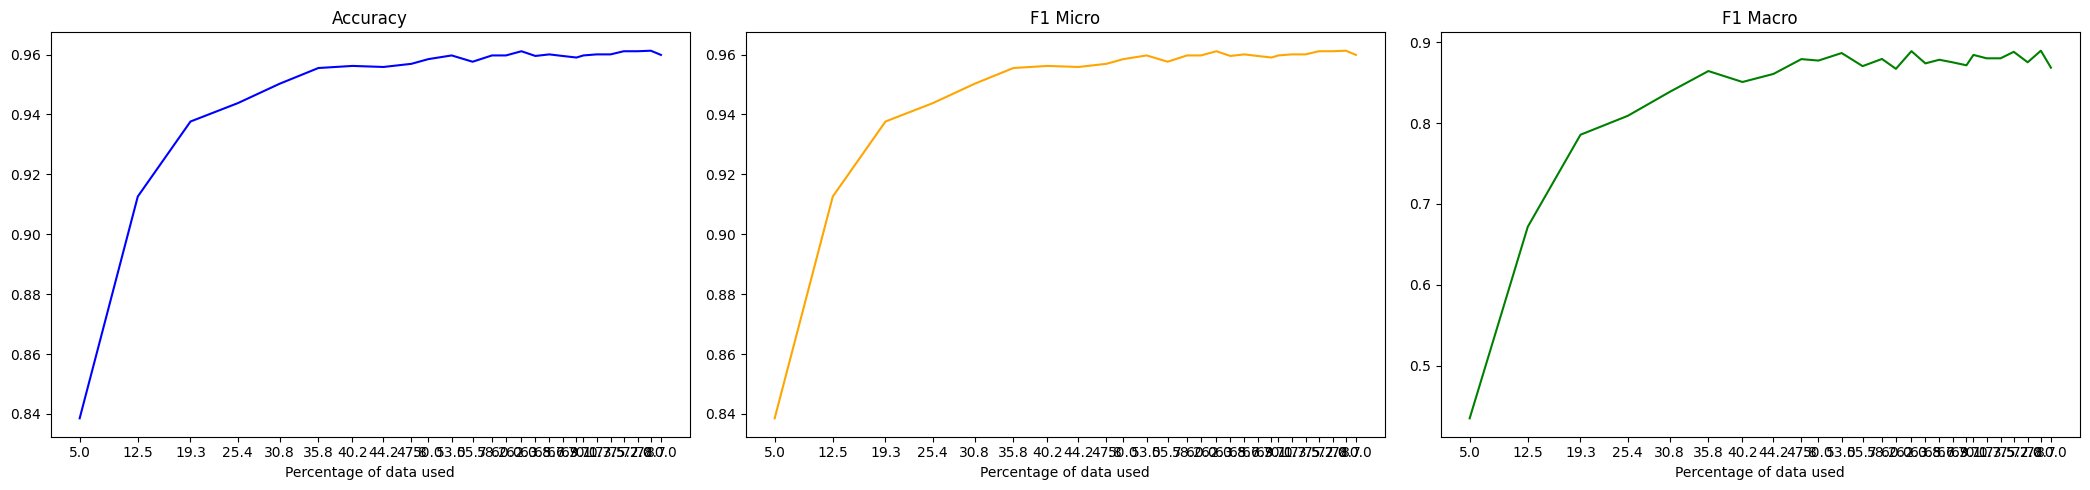

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6222, Accuracy: 0.7984, F1 Micro: 0.8875, F1 Macro: 0.8819
Epoch 2/10, Train Loss: 0.4944, Accuracy: 0.7981, F1 Micro: 0.8873, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4566, Accuracy: 0.7997, F1 Micro: 0.8881, F1 Macro: 0.8821
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4288, Accuracy: 0.8017, F1 Micro: 0.8893, F1 Macro: 0.8836
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4243, Accuracy: 0.804, F1 Micro: 0.8907, F1 Macro: 0.8857
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.4161, Accuracy: 0.8135, F1 Micro: 0.8944, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.4005, Accuracy: 0.8179, F1 Micro: 0.8965, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3794, Accuracy: 0.8247, F1 Micro: 0.9001, F1 Macro: 0.8939
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3213, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5506, Accuracy: 0.6036, F1 Micro: 0.6036, F1 Macro: 0.3764
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4796, Accuracy: 0.6036, F1 Micro: 0.6036, F1 Macro: 0.3764
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4879, Accuracy: 0.6036, F1 Micro: 0.6036, F1 Macro: 0.3764
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4287, Accuracy: 0.6036, F1 Micro: 0.6036, F1 Macro: 0.3764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3515, Accuracy: 0.6036, F1 Micro: 0.6036, F1 Macro: 0.3849
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3279, Accuracy: 0.7, F1 Micro: 0.7, F1 Macro: 0.6242
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2793, Accuracy: 0.7073, F1 Micro: 0.7073, F1 Macro: 0.6432
Epoch 8/10, Train Loss: 0.202, Accuracy: 0.6873, F1 Micro: 0.6873, F1 Macro: 0.6008
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2003, Accuracy: 0.7309, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5682, Accuracy: 0.8, F1 Micro: 0.8884, F1 Macro: 0.883
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4963, Accuracy: 0.8038, F1 Micro: 0.8904, F1 Macro: 0.8848
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4761, Accuracy: 0.8227, F1 Micro: 0.8992, F1 Macro: 0.8941
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.4326, Accuracy: 0.8417, F1 Micro: 0.9084, F1 Macro: 0.9008
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.4007, Accuracy: 0.8533, F1 Micro: 0.9146, F1 Macro: 0.9095
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3496, Accuracy: 0.8727, F1 Micro: 0.9251, F1 Macro: 0.9203
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3011, Accuracy: 0.8852, F1 Micro: 0.9318, F1 Macro: 0.9275
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2608, Accuracy: 0.896, F1 Micro: 0.9381, F1 Macro: 0.935
Higher F1 achieved, saving model
Epoch 9/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5973, Accuracy: 0.6932, F1 Micro: 0.6932, F1 Macro: 0.4094
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4901, Accuracy: 0.8117, F1 Micro: 0.8117, F1 Macro: 0.7607
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.36, Accuracy: 0.814, F1 Micro: 0.814, F1 Macro: 0.7491
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3512, Accuracy: 0.825, F1 Micro: 0.825, F1 Macro: 0.7787
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2726, Accuracy: 0.8394, F1 Micro: 0.8394, F1 Macro: 0.7956
Epoch 6/10, Train Loss: 0.2751, Accuracy: 0.8317, F1 Micro: 0.8317, F1 Macro: 0.7849
Epoch 7/10, Train Loss: 0.2406, Accuracy: 0.8328, F1 Micro: 0.8328, F1 Macro: 0.7735
Epoch 8/10, Train Loss: 0.1748, Accuracy: 0.8339, F1 Micro: 0.8339, F1 Macro: 0.7831
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1325, Accuracy: 0.8394, F1 Micro: 0.8394, F1 Macro: 0.7832
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.556, Accuracy: 0.7937, F1 Micro: 0.88, F1 Macro: 0.843
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4991, Accuracy: 0.8137, F1 Micro: 0.8893, F1 Macro: 0.846
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4635, Accuracy: 0.847, F1 Micro: 0.9095, F1 Macro: 0.8937
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3936, Accuracy: 0.8766, F1 Micro: 0.9258, F1 Macro: 0.9131
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3239, Accuracy: 0.905, F1 Micro: 0.9423, F1 Macro: 0.9349
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2642, Accuracy: 0.9238, F1 Micro: 0.9534, F1 Macro: 0.9475
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2218, Accuracy: 0.9335, F1 Micro: 0.959, F1 Macro: 0.9536
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2019, Accuracy: 0.9406, F1 Micro: 0.9636, F1 Macro: 0.9604
Higher F1 achieved, saving model
Epoch 9/10, Tr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6299, Accuracy: 0.8144, F1 Micro: 0.8144, F1 Macro: 0.7495
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4817, Accuracy: 0.8636, F1 Micro: 0.8636, F1 Macro: 0.807
Epoch 3/10, Train Loss: 0.3723, Accuracy: 0.8554, F1 Micro: 0.8554, F1 Macro: 0.8106
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3012, Accuracy: 0.8738, F1 Micro: 0.8738, F1 Macro: 0.8263
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2157, Accuracy: 0.8872, F1 Micro: 0.8872, F1 Macro: 0.8406
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1513, Accuracy: 0.8933, F1 Micro: 0.8933, F1 Macro: 0.8551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1245, Accuracy: 0.8985, F1 Micro: 0.8985, F1 Macro: 0.8577
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.8995, F1 Micro: 0.8995, F1 Macro: 0.8593
Epoch 9/10, Train Loss: 0.0599, Accuracy: 0.8944, F1 Micro: 0.8944, F1 Macro: 0.8501
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5539, Accuracy: 0.7998, F1 Micro: 0.8828, F1 Macro: 0.8421
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5017, Accuracy: 0.8427, F1 Micro: 0.9081, F1 Macro: 0.8983
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4415, Accuracy: 0.8639, F1 Micro: 0.9201, F1 Macro: 0.9148
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3491, Accuracy: 0.9099, F1 Micro: 0.9454, F1 Macro: 0.938
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2725, Accuracy: 0.9344, F1 Micro: 0.9602, F1 Macro: 0.9574
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2248, Accuracy: 0.9418, F1 Micro: 0.9645, F1 Macro: 0.9617
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1983, Accuracy: 0.9479, F1 Micro: 0.968, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1692, Accuracy: 0.9491, F1 Micro: 0.9688, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5968, Accuracy: 0.841, F1 Micro: 0.841, F1 Macro: 0.7779
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4076, Accuracy: 0.8588, F1 Micro: 0.8588, F1 Macro: 0.7961
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.322, Accuracy: 0.9036, F1 Micro: 0.9036, F1 Macro: 0.8671
Epoch 4/10, Train Loss: 0.2061, Accuracy: 0.9006, F1 Micro: 0.9006, F1 Macro: 0.8666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.149, Accuracy: 0.9135, F1 Micro: 0.9135, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1293, Accuracy: 0.9165, F1 Micro: 0.9165, F1 Macro: 0.8885
Epoch 7/10, Train Loss: 0.0945, Accuracy: 0.9115, F1 Micro: 0.9115, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0802, Accuracy: 0.9175, F1 Micro: 0.9175, F1 Macro: 0.8894
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9105, F1 Micro: 0.9105, F1 Macro: 0.8818
Epoch 10/10, Train Loss: 0.052, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5533, Accuracy: 0.7915, F1 Micro: 0.8775, F1 Macro: 0.8166
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4852, Accuracy: 0.8429, F1 Micro: 0.9069, F1 Macro: 0.8872
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3985, Accuracy: 0.905, F1 Micro: 0.9429, F1 Macro: 0.9381
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2991, Accuracy: 0.9368, F1 Micro: 0.9614, F1 Macro: 0.9584
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2311, Accuracy: 0.9464, F1 Micro: 0.9671, F1 Macro: 0.9645
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1934, Accuracy: 0.9505, F1 Micro: 0.9696, F1 Macro: 0.9671
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1682, Accuracy: 0.9559, F1 Micro: 0.9727, F1 Macro: 0.9699
Epoch 8/10, Train Loss: 0.1418, Accuracy: 0.9556, F1 Micro: 0.9726, F1 Macro: 0.97
Epoch 9/10, Train Loss: 0.1263, Accuracy: 0.9556, F1 Micro: 0.9724, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5523, Accuracy: 0.8168, F1 Micro: 0.8168, F1 Macro: 0.7725
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3822, Accuracy: 0.8565, F1 Micro: 0.8565, F1 Macro: 0.8137
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.264, Accuracy: 0.8727, F1 Micro: 0.8727, F1 Macro: 0.8363
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2016, Accuracy: 0.8791, F1 Micro: 0.8791, F1 Macro: 0.8442
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1298, Accuracy: 0.8809, F1 Micro: 0.8809, F1 Macro: 0.8479
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1051, Accuracy: 0.8827, F1 Micro: 0.8827, F1 Macro: 0.8485
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0863, Accuracy: 0.889, F1 Micro: 0.889, F1 Macro: 0.8581
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.8863, F1 Micro: 0.8863, F1 Macro: 0.8545
Epoch 9/10, Train Loss: 0.0372, Accuracy: 0.8881, F1 Micro: 0.8881, F1 Macro: 0.86
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.544, Accuracy: 0.8068, F1 Micro: 0.8916, F1 Macro: 0.8855
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4709, Accuracy: 0.8549, F1 Micro: 0.9153, F1 Macro: 0.9089
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.367, Accuracy: 0.9217, F1 Micro: 0.9523, F1 Macro: 0.9467
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2681, Accuracy: 0.9446, F1 Micro: 0.966, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2138, Accuracy: 0.9533, F1 Micro: 0.9712, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1854, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.9688
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1541, Accuracy: 0.9587, F1 Micro: 0.9744, F1 Macro: 0.9715
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1334, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.973
Epoch 9/10, Train Loss: 0.1194, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.501, Accuracy: 0.86, F1 Micro: 0.86, F1 Macro: 0.8144
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3281, Accuracy: 0.8849, F1 Micro: 0.8849, F1 Macro: 0.8555
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2341, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8899
Epoch 4/10, Train Loss: 0.1592, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8888
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1193, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8886
Epoch 6/10, Train Loss: 0.085, Accuracy: 0.9118, F1 Micro: 0.9118, F1 Macro: 0.8882
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0994, Accuracy: 0.9166, F1 Micro: 0.9166, F1 Macro: 0.892
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.061, Accuracy: 0.9185, F1 Micro: 0.9185, F1 Macro: 0.8942
Epoch 9/10, Train Loss: 0.0697, Accuracy: 0.9003, F1 Micro: 0.9003, F1 Macro: 0.8668
Epoch 10/10, Train Loss: 0.0349, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5465, Accuracy: 0.8109, F1 Micro: 0.8925, F1 Macro: 0.883
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4595, Accuracy: 0.8814, F1 Micro: 0.9292, F1 Macro: 0.9214
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3338, Accuracy: 0.9342, F1 Micro: 0.9595, F1 Macro: 0.9547
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2533, Accuracy: 0.9493, F1 Micro: 0.9686, F1 Macro: 0.965
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2077, Accuracy: 0.9556, F1 Micro: 0.9725, F1 Macro: 0.9696
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1676, Accuracy: 0.9561, F1 Micro: 0.9729, F1 Macro: 0.9702
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1454, Accuracy: 0.9599, F1 Micro: 0.9752, F1 Macro: 0.972
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1248, Accuracy: 0.9613, F1 Micro: 0.976, F1 Macro: 0.9734
Epoch 9/10, Train Loss: 0.1053, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5022, Accuracy: 0.8467, F1 Micro: 0.8467, F1 Macro: 0.7921
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2932, Accuracy: 0.8947, F1 Micro: 0.8947, F1 Macro: 0.8643
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2235, Accuracy: 0.9003, F1 Micro: 0.9003, F1 Macro: 0.8681
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.147, Accuracy: 0.9021, F1 Micro: 0.9021, F1 Macro: 0.876
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1188, Accuracy: 0.904, F1 Micro: 0.904, F1 Macro: 0.8781
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.903, F1 Micro: 0.903, F1 Macro: 0.8725
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0673, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.8767
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0486, Accuracy: 0.9049, F1 Micro: 0.9049, F1 Macro: 0.877
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0453, Accuracy: 0.9067, F1 Micro: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5334, Accuracy: 0.8186, F1 Micro: 0.8936, F1 Macro: 0.8704
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.437, Accuracy: 0.8962, F1 Micro: 0.9374, F1 Macro: 0.9298
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3011, Accuracy: 0.9398, F1 Micro: 0.9633, F1 Macro: 0.9602
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2358, Accuracy: 0.9519, F1 Micro: 0.9702, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1951, Accuracy: 0.9564, F1 Micro: 0.9732, F1 Macro: 0.9706
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1638, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.141, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1147, Accuracy: 0.9634, F1 Micro: 0.9772, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 9/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.464, Accuracy: 0.8493, F1 Micro: 0.8493, F1 Macro: 0.8101
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.282, Accuracy: 0.8952, F1 Micro: 0.8952, F1 Macro: 0.8626
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2227, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.8806
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1494, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8883
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1251, Accuracy: 0.9154, F1 Micro: 0.9154, F1 Macro: 0.8902
Epoch 6/10, Train Loss: 0.0871, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.8875
Epoch 7/10, Train Loss: 0.0731, Accuracy: 0.9099, F1 Micro: 0.9099, F1 Macro: 0.8843
Epoch 8/10, Train Loss: 0.0602, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.8877
Epoch 9/10, Train Loss: 0.051, Accuracy: 0.9145, F1 Micro: 0.9145, F1 Macro: 0.8901
Epoch 10/10, Train Loss: 0.0333, Accuracy: 0.9081, F1 Micro: 0.9081, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5254, Accuracy: 0.8075, F1 Micro: 0.8926, F1 Macro: 0.8879
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.419, Accuracy: 0.903, F1 Micro: 0.9419, F1 Macro: 0.9364
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.298, Accuracy: 0.9444, F1 Micro: 0.9659, F1 Macro: 0.9627
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2246, Accuracy: 0.9528, F1 Micro: 0.9709, F1 Macro: 0.9681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1873, Accuracy: 0.9559, F1 Micro: 0.9729, F1 Macro: 0.9703
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1588, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.9729
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1324, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9748
Epoch 8/10, Train Loss: 0.1151, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0965, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4468, Accuracy: 0.8537, F1 Micro: 0.8537, F1 Macro: 0.802
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2574, Accuracy: 0.8889, F1 Micro: 0.8889, F1 Macro: 0.85
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1994, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8733
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.126, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1007, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8832
Epoch 6/10, Train Loss: 0.0691, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8827
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0588, Accuracy: 0.9102, F1 Micro: 0.9102, F1 Macro: 0.8821
Epoch 8/10, Train Loss: 0.0492, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8767
Epoch 9/10, Train Loss: 0.0331, Accuracy: 0.9046, F1 Micro: 0.9046, F1 Macro: 0.872
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5276, Accuracy: 0.8273, F1 Micro: 0.9019, F1 Macro: 0.8965
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4052, Accuracy: 0.9193, F1 Micro: 0.9507, F1 Macro: 0.9455
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.278, Accuracy: 0.9455, F1 Micro: 0.9665, F1 Macro: 0.9636
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2169, Accuracy: 0.9514, F1 Micro: 0.9701, F1 Macro: 0.9676
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1787, Accuracy: 0.9554, F1 Micro: 0.9724, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1502, Accuracy: 0.9601, F1 Micro: 0.9752, F1 Macro: 0.9723
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1275, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1097, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4347, Accuracy: 0.866, F1 Micro: 0.866, F1 Macro: 0.8247
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2674, Accuracy: 0.8937, F1 Micro: 0.8937, F1 Macro: 0.8593
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.18, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8841
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1384, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.882
Epoch 5/10, Train Loss: 0.0979, Accuracy: 0.903, F1 Micro: 0.903, F1 Macro: 0.8734
Epoch 6/10, Train Loss: 0.0827, Accuracy: 0.9076, F1 Micro: 0.9076, F1 Macro: 0.8784
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0549, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8833
Epoch 8/10, Train Loss: 0.0465, Accuracy: 0.9039, F1 Micro: 0.9039, F1 Macro: 0.8761
Epoch 9/10, Train Loss: 0.0467, Accuracy: 0.9039, F1 Micro: 0.9039, F1 Macro: 0.8756
Epoch 10/10, Train Loss: 0.0255, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5125, Accuracy: 0.8403, F1 Micro: 0.9083, F1 Macro: 0.9027
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3795, Accuracy: 0.93, F1 Micro: 0.9574, F1 Macro: 0.9534
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.262, Accuracy: 0.9451, F1 Micro: 0.9664, F1 Macro: 0.9639
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2061, Accuracy: 0.9547, F1 Micro: 0.972, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1627, Accuracy: 0.9606, F1 Micro: 0.9756, F1 Macro: 0.9732
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1422, Accuracy: 0.9622, F1 Micro: 0.9765, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1187, Accuracy: 0.9634, F1 Micro: 0.9773, F1 Macro: 0.9753
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.104, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9761
Epoch 9/10, Train Loss: 0.0875, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4087, Accuracy: 0.8471, F1 Micro: 0.8471, F1 Macro: 0.7977
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2467, Accuracy: 0.8851, F1 Micro: 0.8851, F1 Macro: 0.8472
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.179, Accuracy: 0.895, F1 Micro: 0.895, F1 Macro: 0.8619
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1285, Accuracy: 0.9059, F1 Micro: 0.9059, F1 Macro: 0.8787
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.09, Accuracy: 0.9113, F1 Micro: 0.9113, F1 Macro: 0.8865
Epoch 6/10, Train Loss: 0.0841, Accuracy: 0.9068, F1 Micro: 0.9068, F1 Macro: 0.8787
Epoch 7/10, Train Loss: 0.0658, Accuracy: 0.9095, F1 Micro: 0.9095, F1 Macro: 0.8836
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.905, F1 Micro: 0.905, F1 Macro: 0.8805
Epoch 9/10, Train Loss: 0.0299, Accuracy: 0.9104, F1 Micro: 0.9104, F1 Macro: 0.8831
Epoch 10/10, Train Loss: 0.0292, Accuracy: 0.9041, F1 Micro: 0.9041, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5075, Accuracy: 0.8333, F1 Micro: 0.9039, F1 Macro: 0.8961
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3727, Accuracy: 0.922, F1 Micro: 0.9527, F1 Macro: 0.9486
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2504, Accuracy: 0.9474, F1 Micro: 0.9677, F1 Macro: 0.9653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1896, Accuracy: 0.958, F1 Micro: 0.9741, F1 Macro: 0.9714
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1649, Accuracy: 0.9609, F1 Micro: 0.9757, F1 Macro: 0.9731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1371, Accuracy: 0.9625, F1 Micro: 0.9767, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1147, Accuracy: 0.9628, F1 Micro: 0.9769, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0997, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 9/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3946, Accuracy: 0.8606, F1 Micro: 0.8606, F1 Macro: 0.8125
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2387, Accuracy: 0.8899, F1 Micro: 0.8899, F1 Macro: 0.8523
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1726, Accuracy: 0.9009, F1 Micro: 0.9009, F1 Macro: 0.8705
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1188, Accuracy: 0.9128, F1 Micro: 0.9128, F1 Macro: 0.8846
Epoch 5/10, Train Loss: 0.1007, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Macro: 0.8812
Epoch 6/10, Train Loss: 0.058, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.037, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.8873
Epoch 8/10, Train Loss: 0.0396, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8702
Epoch 9/10, Train Loss: 0.0281, Accuracy: 0.9055, F1 Micro: 0.9055, F1 Macro: 0.8755
Epoch 10/10, Train Loss: 0.0319, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5037, Accuracy: 0.829, F1 Micro: 0.9033, F1 Macro: 0.8986
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.354, Accuracy: 0.9328, F1 Micro: 0.959, F1 Macro: 0.9558
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2379, Accuracy: 0.9458, F1 Micro: 0.9667, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1941, Accuracy: 0.9569, F1 Micro: 0.9734, F1 Macro: 0.9712
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1581, Accuracy: 0.9608, F1 Micro: 0.9758, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1315, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Macro: 0.9743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1142, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9755
Epoch 8/10, Train Loss: 0.0966, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9761
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0819, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4123, Accuracy: 0.8609, F1 Micro: 0.8609, F1 Macro: 0.8069
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.252, Accuracy: 0.8878, F1 Micro: 0.8878, F1 Macro: 0.8452
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1519, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8779
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1181, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8847
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0668, Accuracy: 0.9221, F1 Micro: 0.9221, F1 Macro: 0.8984
Epoch 6/10, Train Loss: 0.07, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8754
Epoch 7/10, Train Loss: 0.0604, Accuracy: 0.9174, F1 Micro: 0.9174, F1 Macro: 0.891
Epoch 8/10, Train Loss: 0.0465, Accuracy: 0.9174, F1 Micro: 0.9174, F1 Macro: 0.8899
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0204, Accuracy: 0.9221, F1 Micro: 0.9221, F1 Macro: 0.8972
Epoch 10/10, Train Loss: 0.016, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4909, Accuracy: 0.8457, F1 Micro: 0.9113, F1 Macro: 0.9073
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3353, Accuracy: 0.9377, F1 Micro: 0.962, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2316, Accuracy: 0.9502, F1 Micro: 0.9694, F1 Macro: 0.967
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.183, Accuracy: 0.9547, F1 Micro: 0.9721, F1 Macro: 0.9695
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1537, Accuracy: 0.9615, F1 Micro: 0.976, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1256, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9746
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1101, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9756
Epoch 8/10, Train Loss: 0.0922, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9753
Epoch 9/10, Train Loss: 0.0782, Accuracy: 0.9639, F1 Micro: 0.9775, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3819, Accuracy: 0.8655, F1 Micro: 0.8655, F1 Macro: 0.8252
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2309, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8761
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1483, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8829
Epoch 4/10, Train Loss: 0.1186, Accuracy: 0.9082, F1 Micro: 0.9082, F1 Macro: 0.8839
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0916, Accuracy: 0.9127, F1 Micro: 0.9127, F1 Macro: 0.8863
Epoch 6/10, Train Loss: 0.0609, Accuracy: 0.9109, F1 Micro: 0.9109, F1 Macro: 0.886
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0506, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.8936
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.9064, F1 Micro: 0.9064, F1 Macro: 0.8823
Epoch 9/10, Train Loss: 0.0324, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8884
Epoch 10/10, Train Loss: 0.0311, Accuracy: 0.91, F1 Micro: 0.91, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4959, Accuracy: 0.8519, F1 Micro: 0.9145, F1 Macro: 0.9095
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3357, Accuracy: 0.933, F1 Micro: 0.9592, F1 Macro: 0.9562
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2282, Accuracy: 0.9484, F1 Micro: 0.9683, F1 Macro: 0.9655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1795, Accuracy: 0.9566, F1 Micro: 0.9732, F1 Macro: 0.9707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.15, Accuracy: 0.9613, F1 Micro: 0.9761, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.124, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9754
Epoch 7/10, Train Loss: 0.1086, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9754
Epoch 8/10, Train Loss: 0.0889, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9751
Epoch 9/10, Train Loss: 0.0778, Accuracy: 0.963, F1 Micro: 0.9771, F1 Macro: 0.9753
Higher F1 achieved, savin

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3893, Accuracy: 0.8661, F1 Micro: 0.8661, F1 Macro: 0.8248
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2344, Accuracy: 0.892, F1 Micro: 0.892, F1 Macro: 0.8522
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1648, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8844
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1067, Accuracy: 0.9169, F1 Micro: 0.9169, F1 Macro: 0.8901
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0838, Accuracy: 0.9234, F1 Micro: 0.9234, F1 Macro: 0.8997
Epoch 6/10, Train Loss: 0.0638, Accuracy: 0.916, F1 Micro: 0.916, F1 Macro: 0.8905
Epoch 7/10, Train Loss: 0.0665, Accuracy: 0.9197, F1 Micro: 0.9197, F1 Macro: 0.8931
Epoch 8/10, Train Loss: 0.0348, Accuracy: 0.9224, F1 Micro: 0.9224, F1 Macro: 0.8979
Epoch 9/10, Train Loss: 0.0472, Accuracy: 0.9114, F1 Micro: 0.9114, F1 Macro: 0.8825
Epoch 10/10, Train Loss: 0.048, Accuracy: 0.9224, F1 Micro: 0.9224, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4868, Accuracy: 0.8491, F1 Micro: 0.9126, F1 Macro: 0.9058
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3216, Accuracy: 0.9368, F1 Micro: 0.9615, F1 Macro: 0.9588
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2185, Accuracy: 0.9516, F1 Micro: 0.9702, F1 Macro: 0.9678
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1769, Accuracy: 0.9604, F1 Micro: 0.9754, F1 Macro: 0.9726
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1469, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.121, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1008, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9747
Epoch 8/10, Train Loss: 0.0884, Accuracy: 0.9627, F1 Micro: 0.9768, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0755, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3692, Accuracy: 0.8745, F1 Micro: 0.8745, F1 Macro: 0.8304
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2134, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Macro: 0.8782
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1592, Accuracy: 0.9075, F1 Micro: 0.9075, F1 Macro: 0.8843
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0892, Accuracy: 0.9112, F1 Micro: 0.9112, F1 Macro: 0.8868
Epoch 5/10, Train Loss: 0.0634, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8804
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0683, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.8978
Epoch 7/10, Train Loss: 0.0485, Accuracy: 0.9139, F1 Micro: 0.9139, F1 Macro: 0.892
Epoch 8/10, Train Loss: 0.0401, Accuracy: 0.9185, F1 Micro: 0.9185, F1 Macro: 0.8965
Epoch 9/10, Train Loss: 0.0251, Accuracy: 0.913, F1 Micro: 0.913, F1 Macro: 0.8863
Epoch 10/10, Train Loss: 0.0257, Accuracy: 0.9185, F1 Micro: 0.9185, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.482, Accuracy: 0.8547, F1 Micro: 0.9153, F1 Macro: 0.9084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.314, Accuracy: 0.9392, F1 Micro: 0.9629, F1 Macro: 0.9605
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2178, Accuracy: 0.9484, F1 Micro: 0.9683, F1 Macro: 0.9656
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1721, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9735
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.144, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.9739
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1187, Accuracy: 0.9653, F1 Micro: 0.9785, F1 Macro: 0.9764
Epoch 7/10, Train Loss: 0.1017, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9751
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0741, Accuracy: 0.966, F1 Micro: 0.9788, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3712, Accuracy: 0.8586, F1 Micro: 0.8586, F1 Macro: 0.812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2123, Accuracy: 0.8966, F1 Micro: 0.8966, F1 Macro: 0.8684
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1448, Accuracy: 0.903, F1 Micro: 0.903, F1 Macro: 0.8755
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1156, Accuracy: 0.9066, F1 Micro: 0.9066, F1 Macro: 0.8786
Epoch 5/10, Train Loss: 0.0807, Accuracy: 0.8994, F1 Micro: 0.8994, F1 Macro: 0.8717
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0696, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8828
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0606, Accuracy: 0.9093, F1 Micro: 0.9093, F1 Macro: 0.8817
Epoch 8/10, Train Loss: 0.0385, Accuracy: 0.9075, F1 Micro: 0.9075, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0302, Accuracy: 0.9157, F1 Micro: 0.9157, F1 Macro: 0.8911
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4799, Accuracy: 0.8561, F1 Micro: 0.9162, F1 Macro: 0.9097
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3086, Accuracy: 0.9406, F1 Micro: 0.9636, F1 Macro: 0.9609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2156, Accuracy: 0.9484, F1 Micro: 0.9684, F1 Macro: 0.966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1714, Accuracy: 0.958, F1 Micro: 0.9741, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1435, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9744
Epoch 6/10, Train Loss: 0.1187, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9745
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0994, Accuracy: 0.9653, F1 Micro: 0.9784, F1 Macro: 0.9761
Epoch 8/10, Train Loss: 0.0858, Accuracy: 0.9637, F1 Micro: 0.9775, F1 Macro: 0.9752
Epoch 9/10, Train Loss: 0.0708, Accuracy: 0.9651, F1 Micro: 0.9783, F1 Macro: 0.9762
Epoch 10/10, Train Los

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3746, Accuracy: 0.865, F1 Micro: 0.865, F1 Macro: 0.8136
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2115, Accuracy: 0.9017, F1 Micro: 0.9017, F1 Macro: 0.8724
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1489, Accuracy: 0.9054, F1 Micro: 0.9054, F1 Macro: 0.8796
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.119, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8817
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0865, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.8891
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9091, F1 Micro: 0.9091, F1 Macro: 0.8817
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0534, Accuracy: 0.9137, F1 Micro: 0.9137, F1 Macro: 0.887
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0462, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.8886
Epoch 9/10, Train Loss: 0.0385, Accuracy: 0.91, F1 Micro: 0.91, F1 Macro: 0.8836
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4712, Accuracy: 0.8628, F1 Micro: 0.9196, F1 Macro: 0.9133
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2916, Accuracy: 0.9417, F1 Micro: 0.9642, F1 Macro: 0.9614
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2066, Accuracy: 0.9486, F1 Micro: 0.9684, F1 Macro: 0.9659
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1604, Accuracy: 0.9589, F1 Micro: 0.9747, F1 Macro: 0.9725
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1353, Accuracy: 0.9602, F1 Micro: 0.9754, F1 Macro: 0.973
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1153, Accuracy: 0.9609, F1 Micro: 0.9759, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.9756
Epoch 9/10, Train Loss: 0.0694, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3684, Accuracy: 0.8447, F1 Micro: 0.8447, F1 Macro: 0.8069
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2282, Accuracy: 0.8941, F1 Micro: 0.8941, F1 Macro: 0.8622
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1588, Accuracy: 0.8968, F1 Micro: 0.8968, F1 Macro: 0.864
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1181, Accuracy: 0.9013, F1 Micro: 0.9013, F1 Macro: 0.8709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0754, Accuracy: 0.9013, F1 Micro: 0.9013, F1 Macro: 0.8726
Epoch 6/10, Train Loss: 0.0757, Accuracy: 0.9004, F1 Micro: 0.9004, F1 Macro: 0.8711
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.064, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8738
Epoch 8/10, Train Loss: 0.0489, Accuracy: 0.8986, F1 Micro: 0.8986, F1 Macro: 0.8654
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0432, Accuracy: 0.9031, F1 Micro: 0.9031, F1 Macro: 0.8768
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.467, Accuracy: 0.8618, F1 Micro: 0.9189, F1 Macro: 0.9125
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2902, Accuracy: 0.938, F1 Micro: 0.9621, F1 Macro: 0.9589
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9666
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1649, Accuracy: 0.9552, F1 Micro: 0.9724, F1 Macro: 0.9698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1356, Accuracy: 0.9623, F1 Micro: 0.9766, F1 Macro: 0.974
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.111, Accuracy: 0.9635, F1 Micro: 0.9773, F1 Macro: 0.9751
Epoch 7/10, Train Loss: 0.0975, Accuracy: 0.9618, F1 Micro: 0.9763, F1 Macro: 0.9741
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.08, Accuracy: 0.9639, F1 Micro: 0.9775, F1 Macro: 0.9751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3757, Accuracy: 0.8598, F1 Micro: 0.8598, F1 Macro: 0.8205
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2186, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.873
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1606, Accuracy: 0.9129, F1 Micro: 0.9129, F1 Macro: 0.8863
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1102, Accuracy: 0.9138, F1 Micro: 0.9138, F1 Macro: 0.8903
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0796, Accuracy: 0.9221, F1 Micro: 0.9221, F1 Macro: 0.898
Epoch 6/10, Train Loss: 0.0583, Accuracy: 0.9111, F1 Micro: 0.9111, F1 Macro: 0.8879
Epoch 7/10, Train Loss: 0.0595, Accuracy: 0.9203, F1 Micro: 0.9203, F1 Macro: 0.8963
Epoch 8/10, Train Loss: 0.0454, Accuracy: 0.9175, F1 Micro: 0.9175, F1 Macro: 0.8929
Epoch 9/10, Train Loss: 0.0311, Accuracy: 0.9212, F1 Micro: 0.9212, F1 Macro: 0.8992
Epoch 10/10, Train Loss: 0.0262, Accuracy: 0.9184, F1 Micro: 0.9184, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4614, Accuracy: 0.8632, F1 Micro: 0.9203, F1 Macro: 0.916
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2864, Accuracy: 0.9389, F1 Micro: 0.9626, F1 Macro: 0.9603
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2079, Accuracy: 0.9493, F1 Micro: 0.9689, F1 Macro: 0.9668
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1559, Accuracy: 0.9583, F1 Micro: 0.9742, F1 Macro: 0.9716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1337, Accuracy: 0.9597, F1 Micro: 0.975, F1 Macro: 0.9718
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1078, Accuracy: 0.9622, F1 Micro: 0.9766, F1 Macro: 0.9744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0949, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.08, Accuracy: 0.9644, F1 Micro: 0.9779, F1 Macro: 0.9758
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0647, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3708, Accuracy: 0.857, F1 Micro: 0.857, F1 Macro: 0.7987
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2096, Accuracy: 0.8944, F1 Micro: 0.8944, F1 Macro: 0.8606
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.138, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8747
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0997, Accuracy: 0.9071, F1 Micro: 0.9071, F1 Macro: 0.8772
Epoch 5/10, Train Loss: 0.0733, Accuracy: 0.9035, F1 Micro: 0.9035, F1 Macro: 0.8724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0634, Accuracy: 0.908, F1 Micro: 0.908, F1 Macro: 0.881
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0612, Accuracy: 0.9089, F1 Micro: 0.9089, F1 Macro: 0.881
Epoch 8/10, Train Loss: 0.034, Accuracy: 0.9053, F1 Micro: 0.9053, F1 Macro: 0.8754
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.038, Accuracy: 0.9098, F1 Micro: 0.9098, F1 Macro: 0.882
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4637, Accuracy: 0.8752, F1 Micro: 0.9259, F1 Macro: 0.9188
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2801, Accuracy: 0.9446, F1 Micro: 0.966, F1 Macro: 0.9634
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1988, Accuracy: 0.9526, F1 Micro: 0.9709, F1 Macro: 0.9687
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1545, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9734
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1295, Accuracy: 0.9609, F1 Micro: 0.9758, F1 Macro: 0.9733
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1102, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.9747
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0938, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9756
Epoch 8/10, Train Loss: 0.077, Accuracy: 0.9589, F1 Micro: 0.9746, F1 Macro: 0.9726
Epoch 9/10, Train Loss: 0.0661, Accuracy: 0.9632, F1 Micro: 0.9771, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3654, Accuracy: 0.8699, F1 Micro: 0.8699, F1 Macro: 0.8301
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2125, Accuracy: 0.8981, F1 Micro: 0.8981, F1 Macro: 0.8677
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1464, Accuracy: 0.9026, F1 Micro: 0.9026, F1 Macro: 0.8725
Epoch 4/10, Train Loss: 0.1183, Accuracy: 0.8999, F1 Micro: 0.8999, F1 Macro: 0.87
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0917, Accuracy: 0.9045, F1 Micro: 0.9045, F1 Macro: 0.8755
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0597, Accuracy: 0.9136, F1 Micro: 0.9136, F1 Macro: 0.8879
Epoch 7/10, Train Loss: 0.0499, Accuracy: 0.9117, F1 Micro: 0.9117, F1 Macro: 0.8845
Epoch 8/10, Train Loss: 0.0454, Accuracy: 0.9126, F1 Micro: 0.9126, F1 Macro: 0.8863
Epoch 9/10, Train Loss: 0.0446, Accuracy: 0.9081, F1 Micro: 0.9081, F1 Macro: 0.8819
Epoch 10/10, Train Loss: 0.0338, Accuracy: 0.9072, F1 Micro: 0.9072, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4532, Accuracy: 0.8733, F1 Micro: 0.9251, F1 Macro: 0.9185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.268, Accuracy: 0.9418, F1 Micro: 0.9645, F1 Macro: 0.9622
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1874, Accuracy: 0.9512, F1 Micro: 0.9701, F1 Macro: 0.968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.153, Accuracy: 0.9575, F1 Micro: 0.9738, F1 Macro: 0.9719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1274, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9757
Epoch 6/10, Train Loss: 0.1028, Accuracy: 0.963, F1 Micro: 0.977, F1 Macro: 0.9747
Epoch 7/10, Train Loss: 0.0885, Accuracy: 0.9616, F1 Micro: 0.9762, F1 Macro: 0.9737
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.9648, F1 Micro: 0.9781, F1 Macro: 0.976
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0633, Accuracy: 0.9649, F1 Micro: 0.9782, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3366, Accuracy: 0.8678, F1 Micro: 0.8678, F1 Macro: 0.8306
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2056, Accuracy: 0.8966, F1 Micro: 0.8966, F1 Macro: 0.8657
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.145, Accuracy: 0.9011, F1 Micro: 0.9011, F1 Macro: 0.869
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1198, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8795
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0912, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8844
Epoch 6/10, Train Loss: 0.0655, Accuracy: 0.9065, F1 Micro: 0.9065, F1 Macro: 0.8784
Epoch 7/10, Train Loss: 0.0577, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8794
Epoch 8/10, Train Loss: 0.039, Accuracy: 0.9047, F1 Micro: 0.9047, F1 Macro: 0.8753
Epoch 9/10, Train Loss: 0.0324, Accuracy: 0.9092, F1 Micro: 0.9092, F1 Macro: 0.8802
Epoch 10/10, Train Loss: 0.0283, Accuracy: 0.9038, F1 Micro: 0.9038, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4475, Accuracy: 0.8771, F1 Micro: 0.9276, F1 Macro: 0.923
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2649, Accuracy: 0.9425, F1 Micro: 0.9649, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1866, Accuracy: 0.9493, F1 Micro: 0.9687, F1 Macro: 0.9661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1499, Accuracy: 0.9564, F1 Micro: 0.9731, F1 Macro: 0.9709
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1237, Accuracy: 0.9615, F1 Micro: 0.9761, F1 Macro: 0.9738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1015, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9759
Epoch 7/10, Train Loss: 0.0868, Accuracy: 0.9641, F1 Micro: 0.9776, F1 Macro: 0.9753
Epoch 8/10, Train Loss: 0.0747, Accuracy: 0.962, F1 Micro: 0.9764, F1 Macro: 0.9742
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.9635, F1 Micro: 0.9774, F1 Macro: 0.9751
Higher F1 achieved, sa

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3421, Accuracy: 0.8638, F1 Micro: 0.8638, F1 Macro: 0.8252
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2155, Accuracy: 0.8983, F1 Micro: 0.8983, F1 Macro: 0.8659
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1351, Accuracy: 0.9028, F1 Micro: 0.9028, F1 Macro: 0.8702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1057, Accuracy: 0.9101, F1 Micro: 0.9101, F1 Macro: 0.8832
Epoch 5/10, Train Loss: 0.0637, Accuracy: 0.9083, F1 Micro: 0.9083, F1 Macro: 0.8811
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0494, Accuracy: 0.9119, F1 Micro: 0.9119, F1 Macro: 0.8829
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0369, Accuracy: 0.9173, F1 Micro: 0.9173, F1 Macro: 0.8922
Epoch 8/10, Train Loss: 0.0361, Accuracy: 0.911, F1 Micro: 0.911, F1 Macro: 0.8837
Epoch 9/10, Train Loss: 0.0222, Accuracy: 0.9146, F1 Micro: 0.9146, F1 Macro: 0.8872
Epoch 10/10, Train Loss: 0.0335, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4438, Accuracy: 0.8915, F1 Micro: 0.9356, F1 Macro: 0.9309
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2576, Accuracy: 0.9431, F1 Micro: 0.9651, F1 Macro: 0.9629
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1813, Accuracy: 0.9498, F1 Micro: 0.9691, F1 Macro: 0.9667
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1391, Accuracy: 0.9576, F1 Micro: 0.9739, F1 Macro: 0.9713
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.9594, F1 Micro: 0.9749, F1 Macro: 0.9724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0992, Accuracy: 0.9663, F1 Micro: 0.9791, F1 Macro: 0.9774
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9759
Epoch 8/10, Train Loss: 0.0688, Accuracy: 0.9661, F1 Micro: 0.9789, F1 Macro: 0.9769
Epoch 9/10, Train Loss: 0.0582, Accuracy: 0.9627, F1 Micro: 0.9769, F1 Macro: 0.975
Epoch 10/10, Train Lo

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3616, Accuracy: 0.8702, F1 Micro: 0.8702, F1 Macro: 0.8277
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1998, Accuracy: 0.9094, F1 Micro: 0.9094, F1 Macro: 0.8823
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1378, Accuracy: 0.9197, F1 Micro: 0.9197, F1 Macro: 0.8948
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1037, Accuracy: 0.9216, F1 Micro: 0.9216, F1 Macro: 0.8957
Epoch 5/10, Train Loss: 0.0872, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.8941
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0629, Accuracy: 0.9281, F1 Micro: 0.9281, F1 Macro: 0.905
Epoch 7/10, Train Loss: 0.05, Accuracy: 0.9206, F1 Micro: 0.9206, F1 Macro: 0.8946
Epoch 8/10, Train Loss: 0.0376, Accuracy: 0.9253, F1 Micro: 0.9253, F1 Macro: 0.9019
Epoch 9/10, Train Loss: 0.0398, Accuracy: 0.9272, F1 Micro: 0.9272, F1 Macro: 0.9041
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0278, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ASPECT DETECTION
Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4413, Accuracy: 0.8786, F1 Micro: 0.9277, F1 Macro: 0.9191
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2551, Accuracy: 0.945, F1 Micro: 0.9662, F1 Macro: 0.9635
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1789, Accuracy: 0.9524, F1 Micro: 0.9708, F1 Macro: 0.9686
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1412, Accuracy: 0.9597, F1 Micro: 0.9751, F1 Macro: 0.9727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1144, Accuracy: 0.9632, F1 Micro: 0.9772, F1 Macro: 0.9748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0937, Accuracy: 0.9641, F1 Micro: 0.9777, F1 Macro: 0.9757
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.9658, F1 Micro: 0.9788, F1 Macro: 0.9767
Epoch 8/10, Train Loss: 0.0655, Accuracy: 0.9642, F1 Micro: 0.9778, F1 Macro: 0.9758
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9656, F1 Micro: 0.9787, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3392, Accuracy: 0.8729, F1 Micro: 0.8729, F1 Macro: 0.8209
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1805, Accuracy: 0.8989, F1 Micro: 0.8989, F1 Macro: 0.8638
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1266, Accuracy: 0.9156, F1 Micro: 0.9156, F1 Macro: 0.8888
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.0936, Accuracy: 0.9221, F1 Micro: 0.9221, F1 Macro: 0.898
Epoch 5/10, Train Loss: 0.082, Accuracy: 0.9212, F1 Micro: 0.9212, F1 Macro: 0.8946
Epoch 6/10, Train Loss: 0.0547, Accuracy: 0.9202, F1 Micro: 0.9202, F1 Macro: 0.8953
Epoch 7/10, Train Loss: 0.0421, Accuracy: 0.9147, F1 Micro: 0.9147, F1 Macro: 0.889
Epoch 8/10, Train Loss: 0.0379, Accuracy: 0.9165, F1 Micro: 0.9165, F1 Macro: 0.8919
Epoch 9/10, Train Loss: 0.025, Accuracy: 0.9165, F1 Micro: 0.9165, F1 Macro: 0.8932
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0255, Accuracy: 0.9249, F1 Micro: 0.9249, F1 Ma

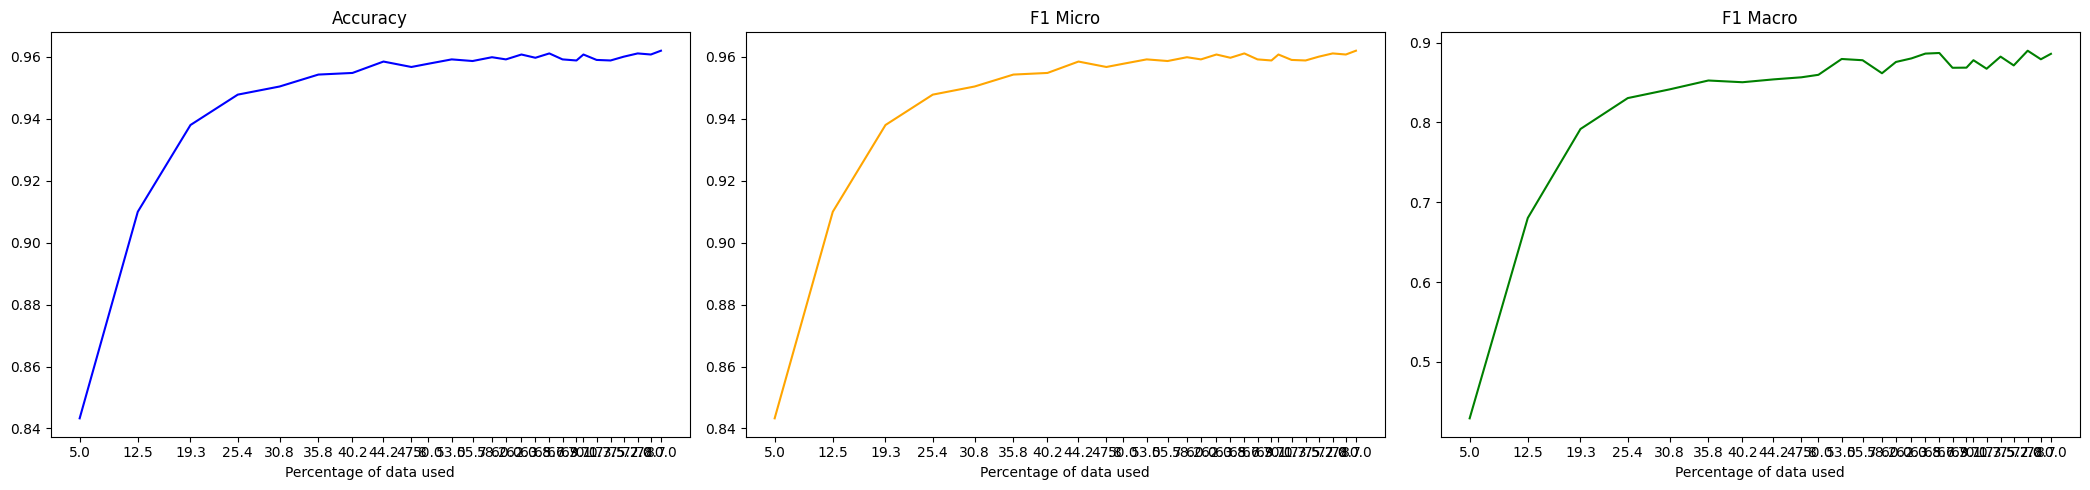

In [ ]:
active_learning(seeds[4], 4)